# 0.0 IMPORTS

## 0.1 Libraries

In [1]:
import os
import quandl
import inflection
import warnings
import bisect
import pandas as pd
import numpy as np
import scipy.stats  as ss

from IPython.display         import Image
from IPython.core.display    import HTML

import matplotlib.pyplot as plt
import seaborn as sns

# stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics         import (roc_auc_score, average_precision_score, precision_score,
                                    recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score)

from sklearn.linear_model    import LogisticRegression
from lightgbm                import LGBMClassifier
from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier

from boruta                  import BorutaPy

from imblearn.over_sampling import SMOTE
from collections import Counter
from skopt                   import forest_minimize


from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import joblib as jb

### 0.1.1 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
seed = 42
np.random.seed()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\fabio\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Helper Functions

In [4]:
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Mni', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m



def group_age(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



def cramerV(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))



def ml_scores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    balanced_accuracy = balanced_accuracy_score(y, yhat)
    ap = average_precision_score(y, yhat_proba)
    roc_auc = roc_auc_score(y, yhat_proba)
    
    return pd.DataFrame({ 'Model Name': model_name, 
                           'Precision': precision, 
                           'Recall': recall,
                           'F1 Score': f1,
                           'Kappa': kappa,
                           'Balanced Accuracy': balanced_accuracy,
                           'Average Precision Score': ap,
                           'ROC AUC': roc_auc}, index=[0])



def cross_validation(X_training, kfold, model_name, model, resample=False, verbose=False):
    smote = SMOTE()
    
    precision_list = []
    recall_list = []
    f1_list = []
    kappa_list = []
    accuracy_list = []
    ap_list = []
    roc_auc_list = []
    X_training = X_training.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kfold_training = training.drop(['exited'], axis=1)
        y_kfold_training = training['exited']
        
        if resample:
            X_kfold_training, y_kfold_training = smote.fit_sample(X_kfold_training, y_kfold_training)

        # Validation
        X_kfold_validation = validation.drop(['exited'], axis=1)
        y_kfold_validation = validation['exited']
        
        #Model
        model.fit(X_kfold_training, y_kfold_training)

        # Prediction
        yhat = model.predict(X_kfold_validation)
        
        # Prediction Proba
        yhat_proba = model.predict_proba(X_kfold_validation)[:,1]

        #Performance
        model_result = ml_scores(model_name, y_kfold_validation, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_list.append(model_result['Precision'].tolist())
        recall_list.append(model_result['Recall'].tolist())
        f1_list.append(model_result['F1 Score'].tolist())
        kappa_list.append(model_result['Kappa'].tolist())
        accuracy_list.append(model_result['Balanced Accuracy'].tolist())
        ap_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_list.append(model_result['ROC AUC'].tolist())
    

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_list),4).astype(str)],
                    'Balanced Accuracy': [np.round(np.mean(accuracy_list),4).astype(str) + ' +/- ' + np.round(np.std(accuracy_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)



def control_model_tune(df, model_name, kfold, space, metric, resample=False):

    def tune_model(params):
        smote = SMOTE()
        print(params)
        
        dict_params =    {'Lightgbm': {
                            'lr':params[0],
                            'max_depth': params[1],
                            'min_child_samples': params[2],
                            'subsample': params[3] if len(params) >= 4 else 1.0,
                            'colsample_bytree': params[4] if len(params) >= 5 else 1.0,
                            'n_estimators': params[5] if len(params) >= 6 else 100
                        }, 
                         'Random Forest': { 
                            'n_estimators': params[0],
                            'max_depth': params[1],
                            'min_samples_leaf': params[2]
                         },
                          'XGBoost':{
                            'lr':params[0],
                            'max_depth': params[1],
                            'min_child_weight': params[2],
                            'subsample': params[3] if len(params) >= 4 else 1.0,
                            'colsample_bytree': params[4] if len(params) >= 5 else 1.0,
                            'n_estimators': params[5] if len(params) >= 6 else 100,
                            'gamma': params[6] if len(params) >= 7 else 0.1
                          }
                         }


        nonlocal model_name
        nonlocal kfold
        nonlocal df
        nonlocal metric
        nonlocal resample

        precision_list = []
        recall_list = []
        f1_list = []
        kappa_list = []
        accuracy_list = []
        ap_list = []
        roc_auc_list = []
        param_list =[]
        X_training = df.sample(frac=1).reset_index(drop=True)
        for k in reversed(range(1, kfold+1)):

            # Filtering Dataset
            training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
            validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

            # Training and Validation Dataset
            # Training
            X_kfold_training = training.drop(['exited'], axis=1)
            y_kfold_training = training['exited']
            
            if resample:
                X_kfold_training, y_kfold_training = smote.fit_sample(X_kfold_training, y_kfold_training)
            # Validation
            X_kfold_validation = validation.drop(['exited'], axis=1)
            y_kfold_validation = validation['exited']
            
            # Model Mapping
            dict_model = {
                'Lightgbm': LGBMClassifier(learning_rate=dict_params['Lightgbm']['lr'],
                                                                num_leaves=2 ** dict_params['Lightgbm']['max_depth'],
                                                                max_depth=dict_params['Lightgbm']['max_depth'], 
                                                                min_child_samples=dict_params['Lightgbm']['min_child_samples'],
                                                                subsample=dict_params['Lightgbm']['subsample'],
                                                                colsample_bytree=dict_params['Lightgbm']['colsample_bytree'],
                                                                bagging_freq=1, n_estimators=dict_params['Lightgbm']['n_estimators'],
                                                                random_state=0, class_weight='balanced', n_jobs=-1),
                
                'Random Forest': RandomForestClassifier(n_estimators=dict_params['Random Forest']['n_estimators'],
                                                                   max_depth=dict_params['Random Forest']['max_depth'],
                                                                   min_samples_leaf=dict_params['Random Forest']['min_samples_leaf'],
                                                                   random_state=0, class_weight='balanced', n_jobs=-1),
                
                'XGBoost': XGBClassifier(learning_rate=dict_params['XGBoost']['lr'],
                                         num_leaves=2 ** dict_params['XGBoost']['max_depth'],
                                         max_depth=dict_params['XGBoost']['max_depth'],
                                         min_child_weight=dict_params['XGBoost']['min_child_weight'],
                                         subsample=dict_params['XGBoost']['subsample'],
                                         colsample_bytree=dict_params['XGBoost']['colsample_bytree'],
                                         n_estimators = dict_params['XGBoost']['n_estimators'],
                                         gamma = dict_params['XGBoost']['gamma'],
                                         bagging_freq=1, random_state=0, class_weight='balanced', n_jobs=-1)
                }

            #Model
            model = dict_model[model_name]

            model.fit(X_kfold_training, y_kfold_training)

               # Prediction
            yhat = model.predict(X_kfold_validation)

            # Prediction Proba
            yhat_proba = model.predict_proba(X_kfold_validation)[:,1]
                    #Performance
            model_result = ml_scores(model_name, y_kfold_validation, yhat, yhat_proba)

            #Store Performance of each KFold iteration
            precision_list.append(model_result['Precision'].tolist())
            recall_list.append(model_result['Recall'].tolist())
            f1_list.append(model_result['F1 Score'].tolist())
            kappa_list.append(model_result['Kappa'].tolist())
            accuracy_list.append(model_result['Balanced Accuracy'].tolist())
            ap_list.append(model_result['Average Precision Score'].tolist())
            roc_auc_list.append(model_result['ROC AUC'].tolist())
            param_list.append(dict_params[model_name])


        dict_result = {
                        'Model Name': [model_name + ' Classifier'],
                        'Metric': [metric],
                        'Resample': [resample],
                        'Precision CV': [np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)],
                        'Recall CV': [np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)],
                        'F1 Score CV': [np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)],
                        'Kappa CV': [np.round(np.mean(kappa_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_list),4).astype(str)],
                        'Balanced Accuracy': [np.round(np.mean(accuracy_list),4).astype(str) + ' +/- ' + np.round(np.std(accuracy_list),4).astype(str)],
                        'Average Precision Score CV': [np.round(np.mean(ap_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_list),4).astype(str)],
                        'ROC AUC CV': [np.round(np.mean(roc_auc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_list),4).astype(str)],
                        'Params': [param_list]
                    }


        df_metrics = pd.DataFrame(dict_result)
        global df_results
        df_results = pd.concat([df_metrics, df_results], axis=0)
        
        dict_metric = {    
                        'Precision': np.mean(precision_list), 
                        'Recall': np.mean(recall_list),
                        'F1 Score': np.mean(f1_list),
                        'Kappa': np.mean(kappa_list),
                        'Balanced Accuracy': np.mean(accuracy_list),
                        'Average Precision': np.mean(ap_list),
                        'ROC AUC': np.mean(roc_auc_list)}

        return -dict_metric[metric]

    return forest_minimize(tune_model, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

## 0.3 Load Data

In [5]:
df_raw = pd.read_csv('../../01-Data/churn.csv')

In [6]:
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
country_indicators = {
                        'BCA': 'current_account_balance',
                        'LE':'employment',
                        'NGDP_D': 'GDP_deflator',
                        'GGXWDG': 'general_government_gross_debt',
                        'GGR': 'general_government_revenue',
                        'GGSB': 'general_government_structural_balance',
                        'PCPI': 'inflation_index_average_consumer_prices',
                        'PPPPC': 'per_capita_GDP_PPP_valuation'
                    }

countries = {
           'FRA': 'France',
           'DEU':'Germany',
           'ESP': 'Spain'
        }
#https://www.quandl.com/data/ODA-IMF-Cross-Country-Macroeconomic-Statistics/documentation
#https://s3.amazonaws.com/quandl-production-static/API+Descriptions/WHO/ccodes.txt
data_dict ={
                'current_account_balance': [],
                'employment': [],
                'GDP_deflator': [],
                'general_government_gross_debt': [],
                'general_government_revenue': [],
                'general_government_structural_balance': [],
                'inflation_index_average_consumer_prices': [],
                'per_capita_GDP_PPP_valuation': [],
                'Geography':[]
            }

quandl_api_key = os.environ.get('QUANDL_API_KEY')
quandl.ApiConfig.api_key = quandl_api_key

for country in countries.keys():
    for ind in country_indicators.keys():
        data = quandl.get("ODA/{}_{}".format(country, ind), start_date='2020-12-31', end_date='2020-12-31')
        data_dict[country_indicators[ind]].append(data.iloc[0,0])
    data_dict['Geography'].append(countries[country])
df_country_indicators = pd.DataFrame(data_dict)
df_country_indicators.to_feather('00-Data/quandl_data.feather')
df_country_indicators.head()

,current_account_balance,employment,GDP_deflator,general_government_gross_debt,general_government_revenue,general_government_structural_balance,inflation_index_average_consumer_prices,per_capita_GDP_PPP_valuation,Geography
0,-0.546,25.736,106.191,2455.29,1293.890,-61.129,106.598,48415.25,France
1,282.002,42.031,118.398,1935.55,1629.620,22.988,107.193,55764.47,Germany
2,12.455,19.763,106.502,1229.61,501.761,-35.873,106.625,43006.94,Spain


### 0.3.1 Split data into train and test dataset

In [8]:
# Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_raw, df_raw['Exited']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)

### 0.3.2 Saving Train and Test Dataset

In [9]:
# Convert to .Feather Data
train_dataset.to_feather('00-Data/train_dataset.feather')
test_dataset.to_feather('00-Data/test_dataset.feather')

### 0.3.3 Load Train Dataset

In [10]:
df_train_dataset = pd.read_feather('00-Data/train_dataset.feather')

In [11]:
df_train_dataset = pd.merge(df_train_dataset, df_country_indicators, how='left', on='Geography')
df_train_dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,current_account_balance,employment,GDP_deflator,general_government_gross_debt,general_government_revenue,general_government_structural_balance,inflation_index_average_consumer_prices,per_capita_GDP_PPP_valuation
0,2152,15588614,Walton,753,France,Male,57,7,0.00,1,1,0,159475.08,1,-0.546,25.736,106.191,2455.29,1293.89,-61.129,106.598,48415.25
1,8393,15641158,Belcher,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1,282.002,42.031,118.398,1935.55,1629.62,22.988,107.193,55764.47
2,5007,15750014,Chikere,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0,282.002,42.031,118.398,1935.55,1629.62,22.988,107.193,55764.47
3,4118,15663964,Pagnotto,561,France,Male,37,5,0.00,2,1,0,83093.25,0,-0.546,25.736,106.191,2455.29,1293.89,-61.129,106.598,48415.25
4,7183,15573520,Rhodes,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0,282.002,42.031,118.398,1935.55,1629.62,22.988,107.193,55764.47


# 1.0 DATA DESCRIPTION

In [12]:
df01 = df_train_dataset.copy()

# 1.1 Data Information
---

> - **RowNumber:**       Corresponds to the record (row) number;
> - **CustomerId:**      Contains unique identifier;
> - **Surname:**         Customer's surname;
> - **CreditScore:**     Customer's credit score for the consumer market;
> - **Geography:**       Customer’s country;
> - **Gender:**          Customer's gender;
> - **Age:**             Customer's age;
> - **Tenure:**          Number of years that the customer has been a client of the bank;
> - **Balance:**         The amount that the customer has in the bank account;
> - **NumOfProducts:**   Refers to the number of products that a customer has purchased through the bank;
> - **HasCrCard:**       Denotes whether or not a customer has a credit card;
> - **IsActiveMember:**  Denotes whether or not a customer is an active member;
> - **EstimatedSalary:** Estimate customer's annually income;
> - **Exited:**          Whether or not the customer is in Churn;

> - **current_account_balance:** Current Account Balance, USD Billions 
> - **employment:** Employment, Millions
> - **GDP_deflator:** GDP Deflator
> - **general_government_gross_debt:** General Government Gross Debt, USD Billions
> - **general_government_revenue:** General Government Revenue, USD Billions
> - **general_government_structural_balance:** General Government Structural Balance, USD Billions
> - **inflation_index_average_consumer_prices:** Inflation Index, Average Consumer Prices
> - **per_capita_GDP_PPP_valuation:** Per Capita GDP based on PPP Valuation, USD

## 1.2 Columns

In [13]:
df01.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited',
       'current_account_balance', 'employment', 'GDP_deflator',
       'general_government_gross_debt', 'general_government_revenue',
       'general_government_structural_balance',
       'inflation_index_average_consumer_prices',
       'per_capita_GDP_PPP_valuation'],
      dtype='object')

### 1.2.1 Rename Columns

In [14]:
snakecase = lambda col: inflection.underscore(col)

new_columns = list(map(snakecase, df01.columns))

# rename
df01.columns = new_columns

#### 1.2.2 New Name Columns

In [15]:
df01.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited',
       'current_account_balance', 'employment', 'gdp_deflator',
       'general_government_gross_debt', 'general_government_revenue',
       'general_government_structural_balance',
       'inflation_index_average_consumer_prices',
       'per_capita_gdp_ppp_valuation'],
      dtype='object')

## 1.3 Data Dimensions

In [16]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 8000
Number of Columns: 22


## 1.4 Data Types

In [17]:
df01.dtypes

row_number                                   int64
customer_id                                  int64
surname                                     object
credit_score                                 int64
geography                                   object
gender                                      object
age                                          int64
tenure                                       int64
balance                                    float64
num_of_products                              int64
has_cr_card                                  int64
is_active_member                             int64
estimated_salary                           float64
exited                                       int64
current_account_balance                    float64
employment                                 float64
gdp_deflator                               float64
general_government_gross_debt              float64
general_government_revenue                 float64
general_government_structural_b

## 1.5 Not a Number

### 1.5.1 Sum NA

In [18]:
df01.isnull().sum()

row_number                                 0
customer_id                                0
surname                                    0
credit_score                               0
geography                                  0
gender                                     0
age                                        0
tenure                                     0
balance                                    0
num_of_products                            0
has_cr_card                                0
is_active_member                           0
estimated_salary                           0
exited                                     0
current_account_balance                    0
employment                                 0
gdp_deflator                               0
general_government_gross_debt              0
general_government_revenue                 0
general_government_structural_balance      0
inflation_index_average_consumer_prices    0
per_capita_gdp_ppp_valuation               0
dtype: int

### 1.5.2 ~~Fillout NA~~

there is no NA values

## 1.6 Descriptive Statistical

In [19]:
# Numerical Attributes
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
not_numerial = ['row_number', 'customer_id']
num_attributes_cols = list(np.setdiff1d(num_attributes.columns, not_numerial))
num_attributes = num_attributes[num_attributes_cols]

#Categorical Attributes
cat_attributes = df01.select_dtypes(include=['object'])

### 1.5.1 Numerical Attributes

In [20]:
## Statatistical Summary (Helper Function)
statistical_summary(num_attributes)

,Attributes,Mni,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,age,18.000,92.000,74.000,35.000,38.946625,37.000,25.0000,27.000,32.0000,44.000,53.000,60.000,10.526219,0.270273,1.035706,1.459448
1,balance,0.000,238387.560,238387.560,0.000,76381.207499,97055.145,0.0000,0.000,0.0000,127633.195,149005.811,162442.667,62298.159597,0.815622,-0.141721,-1.492209
2,credit_score,350.000,850.000,500.000,850.000,650.752500,652.000,489.0000,522.000,584.0000,717.000,778.000,812.000,96.590394,0.148429,-0.079540,-0.418624
3,current_account_balance,-0.546,282.002,282.548,-0.546,73.521093,12.455,-0.5460,-0.546,-0.5460,282.002,282.002,282.002,120.683899,1.641487,1.144450,-0.680467
4,employment,19.763,42.031,22.268,25.736,28.325191,25.736,19.7630,19.763,19.7630,42.031,42.031,42.031,8.292883,0.292774,0.840951,-0.840746
5,estimated_salary,11.580,199992.480,199980.900,24924.920,99730.811581,99446.940,9903.3685,20330.208,50691.8175,148527.730,179035.035,190113.789,57331.532983,0.574863,0.007126,-1.174789
6,exited,0.000,1.000,1.000,0.000,0.203750,0.000,0.0000,0.000,0.0000,0.000,1.000,1.000,0.402785,1.976860,1.471283,0.164715
7,gdp_deflator,106.191,118.398,12.207,106.191,109.328207,106.502,106.1910,106.191,106.1910,118.398,118.398,118.398,5.246711,0.047990,1.149057,-0.676776
8,general_government_gross_debt,1229.610,2455.290,1225.680,2455.290,2018.303742,1935.550,1229.6100,1229.610,1229.6100,2455.290,2455.290,2455.290,502.685485,0.249063,-0.639870,-1.198352
9,general_government_revenue,501.761,1629.620,1127.859,1293.890,1179.802049,1293.890,501.7610,501.761,501.7610,1629.620,1629.620,1629.620,415.038552,0.351787,-0.761848,-0.868588


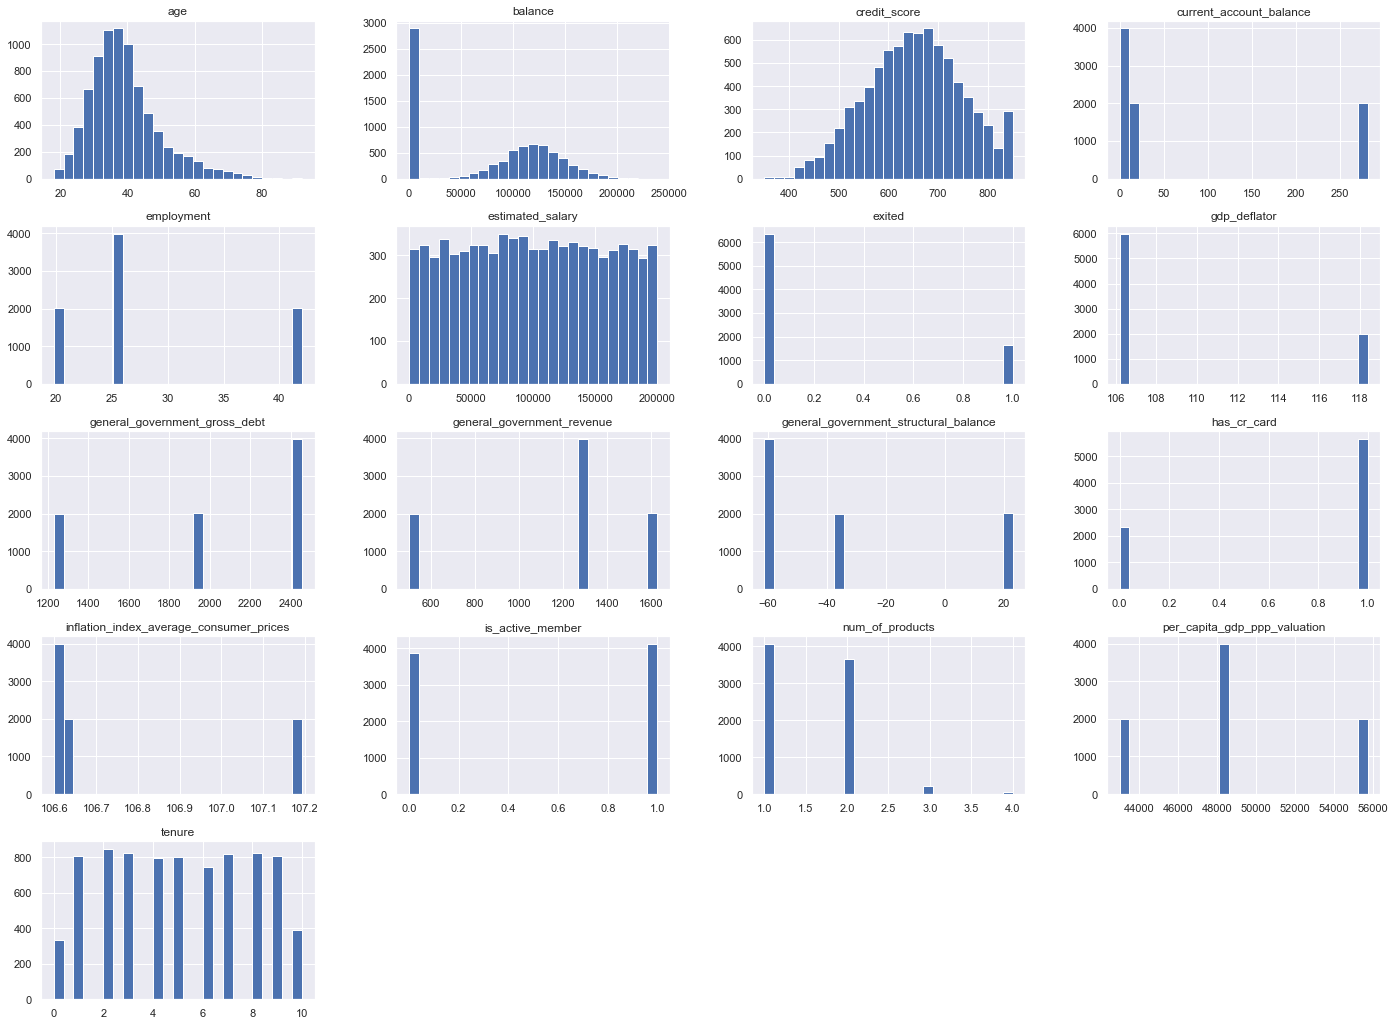

In [21]:
num_attributes.hist(bins=25, figsize=(24,18));

#### 1.5.1.2 Some considerations
---
> **age**
>> - The age range is large and it will be interesting to group by bands
>> - 50% are between 32 and 44 years (Adults)
>
> **balance**
>> - According to the relative std the distribution presents a great degree of dispersion
>> - Almost 38% equals 0.00
>
> **credit_score**
>> - Although it has a high std, it has a relative low std which shows a small degree of dispersion
>> - Both Skew and low kurtosis show that the distribution is close to a normal curve
>> - However close the average and median are, the mode is consiversibly greater and evidences the asymmetry of the distribution
>
> **estimated_salary**
>> - As the distribution has a very high std and a relative std as well, it can be noted that it is a uniform distribution with great dispersion
>
> **has_cr_card**
>> - 75% has credit card
>
> **is_active_member**
>> - 50% of the customers has done a bank activity in the past 12 months
>
> **num_of_products**
>> - all customers have bought at least one product
>
> **tenure**
>> - According to the relative std the distribution presents a great degree of dispersion
>

>
> **exited**
>> - Customers in Churn: 20% (Disbalanced Dataset) 

## 2.0 FEATURE ENGINEERING

In [22]:
df02 = df01.copy()

## 2.1 Mind Map

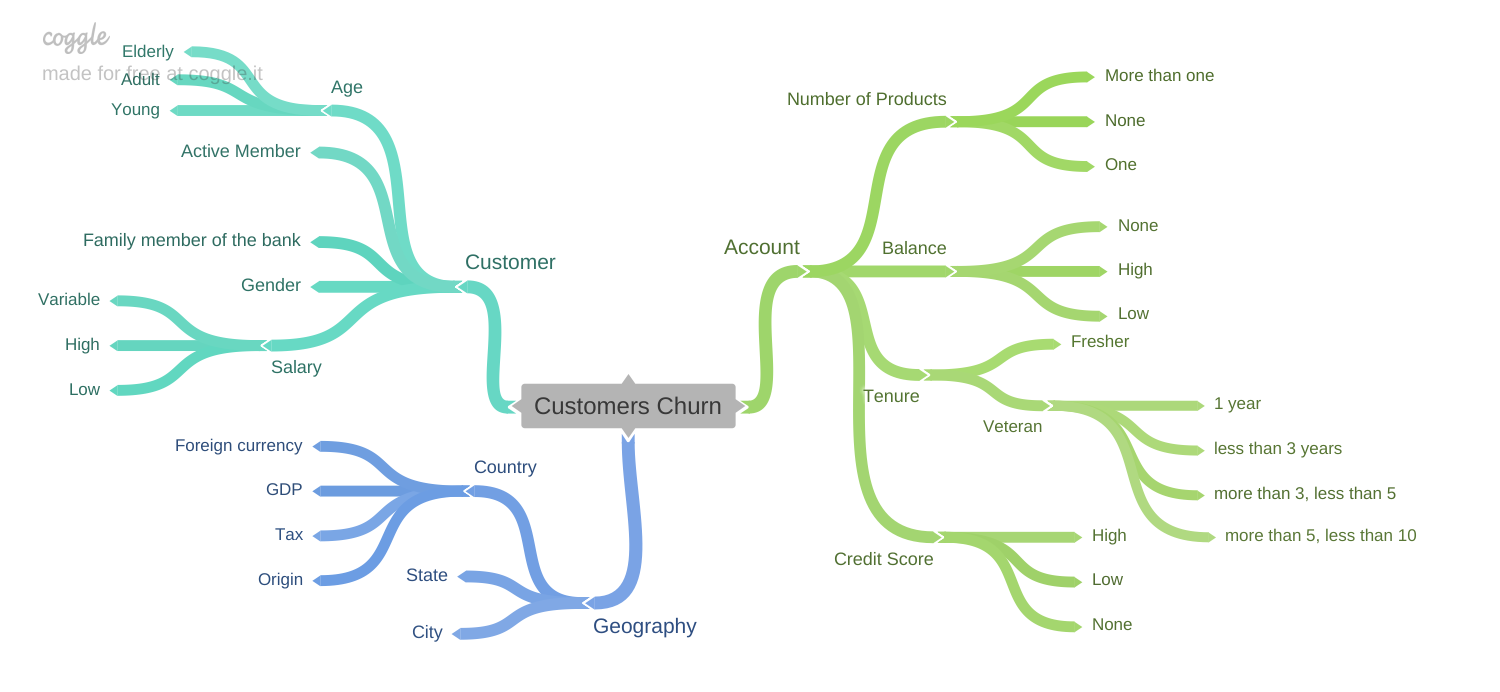

In [23]:
Image('../../img/01-FirstCycleCRISPCostumerChurn.png')

### 2.1.1 Formulation of Hypothesis

---
> **Customer**
>> - H01 - Customers with churn tend to be influenced by family members
>> - H02 - Men usually have more churn
>> - H03 - Women usually buy more products
>> - H04 - Younger clients are less loyal and more likely to leave a bank
>> - H05 - Older customers are less likely to leave their bank than younger ones
>> - H06 - Churn should occur for customers with high salary
>> - H07 - Churn should occur for customers with high balance
>
> **Geography**
>> - H01 - Countries with higher GDP should have lower churn
>> - H02 - In countries more competitive in relation to currency exchange there is less churn
>> - H03 - Countries of Latin origin should have higher number of churn
>
> **Account**
>> - H01 - Active members should have less churn
>> - H02 - Active members should have more products
>> - H03 - The more products the customer has, the less likely it is to go into churn
>> - H04 - Customers with credit cards are more active
>> - H05 - Churn should occur for customers with low tenur
>> - H06 - Customers with Credit Cards tend to stay at the bank
>> - H07 - Customers with higher balance remain at the bank

### 2.1.2 Final Hypothesis List
---
> - H01 - Men usually have more churn
> - H02 - Younger clients are less loyal and more likely to leave a bank
> - H03 - Churn should occur for customers with high salary
> - H04 - Churn should occur for customers with high balance
> - H05 - Countries of Latin origin should have higher number of churn
> - H06 - Active members should have less churn
> - H07 - Churn should occur for customers with low tenure
> - H08 - The more products the customer has, the less likely it is to go into churn
> - H09 - Customers with Credit Cards tend to stay at the bank

## 2.2 Feature Engineering

In [24]:
# Tenure Vigency
df02['tenure_vigency'] = df02['tenure'] + 1

# tenure_vigency / age
df02['tenure_vigency_age'] = df02['tenure_vigency'] / df02['age']

# credit_score / tenure_vigency
df02['cred_score_tenure_vigency'] = df02['credit_score'] / df02['tenure_vigency']

# credit_score / age
df02['cred_age'] = df02['credit_score'] / df02['age']

# amount
df02['amount'] = df02['estimated_salary'] + df02['balance']

# amount / credit_score
df02['amount_credit'] = df02['amount'] / df02['credit_score']

# amount / tenure_vigency
df02['amount_tenure_vigency'] = df02['amount'] / df02['tenure_vigency']

# amount / num_of_products
df02['amount_num_of_products'] = df02['amount'] / df02['num_of_products']

# credit score / num_of_products
df02['cred_num_of_products'] = df02['credit_score'] / df02['num_of_products']

# balance / tenure_vigency
df02['bal_tenure_vigency'] = df02['balance'] / df02['tenure_vigency']

# num_of_products - credit card
df02['num_of_products_has_cr_card_sub'] = df02['num_of_products'] - df02['has_cr_card']

# num_of_products * credit card
df02['num_of_products_has_cr_card_mul'] = df02['num_of_products'] * df02['has_cr_card']

# tenure_vigency_age * balance
df02['tenure_vigency_age_balance'] = df02['tenure_vigency_age'] * df02['balance']

# balance * is_active_member
df02['balance_is_active_member'] = df02['balance'] * df02['is_active_member']

# Group Age
df02['age_group'] = df02['age'].apply(lambda row: group_age(row))

# Country Origin
origin_map = {
    'France': 'latin',
    'Spain': 'latin',
    'Germany': 'anglo-saxons'
}

df02['origin'] = df02['geography'].map(origin_map)

# balance / current_account_balance
df02['balance_current_account_balance'] = df02['balance'] / df02['current_account_balance']

# credit_score / inflation_index_average_consumer_prices
df02['credit_score_inflation_index'] = df02['credit_score'] / df02['inflation_index_average_consumer_prices']

# num_of_products / inflation_index_average_consumer_prices
df02['num_of_products_inflation_index'] = df02['num_of_products'] / df02['inflation_index_average_consumer_prices']

# credit_score / per_capita_gdp_ppp_valuation
df02['credit_score_per_capita_gdp_ppp_valuation'] = df02['credit_score'] / df02['per_capita_gdp_ppp_valuation']

# tenure * (per_capita_gdp_ppp_valuation / employment)
df02['tenure_employment_per_capita_gdp_ppp_valuation'] = (df02['per_capita_gdp_ppp_valuation'] / df02['employment']) * df02['tenure']

# estimated_salary / per_capita_gdp_ppp_valuation
df02['estimated_salary_per_capita_gdp_ppp_valuation'] = df02['estimated_salary'] / df02['per_capita_gdp_ppp_valuation']

# (estimated_salary * per_capita_gdp_ppp_valuation) / credit_score
df02['estimated_salary_inflation_index_credit_score'] = (df02['estimated_salary'] * df02['per_capita_gdp_ppp_valuation']) / df02['credit_score']

# num_of_products / gdp_deflator
df02['num_of_products_gdp_deflator'] = df02['num_of_products'] / df02['gdp_deflator']

# (tenure * credit_score) / employment
df02['tenure_credit_score_employment'] = (df02['tenure'] * df02['credit_score']) / df02['employment']

# (general_government_gross_debt / general_government_revenue) * estimated_salary
df02['num_of_products_gdp_deflator'] = (df02['general_government_gross_debt'] / df02['general_government_revenue']) * df02['estimated_salary']

# 3.0. VARIABLES FILTERING

In [25]:
df03 = df02.copy()

## 3.1 ~~Row Fitering~~

## 3.2 Columns Filtering

In [26]:
to_drop = ['row_number', 'customer_id', 'surname']
df03.drop(to_drop, axis=1, inplace=True)

# 4.0 EXPLORATORY DATA ANALYSIS

In [27]:
df04 = df03.copy()

## 4.1 Response Variable

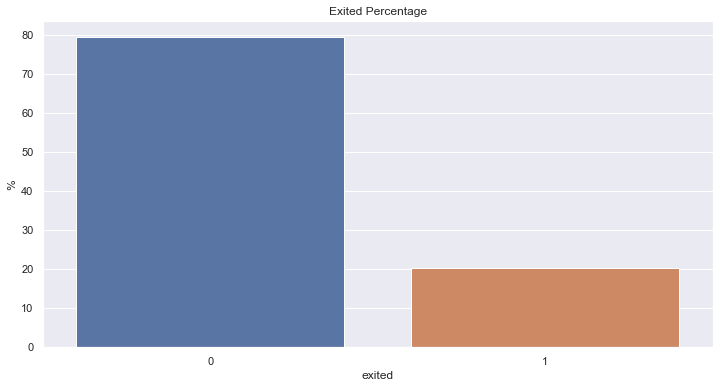

In [28]:
exited_percentage = df04['exited'].value_counts(normalize=True)*100
plt.figure(figsize=(12,6))
sns.barplot(x=exited_percentage.index, y=exited_percentage);
plt.ylabel('%');
plt.xlabel('exited');
plt.title('Exited Percentage');

## 4.2 Univariate Analysis

### 4.2.1 Numerical Attributes

In [29]:
num_attributes = df04.select_dtypes(include=['int64', 'float64'])
statistical_summary(num_attributes)

,Attributes,Mni,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,credit_score,350.000000,8.500000e+02,5.000000e+02,850.000000,6.507525e+02,6.520000e+02,489.000000,5.220000e+02,5.840000e+02,7.170000e+02,7.780000e+02,8.120000e+02,9.659039e+01,0.148429,-0.079540,-0.418624
1,age,18.000000,9.200000e+01,7.400000e+01,35.000000,3.894662e+01,3.700000e+01,25.000000,2.700000e+01,3.200000e+01,4.400000e+01,5.300000e+01,6.000000e+01,1.052622e+01,0.270273,1.035706,1.459448
2,tenure,0.000000,1.000000e+01,1.000000e+01,2.000000,5.016625e+00,5.000000e+00,1.000000,1.000000e+00,3.000000e+00,8.000000e+00,9.000000e+00,9.000000e+00,2.896610e+00,0.577402,0.013124,-1.172842
3,balance,0.000000,2.383876e+05,2.383876e+05,0.000000,7.638121e+04,9.705515e+04,0.000000,0.000000e+00,0.000000e+00,1.276332e+05,1.490058e+05,1.624427e+05,6.229816e+04,0.815622,-0.141721,-1.492209
4,num_of_products,1.000000,4.000000e+00,3.000000e+00,1.000000,1.529500e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,5.817042e-01,0.380323,0.755984,0.636943
5,has_cr_card,0.000000,1.000000e+00,1.000000e+00,1.000000,7.087500e-01,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.543385e-01,0.641042,-0.919091,-1.155561
6,is_active_member,0.000000,1.000000e+00,1.000000e+00,1.000000,5.148750e-01,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.997787e-01,0.970680,-0.059538,-1.996955
7,estimated_salary,11.580000,1.999925e+05,1.999809e+05,24924.920000,9.973081e+04,9.944694e+04,9903.368500,2.033021e+04,5.069182e+04,1.485277e+05,1.790350e+05,1.901138e+05,5.733153e+04,0.574863,0.007126,-1.174789
8,exited,0.000000,1.000000e+00,1.000000e+00,0.000000,2.037500e-01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.027852e-01,1.976860,1.471283,0.164715
9,current_account_balance,-0.546000,2.820020e+02,2.825480e+02,-0.546000,7.352109e+01,1.245500e+01,-0.546000,-5.460000e-01,-5.460000e-01,2.820020e+02,2.820020e+02,2.820020e+02,1.206839e+02,1.641487,1.144450,-0.680467


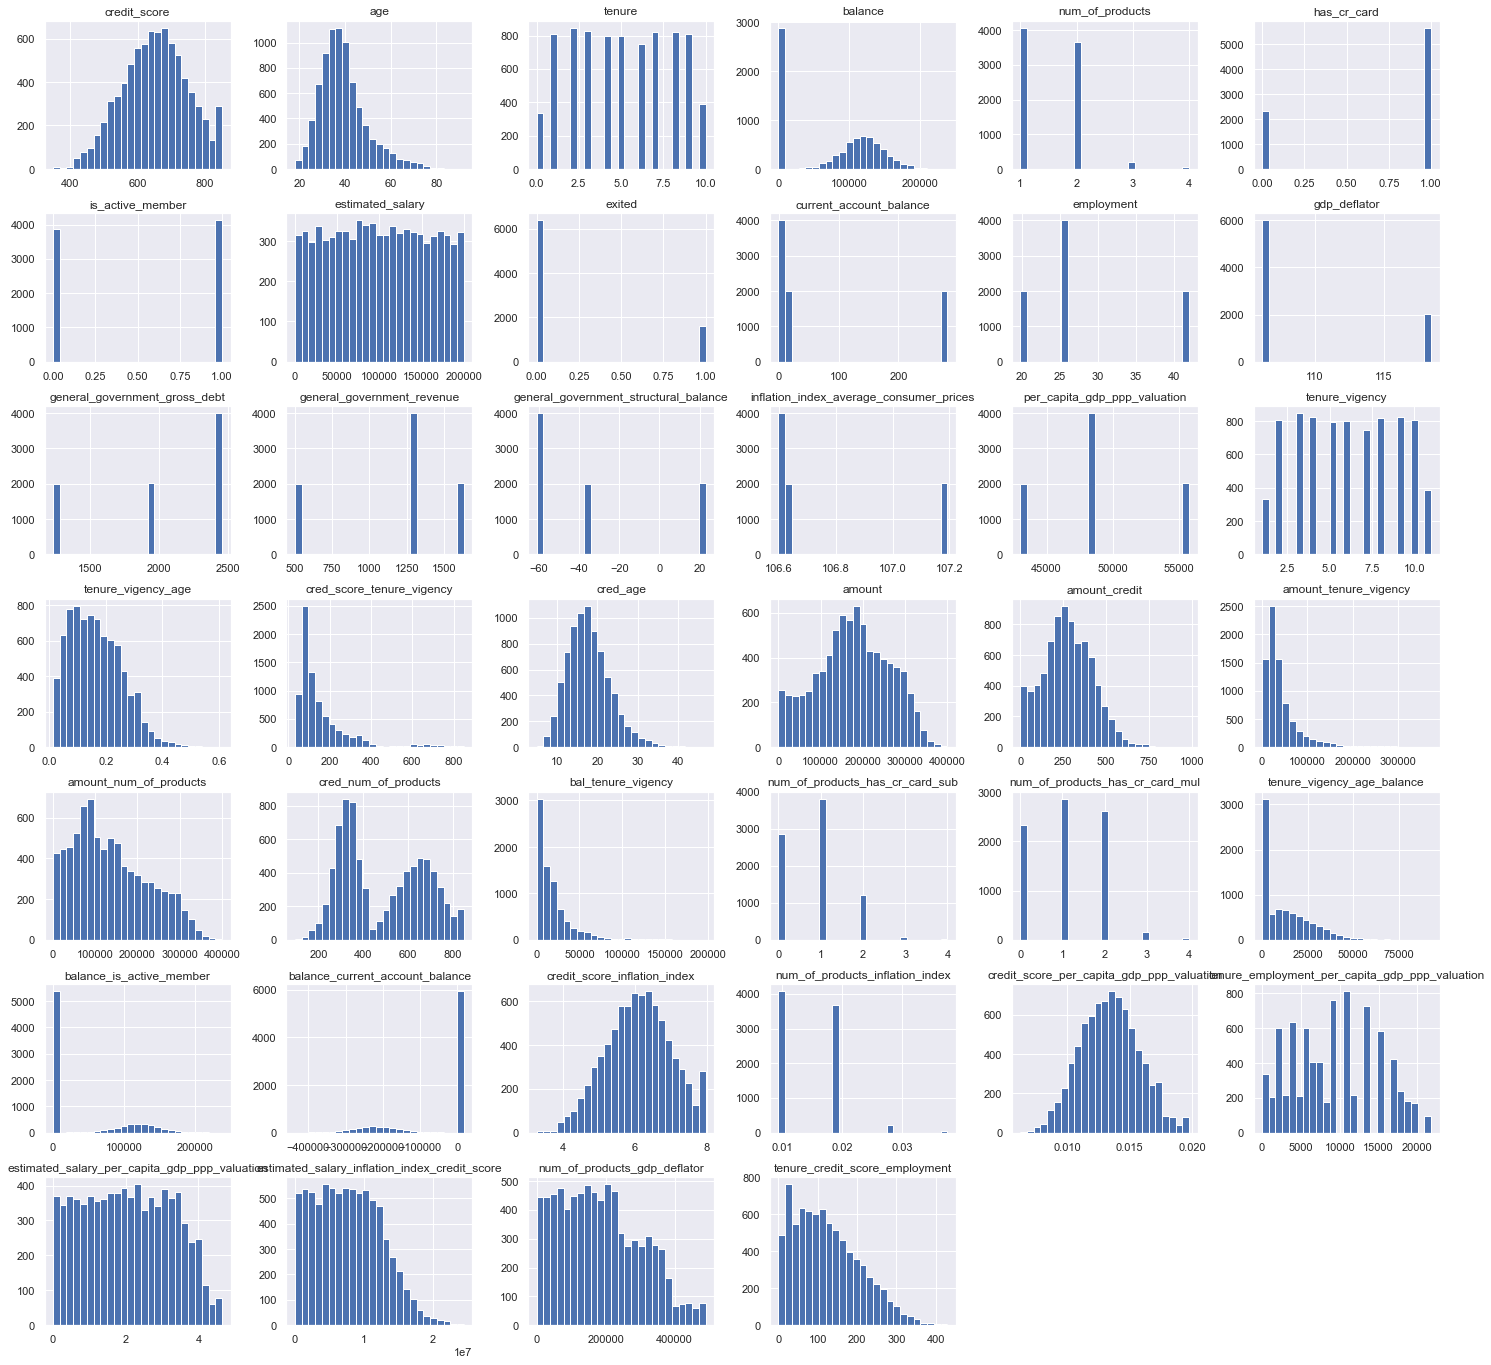

In [30]:
num_attributes.hist(bins=25, figsize=(25,24));

### 4.2.2 Categorical Attributes

In [31]:
#Categorical Attributes
cat_attributes = df04.select_dtypes(include=['object'])

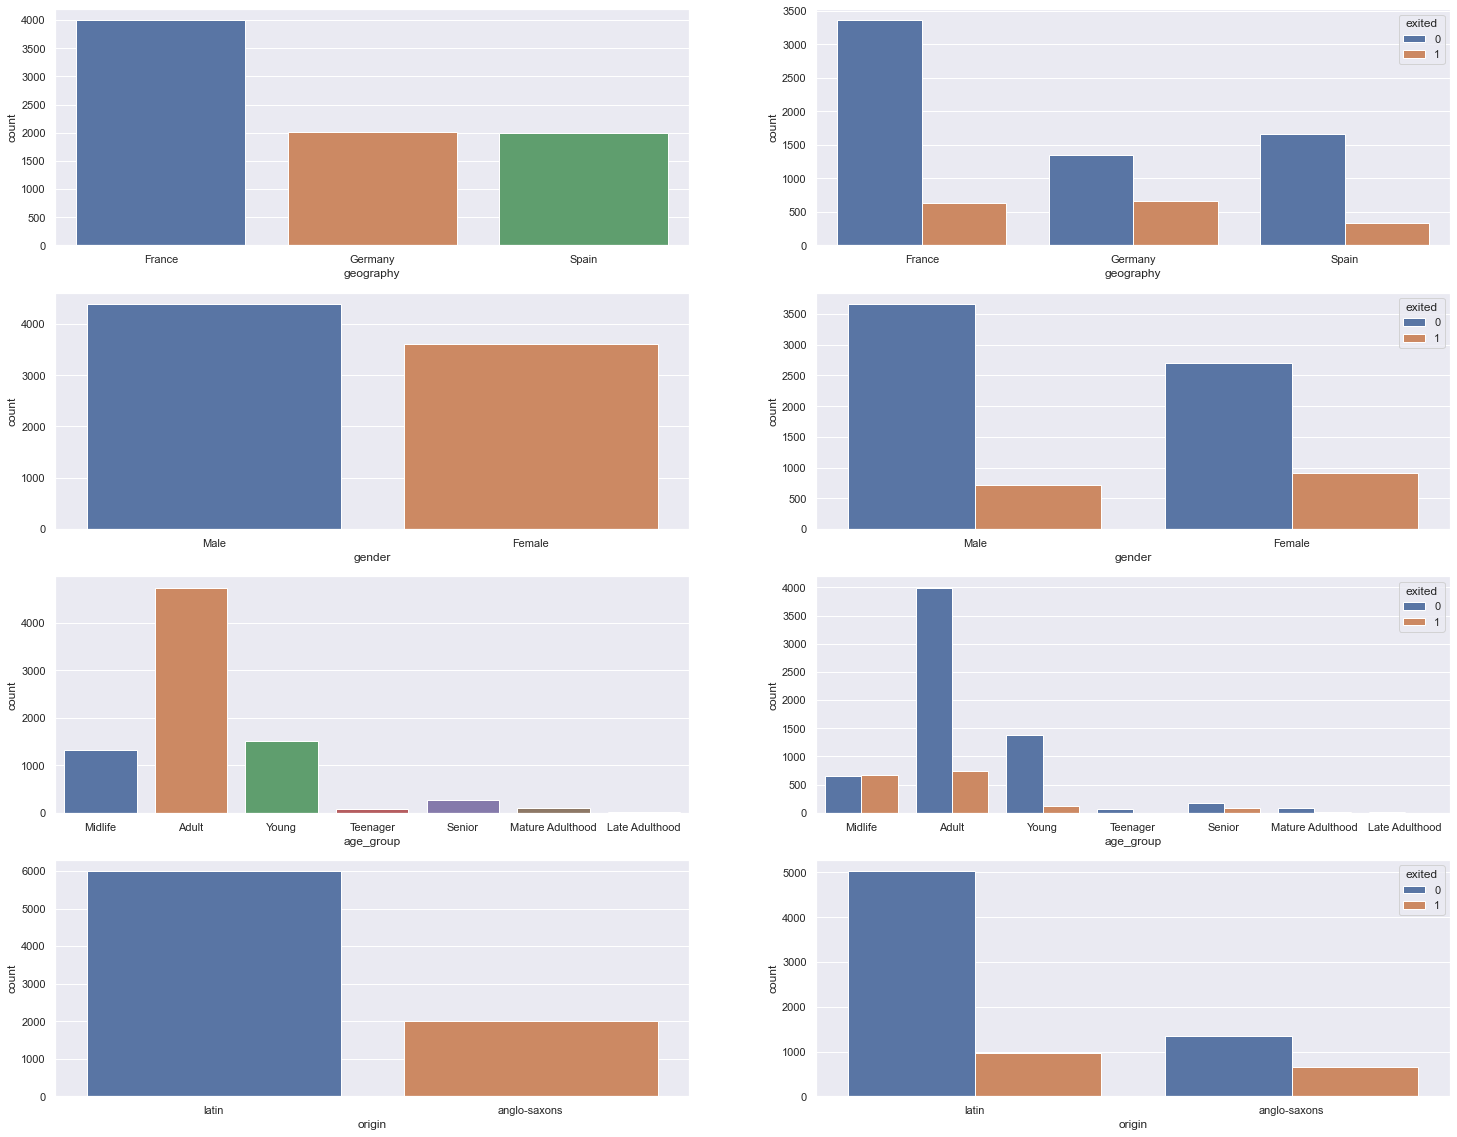

In [32]:
count = 1
rows= len(cat_attributes.columns)
plt.figure(figsize=(25,5*rows))
for i in cat_attributes:
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, data=df04)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, hue='exited', data=df04)
    count += 1
plt.show()

## 4.3 Bivariate Analysis

### 4.3.1 Final Hypothesis List
---
> - H01 - Men usually have more churn
> - H02 - Younger clients are less loyal and more likely to leave a bank
> - H03 - Churn should occur for customers with high salary
> - H04 - Churn should occur for customers with high balance
> - H05 - Countries of Latin origin should have higher number of churn
> - H06 - Active members should have less churn
> - H07 - Churn should occur for customers with low tenure
> - H08 - The more products the customer has, the less likely it is to go into churn
> - H09 - Customers with Credit Cards tend to stay at the bank

### H01 - Men usually have more churn
---
> - Conclusion: **FALSE** 
>> **WOMEN** have more churn

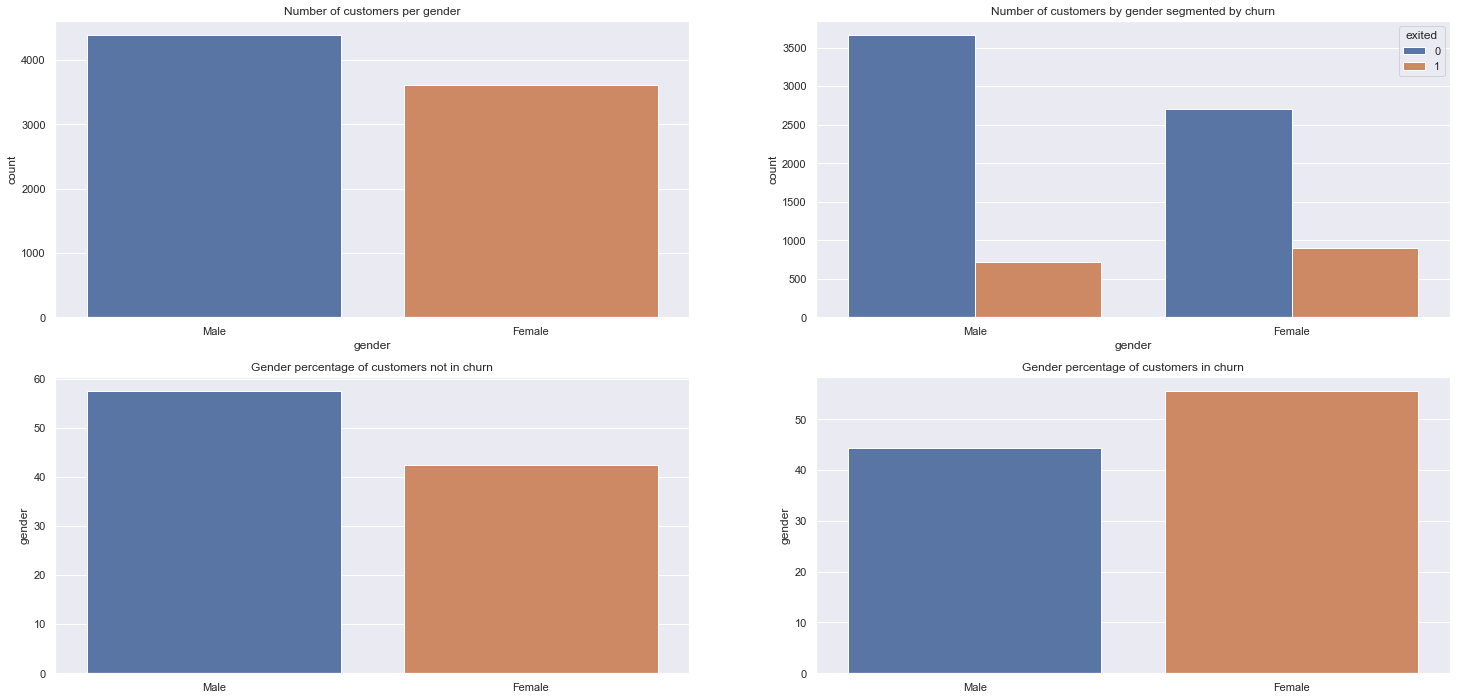

In [33]:
plt.subplot(2,2,1)
sns.countplot(x='gender', order=['Male', 'Female'], data=df04).set_title('Number of customers per gender');

plt.subplot(2,2,2)
sns.countplot(x='gender', hue='exited', order=['Male', 'Female'], data=df04).set_title('Number of customers by gender segmented by churn');

plt.subplot(2,2,3)
gender_percentage_not_churn = df04[df04['exited'] == 0]['gender'].value_counts(normalize=True)*100
sns.barplot(x=gender_percentage_not_churn.index, y=gender_percentage_not_churn, order=['Male', 'Female']).set_title('Gender percentage of customers not in churn');

plt.subplot(2,2,4)
gender_percentage_churn = df04[df04['exited'] == 1]['gender'].value_counts(normalize=True)*100
sns.barplot(x=gender_percentage_churn.index, y=gender_percentage_churn, order=['Male', 'Female']).set_title('Gender percentage of customers in churn');

### H02 - Younger clients are less loyal and more likely to leave a bank
---
> - Conclusion: **FALSE** 
>> Younger clients are **MORE** loyal and more likely to leave a bank

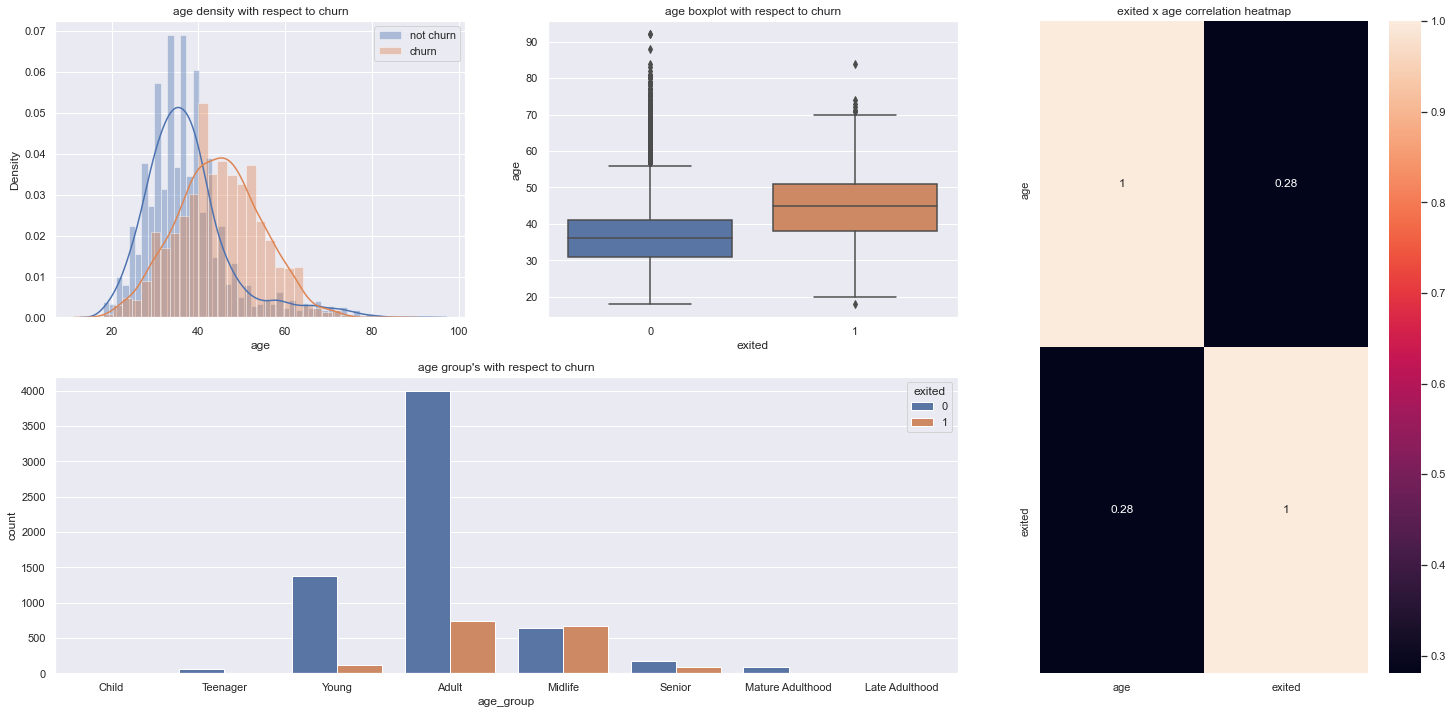

In [34]:
aux02 = df04[['age', 'age_group', 'exited']]

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
#sns.histplot(x='age', bins=25, hue='exited', data=aux01);
sns.distplot(aux02[aux02['exited'] == 0]['age'], label='not churn');
sns.distplot(aux02[aux02['exited'] == 1]['age'], label='churn');
plt.title("age density with respect to churn");
plt.legend();

plt.subplot(grid[0,1])
sns.boxplot(x='exited', y='age', data=aux02).set_title("age boxplot with respect to churn");

plt.subplot(grid[1,:2])
sns.countplot(x='age_group', hue='exited', order=['Child', 'Teenager', 'Young',
                                                  'Adult','Midlife','Senior','Mature Adulthood','Late Adulthood'], data=aux02);
plt.title("age group's with respect to churn");

plt.subplot(grid[:,2])
sns.heatmap(aux02.corr(method='pearson'),annot=True).set_title("exited x age correlation heatmap");

### H03 - Churn should occur for customers with high salary
---
> - Conclusion: **TRUE** 
>> Churn occur for clients with high salary

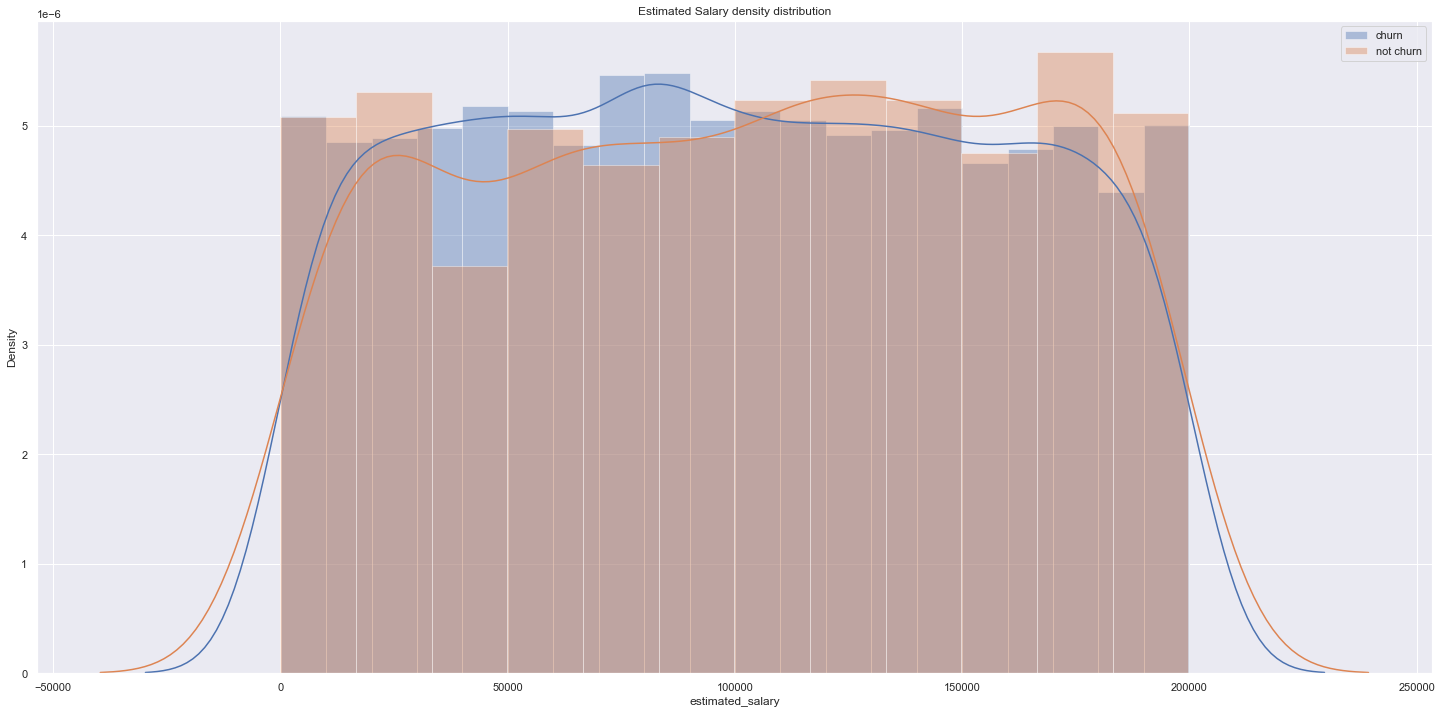

In [35]:
sns.distplot(df04[df04['exited'] == 0]['estimated_salary'], kde=True, label='churn')
sns.distplot(df04[df04['exited'] == 1]['estimated_salary'], kde=True, label='not churn')
plt.title('Estimated Salary density distribution');
plt.legend();

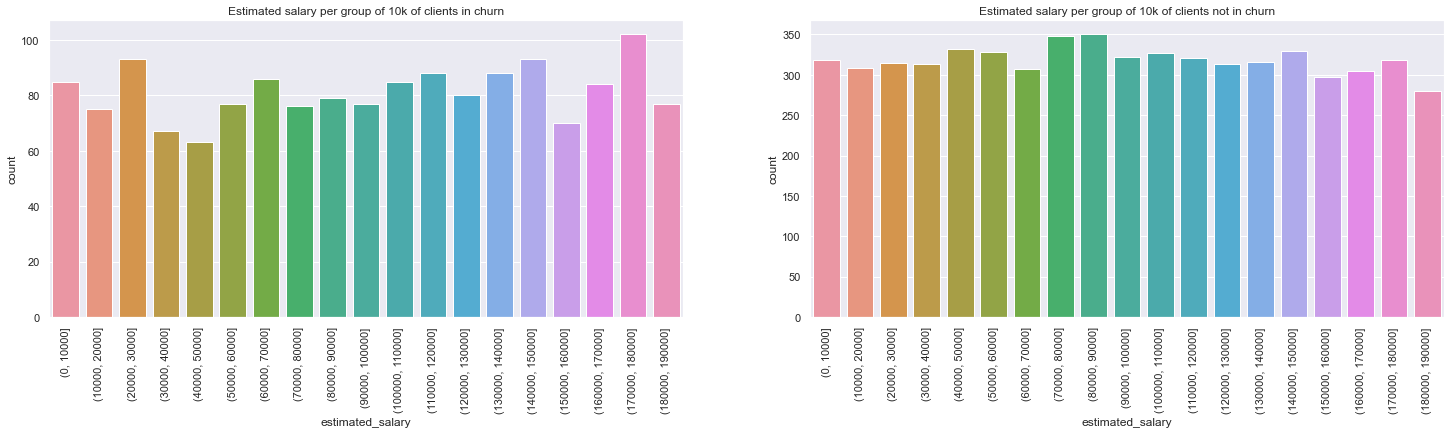

In [36]:
bins = list(np.arange(0, 200000, 10000))

aux03_churn = pd.cut(df04[df04['exited'] == 1]['estimated_salary'], bins=bins)
aux03_not_churn = pd.cut(df04[df04['exited'] == 0]['estimated_salary'], bins=bins)

plt.subplot(2,2,1)
sns.countplot(x=aux03_churn).set_title('Estimated salary per group of 10k of clients in churn');
plt.xticks(rotation=90);

plt.subplot(2,2,2)
sns.countplot(x=aux03_not_churn).set_title('Estimated salary per group of 10k of clients not in churn');
plt.xticks(rotation=90);

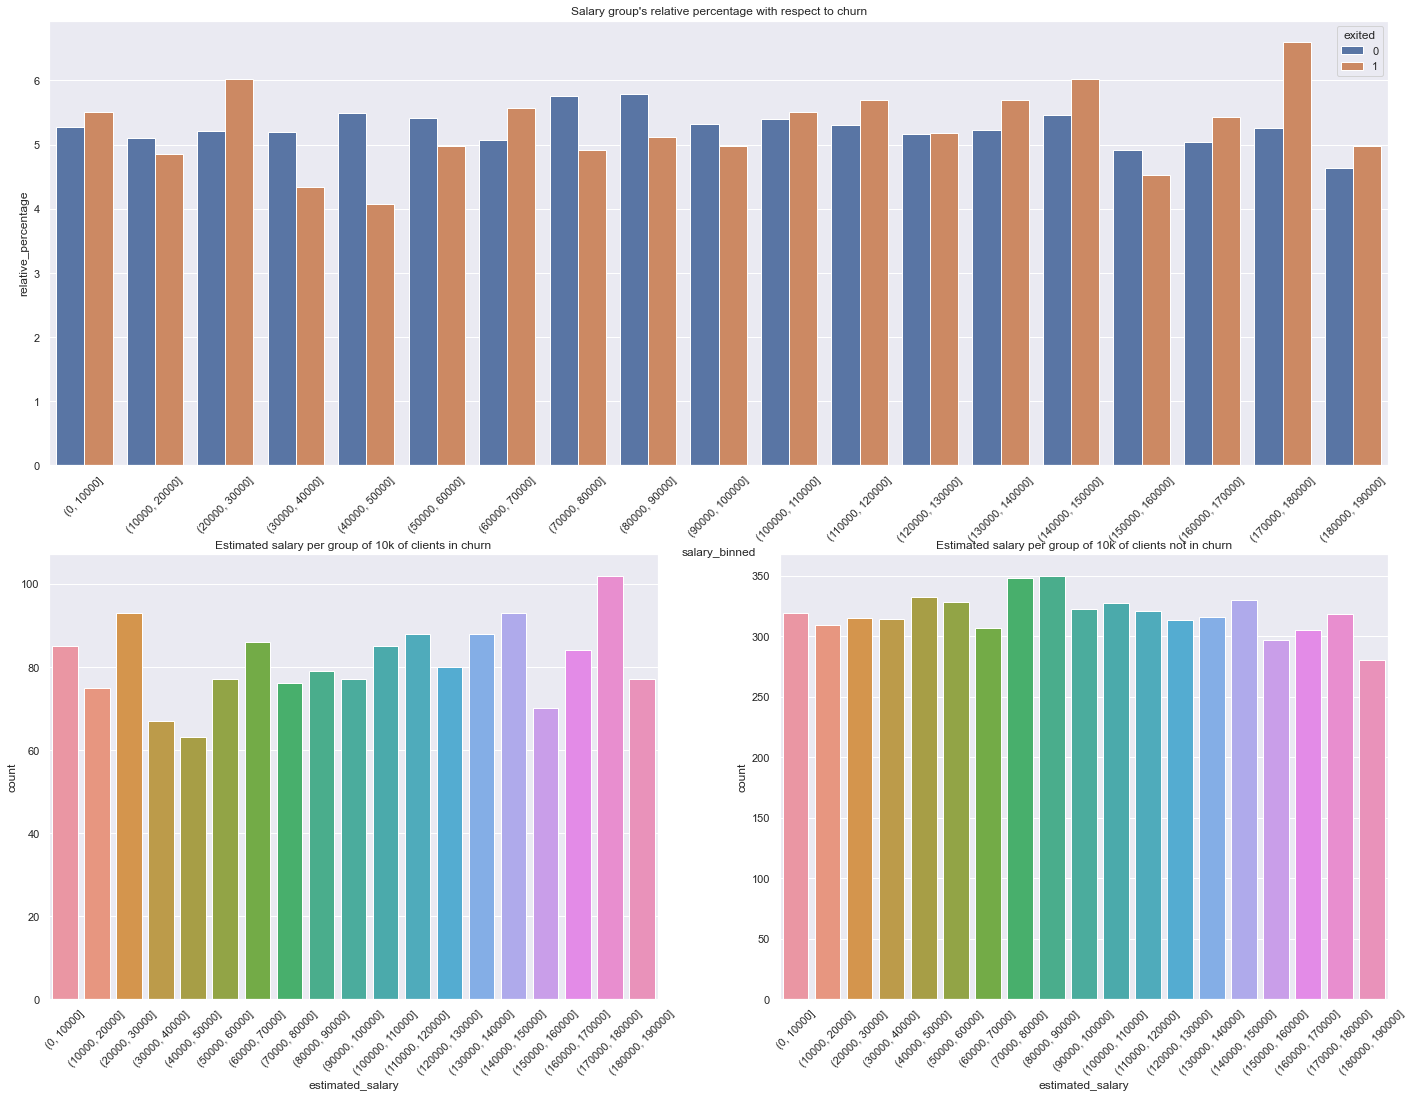

In [37]:
# bins
bins = list(np.arange(0, 200000, 10000))

# create new dataframe
aux03 = df04[['estimated_salary', 'exited']]
aux03['salary_binned'] = pd.cut(aux03['estimated_salary'], bins=bins)

# salary_binned, exited and number of clients
aux03 = aux03[['salary_binned', 'estimated_salary', 'exited']].groupby(['salary_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux03.columns = ['salary_binned', 'exited', 'customers']

# sum of clients in churn and not in churn
aux03_churn = aux03[aux03['exited'] == 1]['customers'].sum()
aux03_not_churn = aux03[aux03['exited'] == 0]['customers'].sum()

# calculate the relative percentage of clients in churn and active clients
aux03['relative_percentage'] = aux03.\
apply(lambda row: ((row['customers'] / aux03_churn)*100) if row['exited'] == 1 else ((row['customers'] / aux03_not_churn)*100), axis=1)


# Grid for ploting
plt.figure(figsize(24,18))
grid = GridSpec(2, 2)

# plot Salary group's relative percentage with respect to churn
plt.subplot(grid[0,:])
sns.barplot(x='salary_binned', y='relative_percentage', hue='exited', data=aux03).set_title("Salary group's relative percentage with respect to churn");
plt.xticks(rotation=45);

# New auxiliary analyses for plot
aux03_churn = pd.cut(df04[df04['exited'] == 1]['estimated_salary'], bins=bins)
aux03_not_churn = pd.cut(df04[df04['exited'] == 0]['estimated_salary'], bins=bins)

# plot Estimated salary per group of 10k of clients in churn
plt.subplot(grid[1,0])
sns.countplot(x=aux03_churn).set_title('Estimated salary per group of 10k of clients in churn');
plt.xticks(rotation=45);

# plot Estimated salary per group of 10k of clients not in churn
plt.subplot(grid[1,1])
sns.countplot(x=aux03_not_churn).set_title('Estimated salary per group of 10k of clients not in churn');
plt.xticks(rotation=45);

### H04 - Churn should occur for customers with high balance
---
> - Conclusion: **TRUE** 
>> Churn occur for customers with high balance

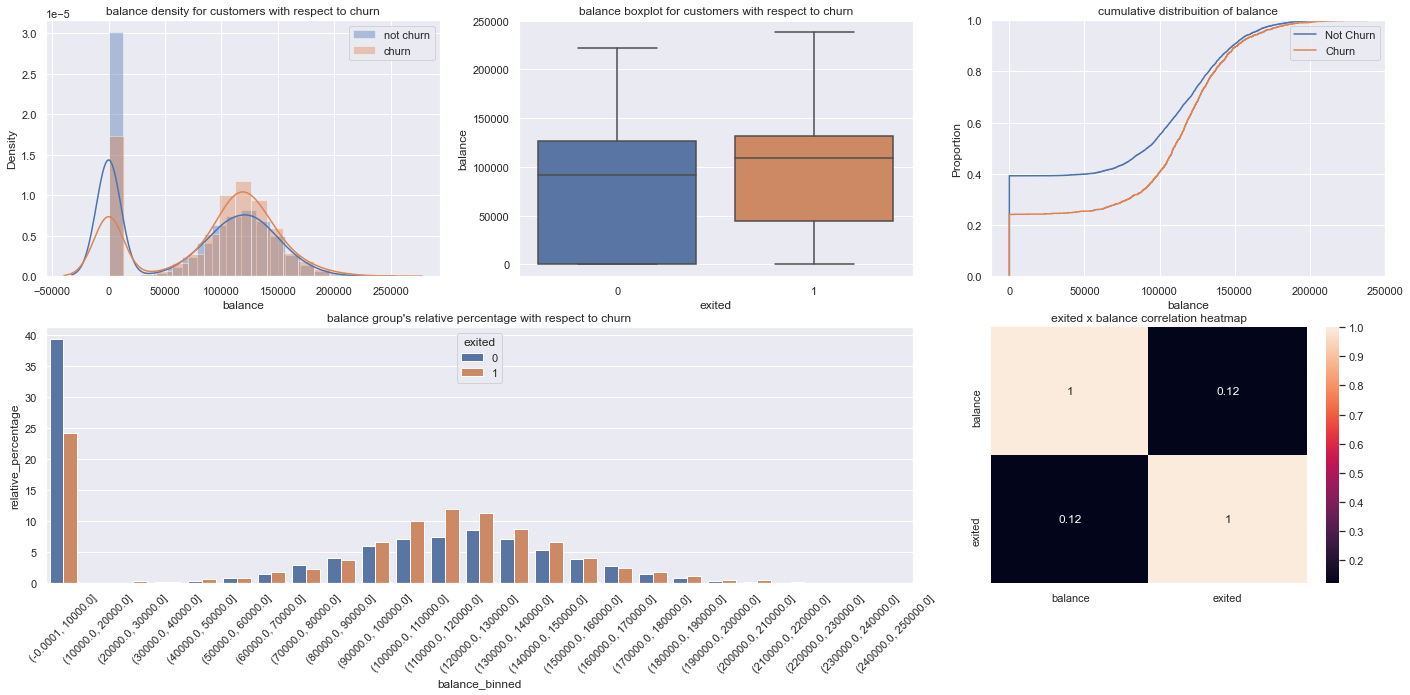

In [38]:
# bins
bins = list(np.arange(-0.0001, 250000, 10000))

# create new dataframe
aux04 = df04[['balance', 'exited']]

# Grid for ploting
plt.figure(figsize(24,16))
grid = GridSpec(3, 3)

# balance density
plt.subplot(grid[0,0])
sns.distplot(aux04[aux04['exited'] == 0]['balance'], label='not churn');
sns.distplot(aux04[aux04['exited'] == 1]['balance'], label='churn');
plt.title("balance density for customers with respect to churn");
plt.legend();

# balance boxplot
plt.subplot(grid[0,1])
sns.boxplot(x="exited", y="balance", data=aux04).set_title("balance boxplot for customers with respect to churn");

# ecdf balance
plt.subplot(grid[0,2])
sns.ecdfplot(data=aux04[aux04['exited'] == 0], x="balance", label='Not Churn');
sns.ecdfplot(data=aux04[aux04['exited'] == 1], x="balance", label='Churn');
plt.title("cumulative distribuition of balance")
plt.legend()


# exited x balance correlation heatmap
plt.subplot(grid[1,2])
sns.heatmap(aux04.corr(method='pearson'),annot=True);
plt.title("exited x balance correlation heatmap");

# create binned column
aux04['balance_binned'] = pd.cut(aux04['balance'], bins=bins)

# salary_binned, exited and number of clients
aux04 = aux04[['balance_binned', 'balance', 'exited']].groupby(['balance_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux04.columns = ['balance_binned', 'exited', 'customers']

# sum of clients in churn and not in churn
aux04_churn = aux04[aux04['exited'] == 1]['customers'].sum()
aux04_not_churn = aux04[aux04['exited'] == 0]['customers'].sum()

# calculate the relative percentage of clients in churn and active clients
aux04['relative_percentage'] = aux04.\
apply(lambda row: ((row['customers'] / aux04_churn)*100) if row['exited'] == 1 else ((row['customers'] / aux04_not_churn)*100), axis=1)


# plot Salary group's relative percentage with respect to churn
plt.subplot(grid[1,:2])
sns.barplot(x='balance_binned', y='relative_percentage', hue='exited', data=aux04).set_title("balance group's relative percentage with respect to churn");
plt.xticks(rotation=45);

### H05 - Countries of Latin origin have higher number of churn
---
> - Conclusion: **FALSE** 
>> Countries of **Anglo-Saxons** origin have higher number of churn

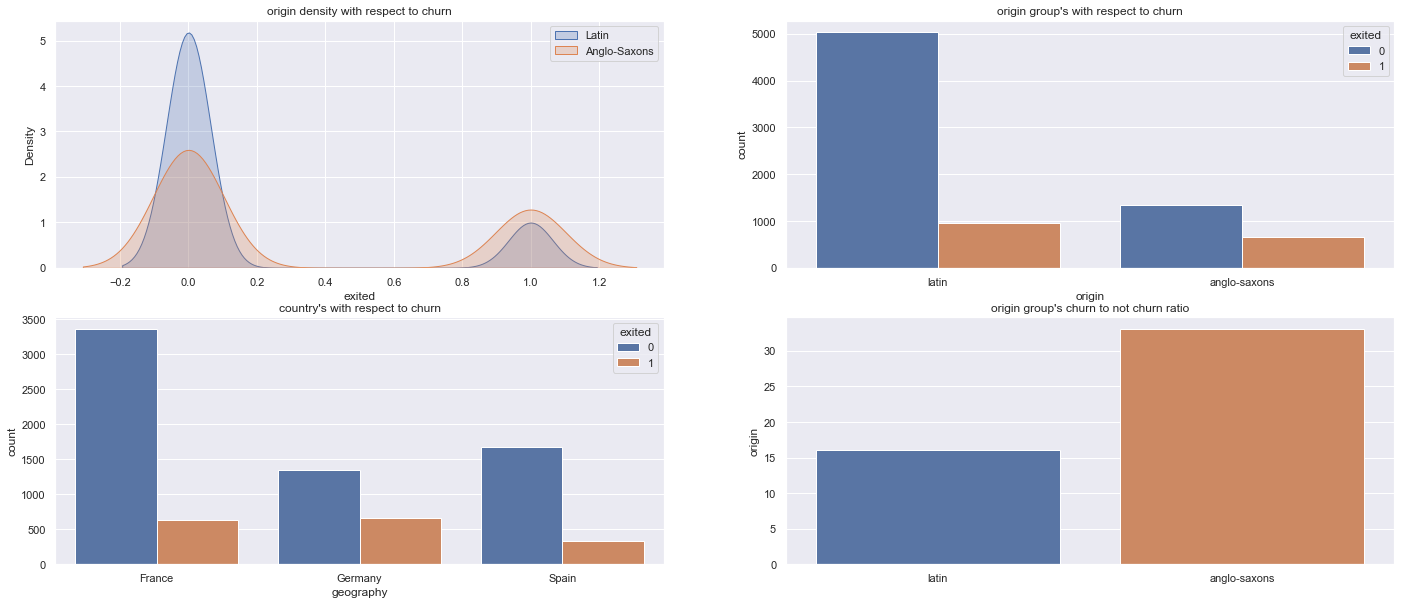

In [39]:
aux05 = df04[['origin', 'exited', 'geography']]

# figure size
plt.figure(figsize(24,10))

# origin density
plt.subplot(2,2,1)
sns.kdeplot(aux05[aux05['origin'] == 'latin']['exited'], label='Latin', shade=True);
sns.kdeplot(aux05[aux05['origin'] == 'anglo-saxons']['exited'], label='Anglo-Saxons', shade=True);
plt.title("origin density with respect to churn");
plt.legend();

# origin group's
plt.subplot(2,2,2)
sns.countplot(x='origin', hue='exited', data=aux05).set_title("origin group's with respect to churn");

# country's plot
plt.subplot(2,2,3)
sns.countplot(x='geography', hue='exited', data=aux05).set_title("country's with respect to churn");

# origin group's churn to not churn ratio
plt.subplot(2,2,4)
aux05_ratio_churn = aux05[aux05['exited']==1]['origin'].value_counts()\
/ (aux05[aux05['exited']==0]['origin'].value_counts() + aux05[aux05['exited']==1]['origin'].value_counts())*100
sns.barplot(x=aux05_ratio_churn.index, y=aux05_ratio_churn).\
set_title("origin group's churn to not churn ratio");

### H06 - Active members should have less churn
---
> - Conclusion: **TRUE**
>> Active members have less churn

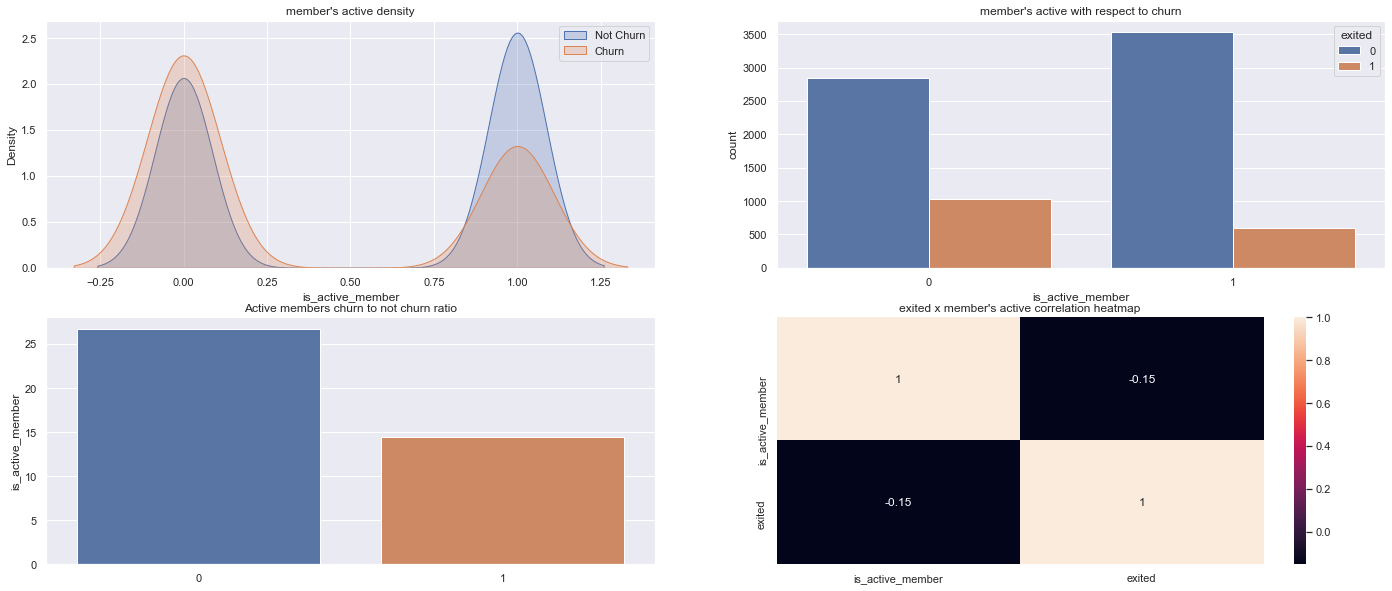

In [40]:
aux06 = df04[['is_active_member', 'exited']]

# figure size
plt.figure(figsize(24,10))

# member's active density
plt.subplot(2,2,1)
sns.kdeplot(aux06[aux06['exited'] == 0]['is_active_member'], label='Not Churn', shade=True);
sns.kdeplot(aux06[aux06['exited'] == 1]['is_active_member'], label='Churn', shade=True);
plt.title("member's active density")
plt.legend()

# member's active with respect to churn
plt.subplot(2,2,2)
sns.countplot(x='is_active_member', hue='exited', data=aux06).set_title("member's active with respect to churn");

# Active members churn to not churn ratio
plt.subplot(2,2,3)
aux06_ratio_churn = aux06[aux06['exited']==1]['is_active_member'].value_counts()\
                                            / (aux06[aux06['exited']==0]['is_active_member'].value_counts() + aux06[aux06['exited']==1]['is_active_member'].value_counts())*100
sns.barplot(x=aux06_ratio_churn.index, y=aux06_ratio_churn).\
set_title("Active members churn to not churn ratio");

# exited x member's active correlation heatmap
plt.subplot(2,2,4)
sns.heatmap(aux06.corr(method='pearson'),annot=True);
plt.title("exited x member's active correlation heatmap");

### H07 - Churn should occur for customers with low tenure
---
> - Conclusion: **FALSE** 
>> Churn occur for customers with high tenur

<Figure size 1728x576 with 0 Axes>

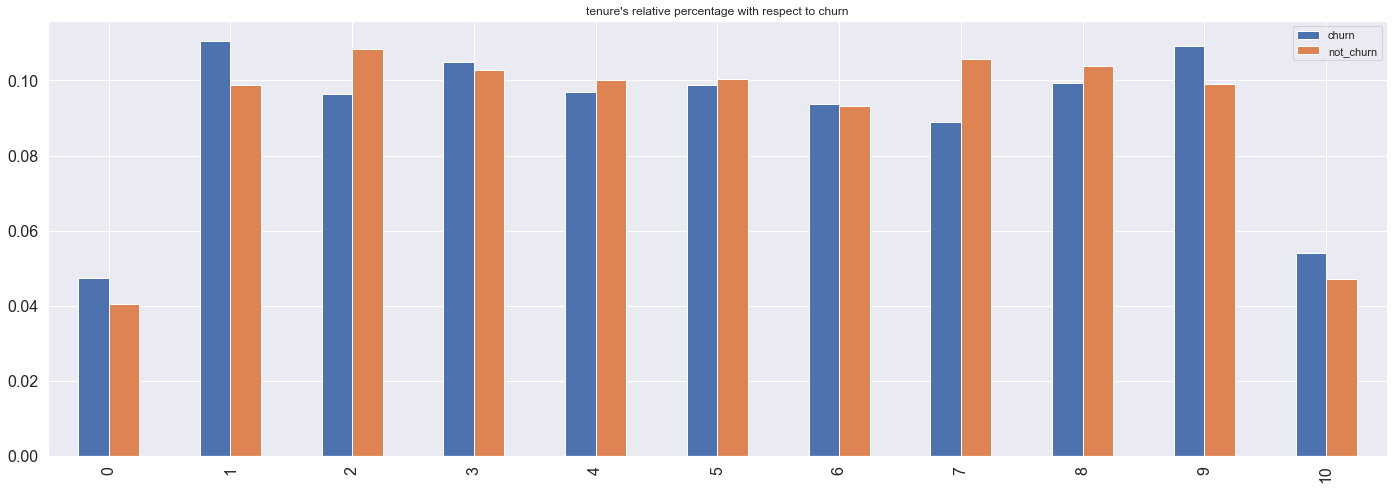

In [41]:
tenure_percentage = num_attributes['tenure'].value_counts(normalize=True).sort_index()
tenure_percentage_hue_churn = pd.DataFrame()
tenure_percentage_hue_churn['churn'] = num_attributes['tenure'][num_attributes['exited'] == 1].value_counts(normalize=True).sort_index()
tenure_percentage_hue_churn['not_churn'] = num_attributes['tenure'][num_attributes['exited'] != 1].value_counts(normalize=True).sort_index()

# figure size
plt.figure(figsize(24,8));

tenure_percentage_hue_churn.plot(kind='bar', stacked=False, fontsize=16);
plt.title("tenure's relative percentage with respect to churn");

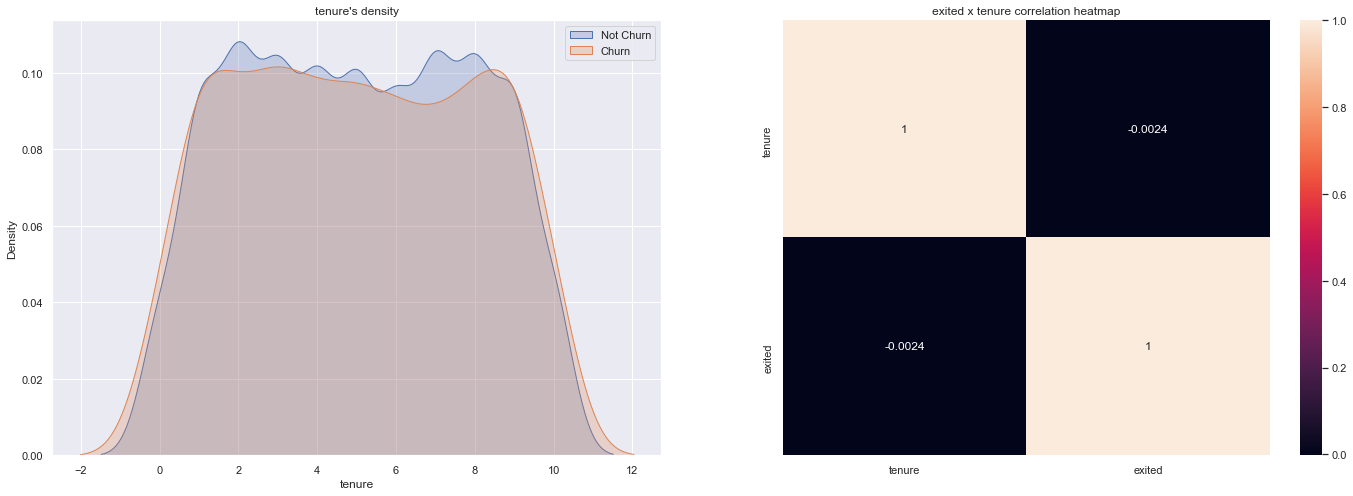

In [42]:
aux07 = df04[['tenure', 'exited']]

plt.subplot(1,2,1)
sns.kdeplot(aux07[aux07['exited'] == 0]['tenure'], label='Not Churn', shade=True);
sns.kdeplot(aux07[aux07['exited'] == 1]['tenure'], label='Churn', shade=True);
plt.title("tenure's density");
plt.legend();

plt.subplot(1,2,2)
sns.heatmap(aux07.corr(method='pearson'),annot=True);
plt.title("exited x tenure correlation heatmap");

### H08 - The more products the customer has, the less likely it is to go into churn
---
> - Conclusion: **FALSE** 
>> Customers with more than two products have a better chance of getting into churn

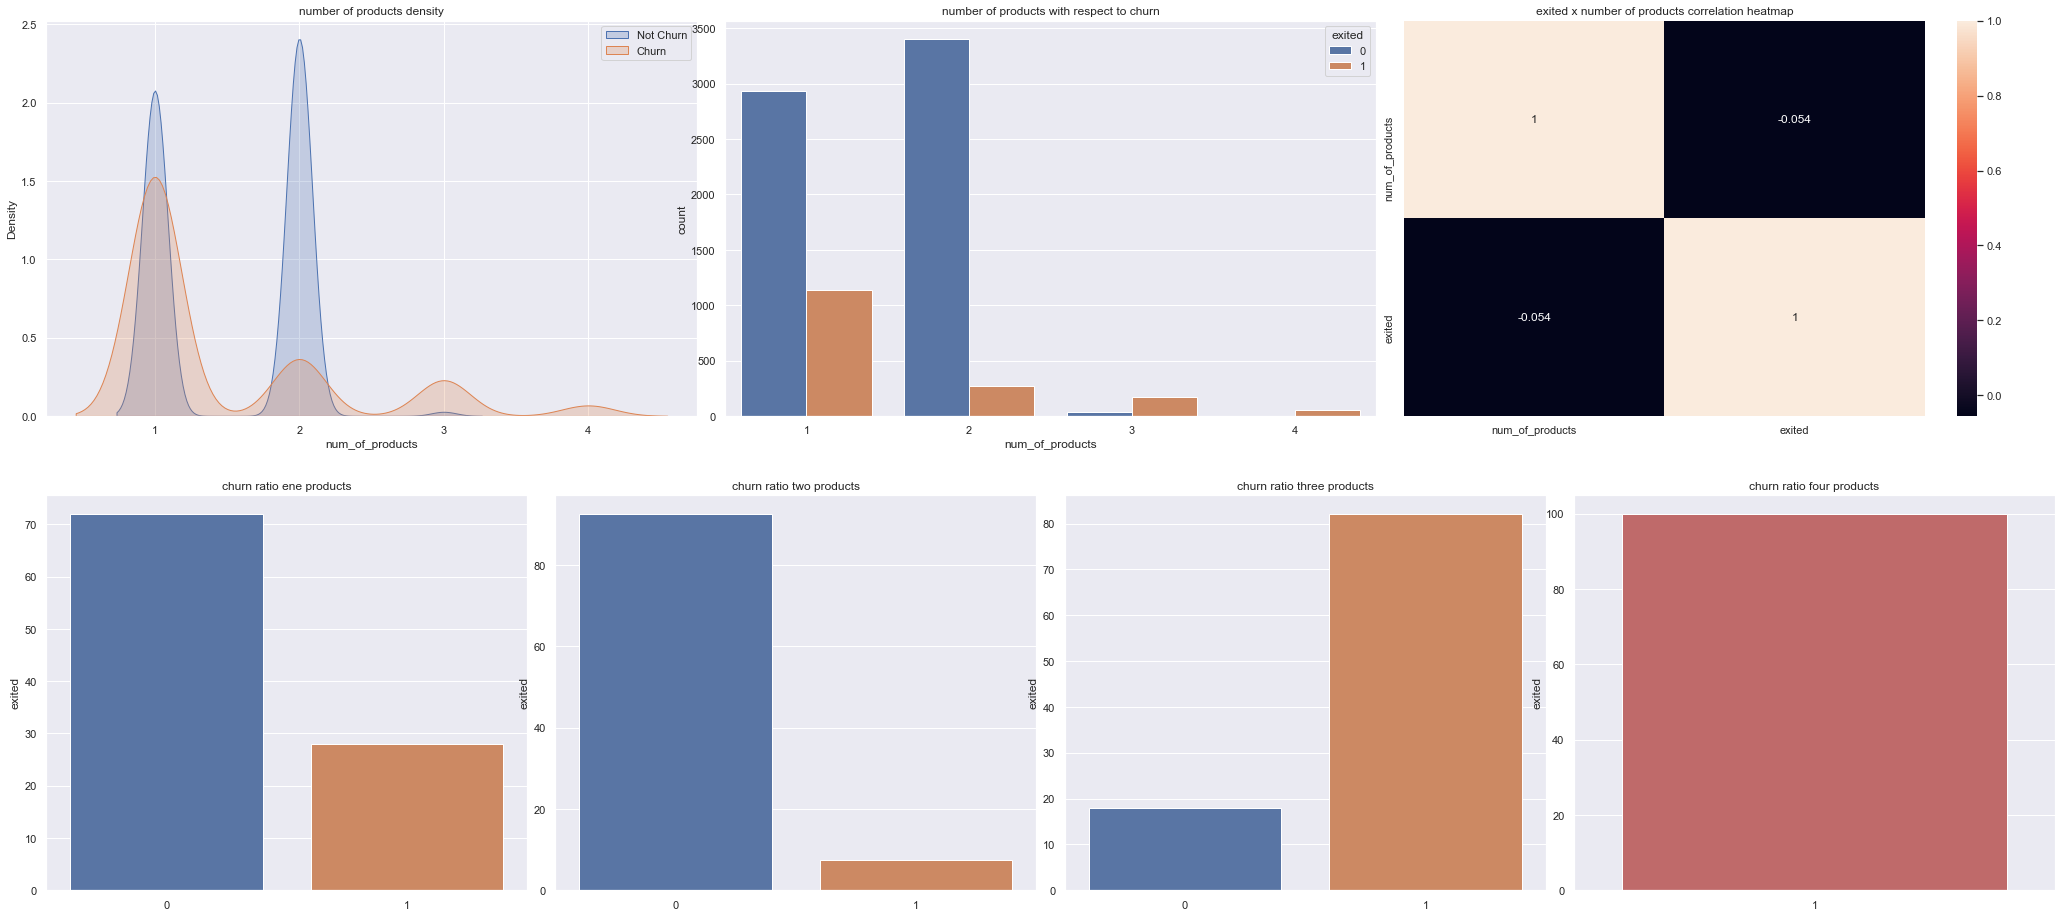

In [43]:
aux08 = df04[['num_of_products', 'exited']]

# Grid for ploting
plt.figure(figsize(36,16))
grid = GridSpec(2, 12)

# number of products density
plt.subplot(grid[0,:4])
sns.kdeplot(aux08[aux08['exited'] == 0]['num_of_products'], label='Not Churn', shade=True);
sns.kdeplot(aux08[aux08['exited'] == 1]['num_of_products'], label='Churn', shade=True);
plt.title("number of products density");
plt.legend();

# number of products with respect to churn
plt.subplot(grid[0,4:8])
sns.countplot(x='num_of_products', hue='exited', data=aux08).set_title("number of products with respect to churn");

# exited x number of products correlation heatmap
plt.subplot(grid[0,8:12])
sns.heatmap(aux08.corr(method='pearson'),annot=True);
plt.title("exited x number of products correlation heatmap");

# churn ratio {num_of_products} products
dict_num_of_products = {
                            1: 'ene',
                            2: 'two',
                            3: 'three',
                            4: 'four'
                        }

for i in dict_num_of_products.keys():
    churn_prod = aux08[aux08['num_of_products']==i]['exited'].value_counts(normalize=True)*100
    if churn_prod.iloc[0] != 100:
        plt.subplot(grid[1,(i-1)*3:i*3])
        sns.barplot(x=churn_prod.index, y=churn_prod).set_title('churn ratio {} products'.format(dict_num_of_products[i]));
    else:
        plt.subplot(grid[1,(i-1)*3:i*3])
        sns.barplot(x=churn_prod.index, color='indianred',  y=churn_prod).set_title('churn ratio {} products'.format(dict_num_of_products[i]));

### H09 - Customers with Credit Cards tend to stay at the bank
---
> - Conclusion: **TRUE** 
>> Customers who have a credit card have lower churn rate

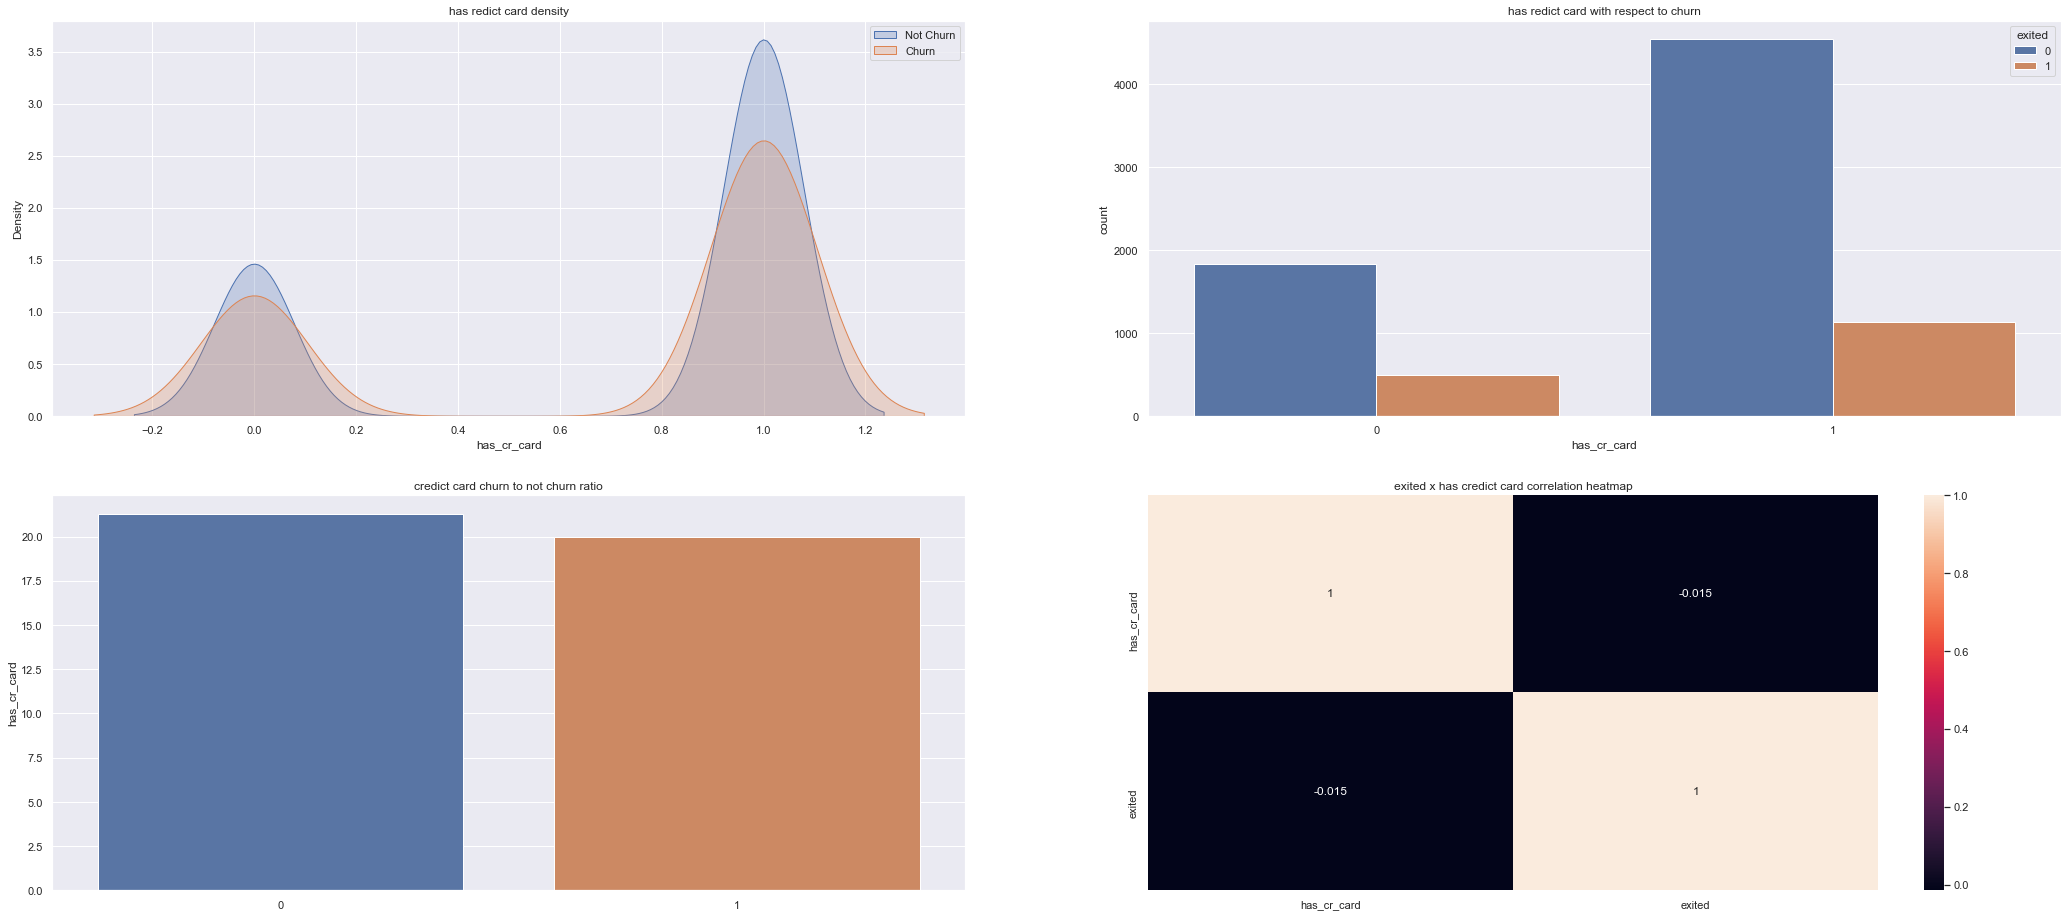

In [44]:
aux09 = df04[['has_cr_card', 'exited']]

# has redict card density
plt.subplot(2,2,1)
sns.kdeplot(aux09[aux09['exited'] == 0]['has_cr_card'], label='Not Churn', shade=True);
sns.kdeplot(aux09[aux09['exited'] == 1]['has_cr_card'], label='Churn', shade=True);
plt.title("has redict card density")
plt.legend()

# has redict card with respect to churn
plt.subplot(2,2,2)
sns.countplot(x='has_cr_card', hue='exited', data=aux09).set_title("has redict card with respect to churn");

# credict card churn to not churn ratio
plt.subplot(2,2,3)
aux09_ratio_churn = aux09[aux09['exited']==1]['has_cr_card'].value_counts()\
                                                / (aux09[aux09['exited']==0]['has_cr_card'].value_counts() + aux09[aux09['exited']==1]['has_cr_card'].value_counts())*100
sns.barplot(x=aux09_ratio_churn.index, y=aux09_ratio_churn).\
set_title("credict card churn to not churn ratio");

# exited x has credict card correlation heatmap
plt.subplot(2,2,4)
sns.heatmap(aux09.corr(method='pearson'),annot=True);
plt.title("exited x has credict card correlation heatmap");

## 4.4 Multivariate Analysis

### 4.4.1 Numerical and Boolean Attributes

In [45]:
# Numerical Attributes and Boolean
num_attributes = df04.select_dtypes(include=['int64', 'float64'])

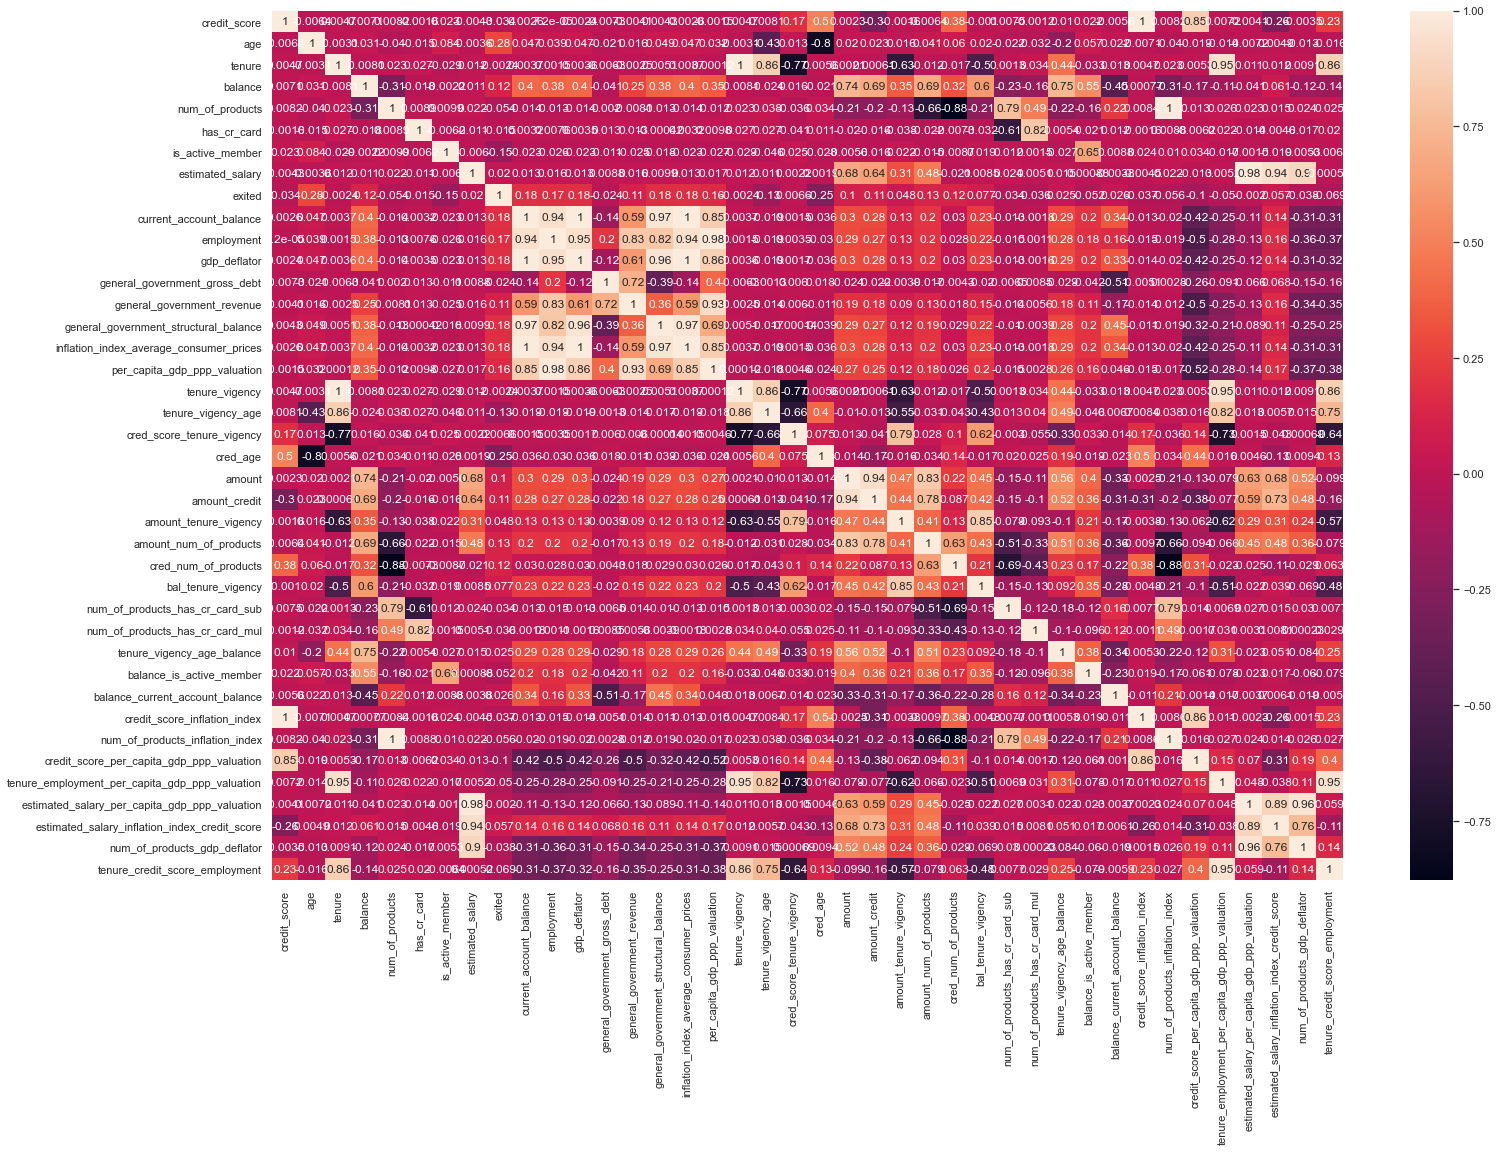

In [46]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize(24,16));
sns.heatmap(correlation, annot=True);

### 4.4.2 Categorical Attributes

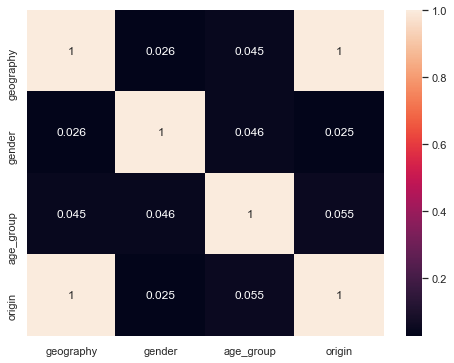

In [47]:
a1 = cramerV(cat_attributes['geography'], cat_attributes['geography'])
a2 = cramerV(cat_attributes['geography'], cat_attributes['gender'])
a3 = cramerV(cat_attributes['geography'], cat_attributes['age_group'])
a4 = cramerV(cat_attributes['geography'], cat_attributes['origin'])

a5 = cramerV(cat_attributes['gender'], cat_attributes['geography'])
a6 = cramerV(cat_attributes['gender'], cat_attributes['gender'])
a7 = cramerV(cat_attributes['gender'], cat_attributes['age_group'])
a8 = cramerV(cat_attributes['gender'], cat_attributes['origin'])

a9 = cramerV(cat_attributes['age_group'], cat_attributes['geography'])
a10 = cramerV(cat_attributes['age_group'], cat_attributes['gender'])
a11 = cramerV(cat_attributes['age_group'], cat_attributes['age_group'])
a12 = cramerV(cat_attributes['age_group'], cat_attributes['origin'])

a13 = cramerV(cat_attributes['origin'], cat_attributes['geography'])
a14 = cramerV(cat_attributes['origin'], cat_attributes['gender'])
a15 = cramerV(cat_attributes['origin'], cat_attributes['age_group'])
a16 = cramerV(cat_attributes['origin'], cat_attributes['origin'])

#Final Dataset
dict_cramerV = {
                'geography':[a1, a2, a3, a4],
                'gender':[a5, a6, a7, a8],
                'age_group':[a9, a10, a11, a12],
                'origin':[a13, a14, a15, a16]
                }

d = pd.DataFrame(dict_cramerV)

d = d.set_index(d.columns)

#HeatMap Plot
plt.figure(figsize=(8,6))
sns.heatmap(d, annot=True)
plt.show()

# 5.0 DATA PREPARATION

In [48]:
df05 = df04.copy()

## 5.1 Transformation

### 5.1.1 ~~Normalization~~

### 5.1.2 Rescaling

#### 5.1.2.1 RobustScaler

In [49]:
rs = RobustScaler()

# balance
df05['balance'] = rs.fit_transform(df05[['balance']].values)
jb.dump(rs,'parameter/balance_scaler.pkl.z')

# tenure_vigency_age_balance
df05['tenure_vigency_age_balance'] = rs.fit_transform(df05[['tenure_vigency_age_balance']].values)
jb.dump(rs,'parameter/tenure_vigency_age_balance.pkl.z')

# balance_is_active_member
df05['balance_is_active_member'] = rs.fit_transform(df05[['balance_is_active_member']].values)
jb.dump(rs,'parameter/balance_is_active_member.pkl.z')

# balance_current_account_balance
df05['balance_current_account_balance'] = rs.fit_transform(df05[['balance_current_account_balance']].values)
jb.dump(rs,'parameter/balance_current_account_balance.pkl.z')

# amount_credit
df05['amount_credit'] = rs.fit_transform(df05[['amount_credit']].values)
jb.dump(rs,'parameter/amount_credit.pkl.z')

['parameter/amount_credit.pkl.z']

#### 5.1.2.2 MinMaxScaler

In [50]:
mms = MinMaxScaler()

# cred_age
df05['cred_age'] = mms.fit_transform(df05[['cred_age']].values)
jb.dump(rs,'parameter/cred_age.pkl.z')

# # credit_score
# df05['credit_score'] = mms.fit_transform(df05[['credit_score']].values)
# jb.dump(rs,'parameter/credit_score.pkl.z')

# age
df05['age'] = mms.fit_transform(df05[['age']].values)
jb.dump(rs,'parameter/age.pkl.z')

# tenure
df05['tenure'] = mms.fit_transform(df05[['tenure']].values)
jb.dump(rs,'parameter/tenure.pkl.z')

# num_of_products
# df05['num_of_products'] = mms.fit_transform(df05[['num_of_products']].values)
# jb.dump(rs,'parameter/num_of_products.pkl.z')

# estimated_salary
df05['estimated_salary'] = mms.fit_transform(df05[['estimated_salary']].values)
jb.dump(rs,'parameter/estimated_salary.pkl.z')

# current_account_balance
df05['current_account_balance'] = mms.fit_transform(df05[['current_account_balance']].values)
jb.dump(rs,'parameter/current_account_balance.pkl.z')

# employment
df05['employment'] = mms.fit_transform(df05[['employment']].values)
jb.dump(rs,'parameter/employment.pkl.z')

# gdp_deflator
df05['gdp_deflator'] = mms.fit_transform(df05[['gdp_deflator']].values)
jb.dump(rs,'parameter/gdp_deflator.pkl.z')

# general_government_gross_debt
df05['general_government_gross_debt'] = mms.fit_transform(df05[['general_government_gross_debt']].values)
jb.dump(rs,'parameter/general_government_gross_debt.pkl.z')

# general_government_structural_balance
df05['general_government_structural_balance'] = mms.fit_transform(df05[['general_government_structural_balance']].values)
jb.dump(rs,'parameter/general_government_structural_balance.pkl.z')

# inflation_index_average_consumer_prices
df05['inflation_index_average_consumer_prices'] = mms.fit_transform(df05[['inflation_index_average_consumer_prices']].values)
jb.dump(rs,'parameter/inflation_index_average_consumer_prices.pkl.z')

# per_capita_gdp_ppp_valuation
df05['per_capita_gdp_ppp_valuation'] = mms.fit_transform(df05[['per_capita_gdp_ppp_valuation']].values)
jb.dump(rs,'parameter/per_capita_gdp_ppp_valuation.pkl.z')

# tenure_vigency_age
df05['tenure_vigency_age'] = mms.fit_transform(df05[['tenure_vigency_age']].values)
jb.dump(rs,'parameter/tenure_vigency_age.pkl.z')

# cred_score_tenure_vigency
df05['cred_score_tenure_vigency'] = mms.fit_transform(df05[['cred_score_tenure_vigency']].values)
jb.dump(rs,'parameter/cred_score_tenure_vigency.pkl.z')

# amount
df05['amount'] = mms.fit_transform(df05[['amount']].values)
jb.dump(rs,'parameter/amount.pkl.z')

# # amount_credit
# df05['amount_credit'] = mms.fit_transform(df05[['amount_credit']].values)
# jb.dump(rs,'parameter/amount_credit.pkl.z')

# amount_num_of_products
df05['amount_num_of_products'] = mms.fit_transform(df05[['amount_num_of_products']].values)
jb.dump(rs,'parameter/amount_num_of_products.pkl.z')

# cred_num_of_products
df05['cred_num_of_products'] = mms.fit_transform(df05[['cred_num_of_products']].values)
jb.dump(rs,'parameter/cred_num_of_products.pkl.z')

# num_of_products_has_cr_card_sub
df05['num_of_products_has_cr_card_sub'] = mms.fit_transform(df05[['num_of_products_has_cr_card_sub']].values)
jb.dump(rs,'parameter/num_of_products_has_cr_card_sub.pkl.z')

# num_of_products_has_cr_card_mul
df05['num_of_products_has_cr_card_mul'] = mms.fit_transform(df05[['num_of_products_has_cr_card_mul']].values)
jb.dump(rs,'parameter/num_of_products_has_cr_card_mul.pkl.z')

# credit_score_inflation_index
df05['credit_score_inflation_index'] = mms.fit_transform(df05[['credit_score_inflation_index']].values)
jb.dump(rs,'parameter/credit_score_inflation_index.pkl.z')

# tenure_employment_per_capita_gdp_ppp_valuation
df05['tenure_employment_per_capita_gdp_ppp_valuation'] = mms.fit_transform(df05[['tenure_employment_per_capita_gdp_ppp_valuation']].values)
jb.dump(rs,'parameter/tenure_employment_per_capita_gdp_ppp_valuation.pkl.z')

# estimated_salary_per_capita_gdp_ppp_valuation
df05['estimated_salary_per_capita_gdp_ppp_valuation'] = mms.fit_transform(df05[['estimated_salary_per_capita_gdp_ppp_valuation']].values)
jb.dump(rs,'parameter/estimated_salary_per_capita_gdp_ppp_valuation.pkl.z')

# num_of_products_gdp_deflator
df05['num_of_products_gdp_deflator'] = mms.fit_transform(df05[['num_of_products_gdp_deflator']].values)
jb.dump(rs,'parameter/num_of_products_gdp_deflator.pkl.z')

# tenure_credit_score_employment
df05['tenure_credit_score_employment'] = mms.fit_transform(df05[['tenure_credit_score_employment']].values)
jb.dump(rs,'parameter/tenure_credit_score_employment.pkl.z')

['parameter/tenure_credit_score_employment.pkl.z']

#### 5.1.2.1 StandardScaler

In [51]:
ss = StandardScaler()

# # cred_age
# df05['cred_age'] = ss.fit_transform(df05[['cred_age']].values)
# jb.dump(rs,'parameter/cred_age.pkl.z')

# bal_tenure_vigency
df05['bal_tenure_vigency'] = ss.fit_transform(df05[['bal_tenure_vigency']].values)
jb.dump(rs,'parameter/bal_tenure_vigency.pkl.z')

# credit_score_per_capita_gdp_ppp_valuation
df05['credit_score_per_capita_gdp_ppp_valuation'] = ss.fit_transform(df05[['credit_score_per_capita_gdp_ppp_valuation']].values)
jb.dump(rs,'parameter/credit_score_per_capita_gdp_ppp_valuation.pkl.z')

# credit_score
df05['credit_score'] = ss.fit_transform(df05[['credit_score']].values)
jb.dump(rs,'parameter/credit_score.pkl.z')

['parameter/credit_score.pkl.z']

### 5.1.3 Encoding

In [52]:
#AgeGroup -> One Hot Encoding
df05 = pd.get_dummies(df05, prefix=['age_group'], columns=['age_group'], drop_first=True)

#Geography -> One Hot Encoding
df05 = pd.get_dummies(df05, prefix=['geography'], columns=['geography'], drop_first=True)

# Gender
df05['gender'] = np.where(df05['gender'] == 'Female', 1, 0)

# origin
df05['origin'] = np.where(df05['origin'] == 'Latin', 1, 0)

# 6.0 FEATURE SELECTION

In [53]:
df06 = df05.copy()

## 6.1 Split dataframe into training and test dataset

In [54]:
X = df06.drop(columns=['exited'], axis=1)
y = df06['exited']


# Training and Validation dataset for Boruta
X_train_n = X.to_numpy()
y_train_n = y.values.ravel()

# define RandomForestRegressor
rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000)

# define Boruta
boruta = BorutaPy(rf, verbose=0, random_state=42)
boruta.fit(X_train_n, y_train_n)

BorutaPy(estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1D08DD79540),
         random_state=RandomState(MT19937) at 0x1D08DD79540)

## 6.2 Boruta as Feature Selector

In [55]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['age',
 'balance',
 'num_of_products',
 'cred_age',
 'amount_credit',
 'amount_num_of_products',
 'cred_num_of_products',
 'num_of_products_has_cr_card_mul',
 'balance_current_account_balance',
 'num_of_products_inflation_index',
 'age_group_Midlife']

In [56]:
cols_selected = [
                    'age',
                    'balance',
                    'num_of_products',
                    'cred_age',
                    'amount_credit',
                    'amount_num_of_products',
                    'cred_num_of_products',
                    'num_of_products_has_cr_card_mul',
                    'balance_current_account_balance',
                    'num_of_products_inflation_index',
                    'age_group_Midlife']

# 7.0 MACHINE LEARNING MODELLING FIRST LEVEL OF STACKING

## 7.1 Split train and Valid for the first level of the Stacking

In [57]:
X = X[cols_selected]
y = y

X_train, X_valid_train, y_train, y_valid_train = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)


df_train = pd.concat([X_train, y_train], axis=1)

## 7.2 Resample the train dataset for the first level of the Stacking

In [58]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

In [59]:
print('Before SMOTE: ', Counter(y_train))
print('After SMOTE: ', Counter(y_train_smote))

Before SMOTE:  Counter({0: 3185, 1: 815})
After SMOTE:  Counter({0: 3185, 1: 3185})


## 7.3 Models

### 7.3.1 Logistic Regression

#### 7.3.1.1 Without Cross Validation without SMOTE

In [60]:
#Model
model_name = 'Logistic Regression'
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Prediction
yhat_lr = model_lr.predict(X_valid_train)

# Prediction Proba
yhat_proba_lr = model_lr.predict_proba(X_valid_train)[:,1]

model_lr_result = ml_scores(model_name, y_valid_train, yhat_lr, yhat_proba_lr)
model_lr_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,Logistic Regression,0.625,0.269939,0.377035,0.289734,0.614247,0.517496,0.785144


#### 7.3.1.2 Without Cross Validation with SMOTE

In [61]:
#Model
model_name = 'Logistic Regression'
model_lr = LogisticRegression()
model_lr.fit(X_train_smote, y_train_smote)

# Prediction
yhat_lr = model_lr.predict(X_valid_train)

# Prediction Proba
yhat_proba_lr = model_lr.predict_proba(X_valid_train)[:,1]

model_lr_result = ml_scores(model_name, y_valid_train, yhat_lr, yhat_proba_lr)
model_lr_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,Logistic Regression,0.398577,0.687117,0.504505,0.332307,0.710905,0.526667,0.790389


#### 7.3.1.3 With Cross Validation without SMOTE

In [62]:
# Model
model_lr = LogisticRegression()
# Performance
model_lr_result_cv = cross_validation(df_train, 5, 'Logistic Regression', model_lr, verbose=False)
model_lr_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Logistic Regression,0.6266 +/- 0.0693,0.2873 +/- 0.0138,0.392 +/- 0.0106,0.3013 +/- 0.0187,0.6206 +/- 0.0049,0.5007 +/- 0.04,0.7744 +/- 0.0136


#### 7.3.1.4 With Cross Validation with SMOTE

In [63]:
# Model
model_lr = LogisticRegression()
# Performance
model_lr_result_cv = cross_validation(df_train, 5, 'Logistic Regression', model_lr, resample=True, verbose=False)
model_lr_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Logistic Regression,0.4013 +/- 0.0197,0.6948 +/- 0.0584,0.5083 +/- 0.0287,0.336 +/- 0.0349,0.7138 +/- 0.0253,0.5096 +/- 0.0527,0.7893 +/- 0.0227


### 7.3.2 Lightgbm Classifier

#### 7.3.2.1 Without Cross Validation without SMOTE

In [64]:
#Model
model_name = 'Lightgbm Classifier'
model_lgbm = LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced')
model_lgbm.fit(X_train, y_train)

# Prediction
yhat_lgbm = model_lgbm.predict(X_valid_train)

# Prediction Proba
yhat_proba_lgbm = model_lgbm.predict_proba(X_valid_train)[:,1]

model_lgbm_result = ml_scores(model_name, y_valid_train, yhat_lgbm, yhat_proba_lgbm)
model_lgbm_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,Lightgbm Classifier,0.519268,0.66135,0.581759,0.458048,0.752339,0.642686,0.835122


#### 7.3.2.2 Without Cross Validation with SMOTE

In [65]:
#Model
model_name = 'Lightgbm Classifier'
model_lgbm = LGBMClassifier(n_jobs=-1, random_state=42)
model_lgbm.fit(X_train_smote, y_train_smote)

# Prediction
yhat_lgbm = model_lgbm.predict(X_valid_train)

# Prediction Proba
yhat_proba_lgbm = model_lgbm.predict_proba(X_valid_train)[:,1]

model_lgbm_result = ml_scores(model_name, y_valid_train, yhat_lgbm, yhat_proba_lgbm)
model_lgbm_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,Lightgbm Classifier,0.604326,0.582822,0.593379,0.491686,0.742588,0.638293,0.833348


#### 7.3.2.3 With Cross Validation without SMOTE

In [66]:
# Model
model_lgbm = LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced')
# Performance
model_lgbm_result_cv = cross_validation(df_train, 5, 'Lightgbm Classifier', model_lgbm, verbose=False)
model_lgbm_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Lightgbm Classifier,0.5347 +/- 0.04,0.5359 +/- 0.0548,0.533 +/- 0.0347,0.4098 +/- 0.0373,0.7057 +/- 0.0213,0.5809 +/- 0.0608,0.8 +/- 0.022


#### 7.3.2.4 With Cross Validation with SMOTE

In [67]:
# Model
model_lgbm = LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced')
# Performance
model_lgbm_result_cv = cross_validation(df_train, 5, 'Lightgbm Classifier', model_lgbm, resample=True, verbose=False)
model_lgbm_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Lightgbm Classifier,0.5301 +/- 0.0322,0.5105 +/- 0.0512,0.5199 +/- 0.0419,0.4011 +/- 0.0497,0.698 +/- 0.027,0.5697 +/- 0.0458,0.797 +/- 0.016


### 7.3.3 Random Forest Classifier

#### 7.3.3.1 Without Cross Validation without SMOTE

In [68]:
#Model
model_name = 'Random Forest Classifier'
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced')
model_rf.fit(X_train, y_train)

# Prediction
yhat_rf = model_rf.predict(X_valid_train)

# Prediction Proba
yhat_proba_rf = model_rf.predict_proba(X_valid_train)[:,1]

model_rf_result = ml_scores(model_name, y_valid_train, yhat_rf, yhat_proba_rf)
model_rf_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,Random Forest Classifier,0.699797,0.423313,0.527523,0.441786,0.688423,0.633027,0.831037


#### 7.3.3.2 Without Cross Validation with SMOTE

In [69]:
#Model
model_name = 'Random Forest Classifier'
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42)
model_rf.fit(X_train_smote, y_train_smote)

# Prediction
yhat_rf = model_rf.predict(X_valid_train)

# Prediction Proba
yhat_proba_rf = model_rf.predict_proba(X_valid_train)[:,1]

model_rf_result = ml_scores(model_name, y_valid_train, yhat_rf, yhat_proba_rf)
model_rf_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,Random Forest Classifier,0.570738,0.579141,0.574909,0.465133,0.733841,0.610109,0.82878


#### 7.3.3.3 With Cross Validation without SMOTE

In [70]:
# Model
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced')
# Performance
model_rf_result_cv = cross_validation(df_train, 5, 'Random Forest Classifier', model_rf, verbose=False)
model_rf_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Random Forest Classifier,0.6666 +/- 0.0424,0.4094 +/- 0.0269,0.5067 +/- 0.0289,0.4188 +/- 0.0314,0.6792 +/- 0.0142,0.5695 +/- 0.0359,0.8134 +/- 0.0162


#### 7.3.3.4 With Cross Validation with SMOTE

In [71]:
# Model
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced')
# Performance
model_rf_result_cv = cross_validation(df_train, 5, 'Random Forest Classifier', model_rf, resample=True, verbose=False)
model_rf_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Random Forest Classifier,0.5424 +/- 0.0246,0.5565 +/- 0.0668,0.5471 +/- 0.0364,0.4299 +/- 0.0417,0.718 +/- 0.0292,0.5636 +/- 0.0303,0.8079 +/- 0.0185


## 7.3.4 XGBoost Classifier

#### 7.3.4.1 Without Cross Validation without SMOTE

In [72]:
#Model
model_name = 'XGBoost Classifier'
model_xgb = XGBClassifier(n_jobs=-1, random_state=42)
model_xgb.fit(X_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(X_valid_train)

# Prediction Proba
yhat_proba_xgb = model_xgb.predict_proba(X_valid_train)[:,1]

model_xgb_result = ml_scores(model_name, y_valid_train, yhat_xgb, yhat_proba_xgb)
model_xgb_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBoost Classifier,0.647569,0.457669,0.536305,0.442177,0.696966,0.606068,0.819654


#### 7.3.4.2 Without Cross Validation with SMOTE

In [73]:
#Model
model_name = 'XGBoost Classifier'
model_xgb = XGBClassifier(n_jobs=-1, random_state=42)
model_xgb.fit(X_train_smote, y_train_smote)

# Prediction
yhat_xgb = model_xgb.predict(X_valid_train)

# Prediction Proba
yhat_proba_xgb = model_xgb.predict_proba(X_valid_train)[:,1]

model_xgb_result = ml_scores(model_name, y_valid_train, yhat_xgb, yhat_proba_xgb)
model_xgb_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBoost Classifier,0.59383,0.566871,0.580038,0.475691,0.733828,0.617132,0.825269


#### 7.3.4.3 With Cross Validation without SMOTE

In [74]:
# Model
model_xgb = XGBClassifier(n_jobs=-1, random_state=42)
# Performance
model_xgb_result_cv = cross_validation(df_train, 5, 'XGBoost Classifier', model_xgb, verbose=False)
model_xgb_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBoost Classifier,0.574 +/- 0.0815,0.4013 +/- 0.0513,0.4721 +/- 0.0623,0.3685 +/- 0.0675,0.6635 +/- 0.0296,0.5341 +/- 0.0797,0.7914 +/- 0.0368


#### 7.3.4.4 With Cross Validation with SMOTE

In [75]:
# Model
model_xgb = XGBClassifier(n_jobs=-1, random_state=42)
# Performance
model_xgb_result_cv = cross_validation(df_train, 5, 'XGBoost Classifier', model_xgb, resample=True, verbose=False)
model_xgb_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBoost Classifier,0.5259 +/- 0.074,0.5041 +/- 0.0587,0.5121 +/- 0.0545,0.394 +/- 0.0669,0.6946 +/- 0.0325,0.5548 +/- 0.0641,0.7962 +/- 0.0256


# 8.0 HYPERPARAMETER FINE TUNING FIRST LEVEL OF STACKING

## 8.1 MODELS
---
- Lightgbm Classifier
- Random Forest Classifier
- XGBoost Classifier

## 8.2 DataFrame with results Declare

In [76]:
df_results = pd.DataFrame()

## 8.3 Lightgbm Classifier

### 8.3.1 Precision without SMOTE

In [77]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors


result_lgbm = control_model_tune(df_train, 'Lightgbm', 5, space, 'Precision', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.1410
Function value obtained: -0.5226
Current minimum: -0.5226
Iteration No: 2 started. Evaluating function at random point.
[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]
[LightGBM] [Warning] bagging_freq is set=1, subsamp

In [78]:
result_lgbm.x

[0.07486580971619969, 10, 1, 0.18428087097824575, 0.3261556557915816, 274]

In [79]:
df_results[(df_results['Model Name'] == 'Lightgbm Classifier') & (df_results['Metric'] == 'Precision') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,Precision,False,0.4765 +/- 0.0402,0.694 +/- 0.0381,0.5639 +/- 0.0343,0.4211 +/- 0.0397,0.7462 +/- 0.0195,0.5979 +/- 0.0514,0.8216 +/- 0.0181,"[{'lr': 0.003859705757436628, 'max_depth': 2, ..."
0,Lightgbm Classifier,Precision,False,0.5393 +/- 0.0356,0.6176 +/- 0.0393,0.5744 +/- 0.0245,0.4554 +/- 0.0296,0.7407 +/- 0.018,0.6056 +/- 0.0172,0.8271 +/- 0.0177,"[{'lr': 0.0066328042405379645, 'max_depth': 8,..."
0,Lightgbm Classifier,Precision,False,0.5451 +/- 0.0461,0.5489 +/- 0.0279,0.5465 +/- 0.0345,0.4297 +/- 0.0447,0.7156 +/- 0.0205,0.5748 +/- 0.0198,0.8026 +/- 0.0106,"[{'lr': 0.061810855225848234, 'max_depth': 9, ..."
0,Lightgbm Classifier,Precision,False,0.4888 +/- 0.0398,0.6663 +/- 0.0536,0.5634 +/- 0.043,0.432 +/- 0.0525,0.7455 +/- 0.0293,0.6054 +/- 0.0514,0.8273 +/- 0.0264,"[{'lr': 0.015665337619230394, 'max_depth': 4, ..."
0,Lightgbm Classifier,Precision,False,0.4943 +/- 0.0473,0.6539 +/- 0.0421,0.5624 +/- 0.0426,0.429 +/- 0.055,0.7402 +/- 0.0267,0.6001 +/- 0.0456,0.8307 +/- 0.0181,"[{'lr': 0.0022449729419144397, 'max_depth': 4,..."
0,Lightgbm Classifier,Precision,False,0.4268 +/- 0.0239,0.666 +/- 0.0125,0.52 +/- 0.0209,0.3601 +/- 0.0273,0.7175 +/- 0.013,0.5604 +/- 0.0541,0.8004 +/- 0.0216,"[{'lr': 0.0021108116772730425, 'max_depth': 2,..."
0,Lightgbm Classifier,Precision,False,0.5525 +/- 0.0173,0.5266 +/- 0.0531,0.5377 +/- 0.0295,0.4241 +/- 0.0353,0.7091 +/- 0.0238,0.5627 +/- 0.0372,0.8037 +/- 0.0174,"[{'lr': 0.02151017641719756, 'max_depth': 8, '..."
0,Lightgbm Classifier,Precision,False,0.4975 +/- 0.0336,0.6471 +/- 0.0352,0.5608 +/- 0.0156,0.4309 +/- 0.0225,0.7403 +/- 0.0134,0.5969 +/- 0.0227,0.8212 +/- 0.0196,"[{'lr': 0.004203255075983761, 'max_depth': 7, ..."
0,Lightgbm Classifier,Precision,False,0.5835 +/- 0.1003,0.5634 +/- 0.0974,0.5602 +/- 0.0358,0.4515 +/- 0.0339,0.7262 +/- 0.0288,0.5905 +/- 0.0562,0.8245 +/- 0.013,"[{'lr': 0.0012116790683302117, 'max_depth': 3,..."
0,Lightgbm Classifier,Precision,False,0.4736 +/- 0.0095,0.6855 +/- 0.0341,0.56 +/- 0.0165,0.4228 +/- 0.0211,0.747 +/- 0.0164,0.6132 +/- 0.0253,0.8261 +/- 0.0202,"[{'lr': 0.01909842850485622, 'max_depth': 3, '..."


### 8.3.2 Precision without SMOTE

In [80]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors


result_lgbm = control_model_tune(df_train, 'Lightgbm', 5, space, 'Precision', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4570
Function value obtained: -0.5166
Current minimum: -0.5166
Iteration No: 2 started. Evaluating function at random point.
[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]
[LightGBM] [Warning] bagging_freq is set=1, subsamp

In [81]:
result_lgbm.x

[0.061810855225848234, 9, 13, 0.6999267156375811, 0.7080093169433413, 131]

In [82]:
df_results[(df_results['Model Name'] == 'Lightgbm Classifier') & (df_results['Metric'] == 'Precision') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,Precision,True,0.4343 +/- 0.0386,0.7228 +/- 0.0223,0.542 +/- 0.035,0.3899 +/- 0.0259,0.7438 +/- 0.0064,0.6103 +/- 0.0449,0.8271 +/- 0.0112,"[{'lr': 0.003859705757436628, 'max_depth': 2, ..."
0,Lightgbm Classifier,Precision,True,0.5446 +/- 0.0406,0.561 +/- 0.0249,0.5521 +/- 0.029,0.4355 +/- 0.038,0.7203 +/- 0.0163,0.6008 +/- 0.0316,0.8196 +/- 0.0109,"[{'lr': 0.0066328042405379645, 'max_depth': 8,..."
0,Lightgbm Classifier,Precision,True,0.5473 +/- 0.0381,0.5282 +/- 0.0296,0.5367 +/- 0.0262,0.4209 +/- 0.0336,0.7082 +/- 0.0166,0.5749 +/- 0.0374,0.8006 +/- 0.0167,"[{'lr': 0.061810855225848234, 'max_depth': 9, ..."
0,Lightgbm Classifier,Precision,True,0.5226 +/- 0.0304,0.63 +/- 0.0309,0.5708 +/- 0.0266,0.4488 +/- 0.0299,0.7418 +/- 0.0155,0.6185 +/- 0.043,0.83 +/- 0.0171,"[{'lr': 0.015665337619230394, 'max_depth': 4, ..."
0,Lightgbm Classifier,Precision,True,0.4497 +/- 0.0247,0.7201 +/- 0.025,0.5534 +/- 0.0233,0.4047 +/- 0.0188,0.7478 +/- 0.0088,0.5974 +/- 0.063,0.8254 +/- 0.0194,"[{'lr': 0.0022449729419144397, 'max_depth': 4,..."
0,Lightgbm Classifier,Precision,True,0.4267 +/- 0.0353,0.6817 +/- 0.0352,0.5241 +/- 0.0319,0.3694 +/- 0.0342,0.7263 +/- 0.0174,0.5061 +/- 0.045,0.7992 +/- 0.0158,"[{'lr': 0.0021108116772730425, 'max_depth': 2,..."
0,Lightgbm Classifier,Precision,True,0.5189 +/- 0.0649,0.5098 +/- 0.0281,0.5123 +/- 0.0402,0.3891 +/- 0.0489,0.694 +/- 0.0196,0.5479 +/- 0.0605,0.7917 +/- 0.0249,"[{'lr': 0.02151017641719756, 'max_depth': 8, '..."
0,Lightgbm Classifier,Precision,True,0.5248 +/- 0.0559,0.628 +/- 0.0209,0.5707 +/- 0.0411,0.4507 +/- 0.0534,0.742 +/- 0.0211,0.6136 +/- 0.0581,0.8285 +/- 0.0276,"[{'lr': 0.004203255075983761, 'max_depth': 7, ..."
0,Lightgbm Classifier,Precision,True,0.4521 +/- 0.0396,0.7356 +/- 0.0442,0.5597 +/- 0.0415,0.4146 +/- 0.059,0.7559 +/- 0.0329,0.6093 +/- 0.0237,0.8383 +/- 0.0234,"[{'lr': 0.0012116790683302117, 'max_depth': 3,..."
0,Lightgbm Classifier,Precision,True,0.5066 +/- 0.0213,0.6491 +/- 0.0243,0.5684 +/- 0.0122,0.4416 +/- 0.0102,0.7442 +/- 0.0072,0.6178 +/- 0.0275,0.8274 +/- 0.0072,"[{'lr': 0.01909842850485622, 'max_depth': 3, '..."


### 8.3.3 Recall without SMOTE

In [83]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors


result_lgbm = control_model_tune(df_train, 'Lightgbm', 5, space, 'Recall', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.1340
Function value obtained: -0.6699
Current minimum: -0.6699
Iteration No: 2 started. Evaluating function at random point.
[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]
[LightGBM] [Warning] bagging_freq is set=1, subsamp

In [84]:
result_lgbm.x

[0.022238201581720914, 1, 8, 0.3448850990367951, 0.371803112561826, 793]

In [85]:
df_results[(df_results['Model Name'] == 'Lightgbm Classifier') & (df_results['Metric'] == 'Recall') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,Recall,False,0.4551 +/- 0.0227,0.7203 +/- 0.0465,0.5569 +/- 0.0223,0.4124 +/- 0.0327,0.7518 +/- 0.025,0.5849 +/- 0.0535,0.8228 +/- 0.0273,"[{'lr': 0.003859705757436628, 'max_depth': 2, ..."
0,Lightgbm Classifier,Recall,False,0.5505 +/- 0.0395,0.5666 +/- 0.0538,0.5583 +/- 0.046,0.4435 +/- 0.0508,0.7243 +/- 0.0277,0.6082 +/- 0.0655,0.8256 +/- 0.0288,"[{'lr': 0.0066328042405379645, 'max_depth': 8,..."
0,Lightgbm Classifier,Recall,False,0.5411 +/- 0.0281,0.5482 +/- 0.0474,0.5444 +/- 0.0371,0.4256 +/- 0.0449,0.714 +/- 0.0253,0.5889 +/- 0.0433,0.8072 +/- 0.0193,"[{'lr': 0.061810855225848234, 'max_depth': 9, ..."
0,Lightgbm Classifier,Recall,False,0.5033 +/- 0.0407,0.6955 +/- 0.0599,0.5828 +/- 0.0394,0.452 +/- 0.0495,0.7583 +/- 0.0296,0.6347 +/- 0.0384,0.8331 +/- 0.0251,"[{'lr': 0.015665337619230394, 'max_depth': 4, ..."
0,Lightgbm Classifier,Recall,False,0.4848 +/- 0.039,0.6733 +/- 0.0415,0.5617 +/- 0.0235,0.4244 +/- 0.0194,0.7437 +/- 0.0119,0.5923 +/- 0.0531,0.8278 +/- 0.0118,"[{'lr': 0.0022449729419144397, 'max_depth': 4,..."
0,Lightgbm Classifier,Recall,False,0.4293 +/- 0.0264,0.7048 +/- 0.0403,0.5329 +/- 0.0256,0.3752 +/- 0.0369,0.733 +/- 0.0243,0.5257 +/- 0.0266,0.805 +/- 0.0243,"[{'lr': 0.0021108116772730425, 'max_depth': 2,..."
0,Lightgbm Classifier,Recall,False,0.578 +/- 0.0339,0.4862 +/- 0.0153,0.5277 +/- 0.019,0.4182 +/- 0.0268,0.6968 +/- 0.0105,0.5647 +/- 0.0268,0.8044 +/- 0.0184,"[{'lr': 0.02151017641719756, 'max_depth': 8, '..."
0,Lightgbm Classifier,Recall,False,0.5155 +/- 0.0214,0.658 +/- 0.0272,0.5778 +/- 0.021,0.4497 +/- 0.0296,0.7477 +/- 0.0154,0.6113 +/- 0.0316,0.8218 +/- 0.0224,"[{'lr': 0.004203255075983761, 'max_depth': 7, ..."
0,Lightgbm Classifier,Recall,False,0.5335 +/- 0.0384,0.5722 +/- 0.0895,0.5474 +/- 0.046,0.4296 +/- 0.0482,0.7222 +/- 0.0348,0.5769 +/- 0.0469,0.8182 +/- 0.0175,"[{'lr': 0.0012116790683302117, 'max_depth': 3,..."
0,Lightgbm Classifier,Recall,False,0.497 +/- 0.0432,0.6847 +/- 0.0463,0.5753 +/- 0.0416,0.4439 +/- 0.0387,0.7534 +/- 0.02,0.6124 +/- 0.0563,0.8228 +/- 0.0248,"[{'lr': 0.01909842850485622, 'max_depth': 3, '..."


### 8.3.4 Recall with SMOTE

In [86]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors


result_lgbm = control_model_tune(df_train, 'Lightgbm', 5, space, 'Recall', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2250
Function value obtained: -0.6257
Current minimum: -0.6257
Iteration No: 2 started. Evaluating function at random point.
[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]
[LightGBM] [Warning] bagging_freq is set=1, subsamp

In [87]:
result_lgbm.x

[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]

In [88]:
df_results[(df_results['Model Name'] == 'Lightgbm Classifier') & (df_results['Metric'] == 'Recall') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,Recall,True,0.4607 +/- 0.0293,0.7031 +/- 0.0213,0.5563 +/- 0.0269,0.411 +/- 0.0344,0.7456 +/- 0.0162,0.6091 +/- 0.0253,0.825 +/- 0.0186,"[{'lr': 0.003859705757436628, 'max_depth': 2, ..."
0,Lightgbm Classifier,Recall,True,0.5712 +/- 0.0433,0.5407 +/- 0.0443,0.5548 +/- 0.0392,0.4441 +/- 0.0463,0.7179 +/- 0.0238,0.5994 +/- 0.0637,0.8254 +/- 0.0231,"[{'lr': 0.0066328042405379645, 'max_depth': 8,..."
0,Lightgbm Classifier,Recall,True,0.5408 +/- 0.0209,0.5445 +/- 0.0312,0.5421 +/- 0.02,0.4238 +/- 0.026,0.7126 +/- 0.015,0.5745 +/- 0.0195,0.8059 +/- 0.0115,"[{'lr': 0.061810855225848234, 'max_depth': 9, ..."
0,Lightgbm Classifier,Recall,True,0.5199 +/- 0.0509,0.6314 +/- 0.0168,0.5693 +/- 0.0346,0.4445 +/- 0.0393,0.7401 +/- 0.013,0.6172 +/- 0.0492,0.8244 +/- 0.0192,"[{'lr': 0.015665337619230394, 'max_depth': 4, ..."
0,Lightgbm Classifier,Recall,True,0.469 +/- 0.0265,0.6756 +/- 0.0435,0.5533 +/- 0.0298,0.4164 +/- 0.037,0.7429 +/- 0.0223,0.6125 +/- 0.0374,0.8269 +/- 0.0156,"[{'lr': 0.0022449729419144397, 'max_depth': 4,..."
0,Lightgbm Classifier,Recall,True,0.4276 +/- 0.0324,0.6973 +/- 0.0461,0.5277 +/- 0.0119,0.3671 +/- 0.0303,0.7269 +/- 0.0154,0.5707 +/- 0.0376,0.8059 +/- 0.0138,"[{'lr': 0.0021108116772730425, 'max_depth': 2,..."
0,Lightgbm Classifier,Recall,True,0.5425 +/- 0.0232,0.5483 +/- 0.023,0.5445 +/- 0.0056,0.4262 +/- 0.0034,0.7143 +/- 0.0069,0.5706 +/- 0.0095,0.7998 +/- 0.011,"[{'lr': 0.02151017641719756, 'max_depth': 8, '..."
0,Lightgbm Classifier,Recall,True,0.5334 +/- 0.0601,0.6151 +/- 0.0274,0.5697 +/- 0.0374,0.4479 +/- 0.0487,0.7372 +/- 0.0203,0.6232 +/- 0.0542,0.8255 +/- 0.0216,"[{'lr': 0.004203255075983761, 'max_depth': 7, ..."
0,Lightgbm Classifier,Recall,True,0.4772 +/- 0.0395,0.7037 +/- 0.041,0.5676 +/- 0.0337,0.4315 +/- 0.0409,0.7548 +/- 0.0232,0.5971 +/- 0.0524,0.8274 +/- 0.0233,"[{'lr': 0.0012116790683302117, 'max_depth': 3,..."
0,Lightgbm Classifier,Recall,True,0.5308 +/- 0.0251,0.6385 +/- 0.0216,0.5795 +/- 0.022,0.4581 +/- 0.0211,0.7464 +/- 0.0096,0.6201 +/- 0.0229,0.8293 +/- 0.0129,"[{'lr': 0.01909842850485622, 'max_depth': 3, '..."


### 8.3.5 Average Precision without SMOTE

In [89]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors


result_lgbm = control_model_tune(df_train, 'Lightgbm', 5, space, 'Average Precision', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.1210
Function value obtained: -0.6151
Current minimum: -0.6151
Iteration No: 2 started. Evaluating function at random point.
[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]
[LightGBM] [Warning] bagging_freq is set=1, subsamp

In [90]:
result_lgbm.x

[0.01909842850485622, 3, 12, 0.6728679300083596, 0.944578432980404, 528]

In [91]:
df_results[(df_results['Model Name'] == 'Lightgbm Classifier') & (df_results['Metric'] == 'Average Precision') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,Average Precision,False,0.4887 +/- 0.0233,0.6763 +/- 0.0472,0.567 +/- 0.0295,0.4331 +/- 0.0259,0.7474 +/- 0.0161,0.5914 +/- 0.0319,0.8213 +/- 0.0129,"[{'lr': 0.003859705757436628, 'max_depth': 2, ..."
0,Lightgbm Classifier,Average Precision,False,0.5354 +/- 0.0268,0.6227 +/- 0.0599,0.5748 +/- 0.0373,0.4574 +/- 0.0418,0.743 +/- 0.0273,0.6175 +/- 0.0731,0.8255 +/- 0.0312,"[{'lr': 0.0066328042405379645, 'max_depth': 8,..."
0,Lightgbm Classifier,Average Precision,False,0.5246 +/- 0.0242,0.5486 +/- 0.0652,0.5353 +/- 0.0424,0.4142 +/- 0.0483,0.7111 +/- 0.0303,0.5822 +/- 0.0285,0.8039 +/- 0.0209,"[{'lr': 0.061810855225848234, 'max_depth': 9, ..."
0,Lightgbm Classifier,Average Precision,False,0.4887 +/- 0.0126,0.7033 +/- 0.0481,0.5763 +/- 0.0237,0.4428 +/- 0.0265,0.7578 +/- 0.0207,0.6194 +/- 0.0248,0.83 +/- 0.015,"[{'lr': 0.015665337619230394, 'max_depth': 4, ..."
0,Lightgbm Classifier,Average Precision,False,0.4859 +/- 0.0415,0.6789 +/- 0.0763,0.566 +/- 0.0531,0.4317 +/- 0.0708,0.7483 +/- 0.0444,0.5947 +/- 0.0644,0.826 +/- 0.0395,"[{'lr': 0.0022449729419144397, 'max_depth': 4,..."
0,Lightgbm Classifier,Average Precision,False,0.4573 +/- 0.0448,0.6744 +/- 0.0607,0.544 +/- 0.047,0.3925 +/- 0.0601,0.7302 +/- 0.0324,0.534 +/- 0.0761,0.7986 +/- 0.0312,"[{'lr': 0.0021108116772730425, 'max_depth': 2,..."
0,Lightgbm Classifier,Average Precision,False,0.5552 +/- 0.0382,0.514 +/- 0.0374,0.5329 +/- 0.0305,0.4168 +/- 0.0324,0.7031 +/- 0.0174,0.5741 +/- 0.0414,0.8011 +/- 0.0199,"[{'lr': 0.02151017641719756, 'max_depth': 8, '..."
0,Lightgbm Classifier,Average Precision,False,0.5225 +/- 0.0361,0.6627 +/- 0.0322,0.5833 +/- 0.0261,0.4598 +/- 0.0352,0.7533 +/- 0.0188,0.6159 +/- 0.0237,0.8309 +/- 0.0105,"[{'lr': 0.004203255075983761, 'max_depth': 7, ..."
0,Lightgbm Classifier,Average Precision,False,0.5654 +/- 0.0596,0.5511 +/- 0.101,0.5487 +/- 0.0576,0.4363 +/- 0.0529,0.7189 +/- 0.0364,0.5882 +/- 0.0548,0.8283 +/- 0.0198,"[{'lr': 0.0012116790683302117, 'max_depth': 3,..."
0,Lightgbm Classifier,Average Precision,False,0.4933 +/- 0.0266,0.6728 +/- 0.0494,0.5688 +/- 0.0321,0.4363 +/- 0.0307,0.7479 +/- 0.0203,0.6277 +/- 0.0305,0.8305 +/- 0.005,"[{'lr': 0.01909842850485622, 'max_depth': 3, '..."


### 8.3.6 Average Precision with SMOTE

In [92]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors


result_lgbm = control_model_tune(df_train, 'Lightgbm', 5, space, 'Average Precision', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4150
Function value obtained: -0.6276
Current minimum: -0.6276
Iteration No: 2 started. Evaluating function at random point.
[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]
[LightGBM] [Warning] bagging_freq is set=1, subsamp

In [93]:
result_lgbm.x

[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]

In [94]:
df_results[(df_results['Model Name'] == 'Lightgbm Classifier') & (df_results['Metric'] == 'Average Precision') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,Average Precision,True,0.4595 +/- 0.0396,0.6949 +/- 0.0286,0.552 +/- 0.031,0.4033 +/- 0.0349,0.74 +/- 0.013,0.5836 +/- 0.036,0.8173 +/- 0.0121,"[{'lr': 0.003859705757436628, 'max_depth': 2, ..."
0,Lightgbm Classifier,Average Precision,True,0.5645 +/- 0.037,0.5566 +/- 0.0405,0.5601 +/- 0.0353,0.4463 +/- 0.0447,0.7221 +/- 0.0229,0.6183 +/- 0.0338,0.824 +/- 0.0228,"[{'lr': 0.0066328042405379645, 'max_depth': 8,..."
0,Lightgbm Classifier,Average Precision,True,0.545 +/- 0.0715,0.5562 +/- 0.0581,0.5491 +/- 0.0592,0.4325 +/- 0.0721,0.7181 +/- 0.0335,0.5826 +/- 0.0694,0.8064 +/- 0.0347,"[{'lr': 0.061810855225848234, 'max_depth': 9, ..."
0,Lightgbm Classifier,Average Precision,True,0.51 +/- 0.0157,0.6318 +/- 0.0344,0.5639 +/- 0.0172,0.4385 +/- 0.016,0.739 +/- 0.0126,0.6019 +/- 0.0402,0.8225 +/- 0.0242,"[{'lr': 0.015665337619230394, 'max_depth': 4, ..."
0,Lightgbm Classifier,Average Precision,True,0.494 +/- 0.0257,0.6844 +/- 0.062,0.5725 +/- 0.0315,0.4391 +/- 0.0414,0.7516 +/- 0.0289,0.6242 +/- 0.0354,0.8317 +/- 0.0203,"[{'lr': 0.0022449729419144397, 'max_depth': 4,..."
0,Lightgbm Classifier,Average Precision,True,0.4136 +/- 0.0468,0.7073 +/- 0.0351,0.521 +/- 0.0423,0.356 +/- 0.0554,0.7248 +/- 0.0249,0.5538 +/- 0.0774,0.7994 +/- 0.0334,"[{'lr': 0.0021108116772730425, 'max_depth': 2,..."
0,Lightgbm Classifier,Average Precision,True,0.5323 +/- 0.0393,0.5478 +/- 0.0168,0.5395 +/- 0.0267,0.4204 +/- 0.0326,0.7126 +/- 0.0129,0.5714 +/- 0.0281,0.8094 +/- 0.0168,"[{'lr': 0.02151017641719756, 'max_depth': 8, '..."
0,Lightgbm Classifier,Average Precision,True,0.5372 +/- 0.0446,0.6065 +/- 0.0364,0.5691 +/- 0.0378,0.4474 +/- 0.0457,0.7347 +/- 0.0225,0.6185 +/- 0.0429,0.824 +/- 0.0194,"[{'lr': 0.004203255075983761, 'max_depth': 7, ..."
0,Lightgbm Classifier,Average Precision,True,0.4796 +/- 0.0235,0.7185 +/- 0.0349,0.5742 +/- 0.0154,0.4366 +/- 0.0185,0.7592 +/- 0.0132,0.6038 +/- 0.0272,0.8288 +/- 0.0206,"[{'lr': 0.0012116790683302117, 'max_depth': 3,..."
0,Lightgbm Classifier,Average Precision,True,0.5092 +/- 0.0264,0.6398 +/- 0.0385,0.5664 +/- 0.024,0.4397 +/- 0.0275,0.7411 +/- 0.0173,0.6221 +/- 0.0534,0.8322 +/- 0.0254,"[{'lr': 0.01909842850485622, 'max_depth': 3, '..."


### 8.3.7 ROC AUC without SMOTE

In [95]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors


result_lgbm = control_model_tune(df_train, 'Lightgbm', 5, space, 'ROC AUC', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3360
Function value obtained: -0.8269
Current minimum: -0.8269
Iteration No: 2 started. Evaluating function at random point.
[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]
[LightGBM] [Warning] bagging_freq is set=1, subsamp

In [96]:
result_lgbm.x

[0.0022449729419144397, 4, 5, 0.3108581988504267, 0.9309012838296121, 403]

In [97]:
df_results[(df_results['Model Name'] == 'Lightgbm Classifier') & (df_results['Metric'] == 'ROC AUC') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,ROC AUC,False,0.4795 +/- 0.0341,0.7053 +/- 0.0462,0.5701 +/- 0.0331,0.4344 +/- 0.0436,0.7554 +/- 0.024,0.5953 +/- 0.0319,0.8238 +/- 0.0252,"[{'lr': 0.003859705757436628, 'max_depth': 2, ..."
0,Lightgbm Classifier,ROC AUC,False,0.5438 +/- 0.0447,0.5929 +/- 0.0567,0.5655 +/- 0.0387,0.4529 +/- 0.046,0.7348 +/- 0.0261,0.6065 +/- 0.0517,0.819 +/- 0.0366,"[{'lr': 0.0066328042405379645, 'max_depth': 8,..."
0,Lightgbm Classifier,ROC AUC,False,0.5616 +/- 0.0319,0.5581 +/- 0.0562,0.5594 +/- 0.0421,0.4446 +/- 0.0498,0.722 +/- 0.0288,0.5942 +/- 0.0343,0.8107 +/- 0.0108,"[{'lr': 0.061810855225848234, 'max_depth': 9, ..."
0,Lightgbm Classifier,ROC AUC,False,0.4928 +/- 0.0322,0.6895 +/- 0.0476,0.5732 +/- 0.0217,0.4395 +/- 0.0283,0.7529 +/- 0.0187,0.6301 +/- 0.0518,0.8291 +/- 0.0221,"[{'lr': 0.015665337619230394, 'max_depth': 4, ..."
0,Lightgbm Classifier,ROC AUC,False,0.5104 +/- 0.0441,0.6742 +/- 0.0232,0.5798 +/- 0.0299,0.4527 +/- 0.0404,0.7535 +/- 0.0151,0.5964 +/- 0.0281,0.8367 +/- 0.0075,"[{'lr': 0.0022449729419144397, 'max_depth': 4,..."
0,Lightgbm Classifier,ROC AUC,False,0.4561 +/- 0.0416,0.6786 +/- 0.0377,0.5436 +/- 0.0285,0.3944 +/- 0.0332,0.7334 +/- 0.0143,0.5351 +/- 0.0335,0.8036 +/- 0.015,"[{'lr': 0.0021108116772730425, 'max_depth': 2,..."
0,Lightgbm Classifier,ROC AUC,False,0.5586 +/- 0.022,0.5199 +/- 0.0527,0.5377 +/- 0.036,0.4236 +/- 0.0374,0.7066 +/- 0.0228,0.5706 +/- 0.0397,0.8051 +/- 0.0207,"[{'lr': 0.02151017641719756, 'max_depth': 8, '..."
0,Lightgbm Classifier,ROC AUC,False,0.5103 +/- 0.0308,0.6573 +/- 0.0229,0.5736 +/- 0.0166,0.448 +/- 0.0254,0.7485 +/- 0.014,0.6168 +/- 0.0389,0.8269 +/- 0.0107,"[{'lr': 0.004203255075983761, 'max_depth': 7, ..."
0,Lightgbm Classifier,ROC AUC,False,0.5201 +/- 0.0399,0.5615 +/- 0.0757,0.5382 +/- 0.0495,0.4191 +/- 0.0479,0.7162 +/- 0.0299,0.5628 +/- 0.066,0.8213 +/- 0.0127,"[{'lr': 0.0012116790683302117, 'max_depth': 3,..."
0,Lightgbm Classifier,ROC AUC,False,0.4783 +/- 0.0299,0.6741 +/- 0.0554,0.5582 +/- 0.0303,0.4193 +/- 0.0414,0.742 +/- 0.0261,0.6152 +/- 0.0593,0.8277 +/- 0.0208,"[{'lr': 0.01909842850485622, 'max_depth': 3, '..."


### 8.3.8 ROC AUC with SMOTE

In [98]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors


result_lgbm = control_model_tune(df_train, 'Lightgbm', 5, space, 'ROC AUC', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2570
Function value obtained: -0.8342
Current minimum: -0.8342
Iteration No: 2 started. Evaluating function at random point.
[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]
[LightGBM] [Warning] bagging_freq is set=1, subsamp

In [99]:
result_lgbm.x

[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]

In [100]:
df_results[(df_results['Model Name'] == 'Lightgbm Classifier') & (df_results['Metric'] == 'ROC AUC') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,ROC AUC,True,0.4865 +/- 0.0669,0.6772 +/- 0.0464,0.5636 +/- 0.0535,0.4238 +/- 0.0665,0.7431 +/- 0.0308,0.5998 +/- 0.037,0.8199 +/- 0.0232,"[{'lr': 0.003859705757436628, 'max_depth': 2, ..."
0,Lightgbm Classifier,ROC AUC,True,0.5539 +/- 0.0472,0.5778 +/- 0.0267,0.564 +/- 0.0263,0.45 +/- 0.0291,0.7291 +/- 0.01,0.6171 +/- 0.041,0.8239 +/- 0.0196,"[{'lr': 0.0066328042405379645, 'max_depth': 8,..."
0,Lightgbm Classifier,ROC AUC,True,0.5449 +/- 0.0779,0.5059 +/- 0.0498,0.5234 +/- 0.0581,0.4049 +/- 0.0697,0.6972 +/- 0.0311,0.583 +/- 0.0641,0.8049 +/- 0.0263,"[{'lr': 0.061810855225848234, 'max_depth': 9, ..."
0,Lightgbm Classifier,ROC AUC,True,0.5113 +/- 0.025,0.6584 +/- 0.0533,0.5751 +/- 0.0333,0.4474 +/- 0.0417,0.748 +/- 0.0274,0.6279 +/- 0.0474,0.8296 +/- 0.0279,"[{'lr': 0.015665337619230394, 'max_depth': 4, ..."
0,Lightgbm Classifier,ROC AUC,True,0.4828 +/- 0.0398,0.6988 +/- 0.0567,0.5695 +/- 0.0378,0.4324 +/- 0.0406,0.7528 +/- 0.0245,0.6017 +/- 0.0394,0.8299 +/- 0.0147,"[{'lr': 0.0022449729419144397, 'max_depth': 4,..."
0,Lightgbm Classifier,ROC AUC,True,0.4351 +/- 0.0266,0.6691 +/- 0.0727,0.5244 +/- 0.0252,0.3668 +/- 0.0273,0.7205 +/- 0.0215,0.5123 +/- 0.0325,0.7956 +/- 0.0164,"[{'lr': 0.0021108116772730425, 'max_depth': 2,..."
0,Lightgbm Classifier,ROC AUC,True,0.534 +/- 0.0454,0.5394 +/- 0.0243,0.5362 +/- 0.0324,0.4157 +/- 0.0406,0.7088 +/- 0.0177,0.5561 +/- 0.0449,0.7991 +/- 0.0151,"[{'lr': 0.02151017641719756, 'max_depth': 8, '..."
0,Lightgbm Classifier,ROC AUC,True,0.5345 +/- 0.0276,0.6094 +/- 0.0321,0.5692 +/- 0.0266,0.4476 +/- 0.033,0.7354 +/- 0.0176,0.5984 +/- 0.0426,0.8191 +/- 0.0196,"[{'lr': 0.004203255075983761, 'max_depth': 7, ..."
0,Lightgbm Classifier,ROC AUC,True,0.4544 +/- 0.0349,0.7014 +/- 0.0392,0.5504 +/- 0.0283,0.4033 +/- 0.0326,0.7429 +/- 0.0172,0.5948 +/- 0.0612,0.8243 +/- 0.0112,"[{'lr': 0.0012116790683302117, 'max_depth': 3,..."
0,Lightgbm Classifier,ROC AUC,True,0.5289 +/- 0.0238,0.633 +/- 0.0455,0.5756 +/- 0.0288,0.4526 +/- 0.0339,0.7431 +/- 0.0218,0.618 +/- 0.0309,0.8223 +/- 0.0329,"[{'lr': 0.01909842850485622, 'max_depth': 3, '..."


## 8.4 Random Forest Classifier

### 8.4.1 Precision without SMOTE

In [101]:
space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors


result_rf = control_model_tune(df_train, 'Random Forest', 5, space, 'Precision', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1740
Function value obtained: -0.2555
Current minimum: -0.2555
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1020
Function value obtained: -0.2941
Current minimum: -0.2941
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2123
Function value obtained: -0.2839
Current minimum: -0.2941
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1010
Function value obtained: -0.1427
Current minimum: -0.2941
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1810
Function value obtain

In [102]:
result_rf.x

[3, 5, 158]

In [103]:
df_results[(df_results['Model Name'] == 'Random Forest Classifier') & (df_results['Metric'] == 'Precision') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,Precision,False,0.3066 +/- 0.069,0.7802 +/- 0.1202,0.4312 +/- 0.071,0.1931 +/- 0.1193,0.6371 +/- 0.0825,0.3749 +/- 0.1074,0.7003 +/- 0.1071,"[{'n_estimators': 7, 'max_depth': 7, 'min_samp..."
0,Random Forest Classifier,Precision,False,0.2352 +/- 0.1497,0.6496 +/- 0.3694,0.3227 +/- 0.1792,0.1199 +/- 0.1517,0.5727 +/- 0.0928,0.2735 +/- 0.0964,0.5909 +/- 0.1143,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."
0,Random Forest Classifier,Precision,False,0.246 +/- 0.1395,0.6002 +/- 0.3503,0.3308 +/- 0.1747,0.1466 +/- 0.1232,0.5988 +/- 0.084,0.3005 +/- 0.0861,0.6291 +/- 0.1098,"[{'n_estimators': 5, 'max_depth': 14, 'min_sam..."
0,Random Forest Classifier,Precision,False,0.2632 +/- 0.1401,0.5889 +/- 0.2996,0.36 +/- 0.1847,0.1866 +/- 0.1121,0.6343 +/- 0.0751,0.3524 +/- 0.0949,0.6832 +/- 0.1054,"[{'n_estimators': 4, 'max_depth': 15, 'min_sam..."
0,Random Forest Classifier,Precision,False,0.2278 +/- 0.0678,0.9028 +/- 0.1944,0.3452 +/- 0.0435,0.0455 +/- 0.091,0.5262 +/- 0.0525,0.2252 +/- 0.0628,0.5342 +/- 0.0684,"[{'n_estimators': 10, 'max_depth': 5, 'min_sam..."
0,Random Forest Classifier,Precision,False,0.2526 +/- 0.1378,0.5814 +/- 0.3338,0.3384 +/- 0.1737,0.1434 +/- 0.1212,0.5921 +/- 0.0764,0.3313 +/- 0.1151,0.6413 +/- 0.1158,"[{'n_estimators': 10, 'max_depth': 19, 'min_sa..."
0,Random Forest Classifier,Precision,False,0.3541 +/- 0.0711,0.709 +/- 0.1528,0.4566 +/- 0.0567,0.2485 +/- 0.1291,0.6541 +/- 0.081,0.3213 +/- 0.0596,0.676 +/- 0.0943,"[{'n_estimators': 1, 'max_depth': 13, 'min_sam..."
0,Random Forest Classifier,Precision,False,0.2068 +/- 0.1191,0.6678 +/- 0.367,0.3071 +/- 0.1638,0.0833 +/- 0.1246,0.5594 +/- 0.0858,0.2816 +/- 0.0905,0.5974 +/- 0.1251,"[{'n_estimators': 6, 'max_depth': 12, 'min_sam..."
0,Random Forest Classifier,Precision,False,0.4022 +/- 0.0341,0.6481 +/- 0.0947,0.4926 +/- 0.0396,0.3168 +/- 0.0562,0.6955 +/- 0.0402,0.4441 +/- 0.0595,0.7533 +/- 0.0511,"[{'n_estimators': 3, 'max_depth': 5, 'min_samp..."
0,Random Forest Classifier,Precision,False,0.3316 +/- 0.1077,0.7824 +/- 0.1784,0.4366 +/- 0.0847,0.2043 +/- 0.1669,0.622 +/- 0.0996,0.332 +/- 0.1078,0.6516 +/- 0.1243,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."


### 8.4.2 Precision with SMOTE

In [104]:
space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors


result_rf = control_model_tune(df_train, 'Random Forest', 5, space, 'Precision', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2440
Function value obtained: -0.2557
Current minimum: -0.2557
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1450
Function value obtained: -0.3579
Current minimum: -0.3579
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2590
Function value obtained: -0.3606
Current minimum: -0.3606
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1410
Function value obtained: -0.2182
Current minimum: -0.3606
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2250
Function value obtain

In [105]:
result_rf.x

[6, 2, 110]

In [106]:
df_results[(df_results['Model Name'] == 'Random Forest Classifier') & (df_results['Metric'] == 'Precision') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,Precision,True,0.3747 +/- 0.0384,0.726 +/- 0.0369,0.4918 +/- 0.0257,0.3056 +/- 0.0347,0.7061 +/- 0.0064,0.4672 +/- 0.0375,0.7725 +/- 0.0093,"[{'n_estimators': 7, 'max_depth': 7, 'min_samp..."
0,Random Forest Classifier,Precision,True,0.2957 +/- 0.0898,0.8519 +/- 0.1244,0.4222 +/- 0.0883,0.1752 +/- 0.1447,0.6211 +/- 0.0999,0.3498 +/- 0.1343,0.6628 +/- 0.1338,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."
0,Random Forest Classifier,Precision,True,0.2824 +/- 0.1493,0.5915 +/- 0.2996,0.3784 +/- 0.1925,0.2234 +/- 0.1235,0.6567 +/- 0.08,0.3867 +/- 0.1176,0.7059 +/- 0.1048,"[{'n_estimators': 5, 'max_depth': 14, 'min_sam..."
0,Random Forest Classifier,Precision,True,0.2674 +/- 0.1365,0.6053 +/- 0.3073,0.3689 +/- 0.1854,0.2035 +/- 0.1076,0.6499 +/- 0.0772,0.393 +/- 0.0967,0.7054 +/- 0.1031,"[{'n_estimators': 4, 'max_depth': 15, 'min_sam..."
0,Random Forest Classifier,Precision,True,0.3116 +/- 0.097,0.7891 +/- 0.188,0.4227 +/- 0.087,0.1848 +/- 0.1575,0.6157 +/- 0.0998,0.3213 +/- 0.1071,0.6483 +/- 0.1244,"[{'n_estimators': 10, 'max_depth': 5, 'min_sam..."
0,Random Forest Classifier,Precision,True,0.2887 +/- 0.1454,0.6094 +/- 0.3057,0.3915 +/- 0.1966,0.2382 +/- 0.1252,0.6687 +/- 0.0885,0.4099 +/- 0.108,0.7222 +/- 0.1151,"[{'n_estimators': 10, 'max_depth': 19, 'min_sa..."
0,Random Forest Classifier,Precision,True,0.3886 +/- 0.0262,0.6594 +/- 0.0365,0.4873 +/- 0.0111,0.3113 +/- 0.0221,0.6961 +/- 0.0032,0.3668 +/- 0.0318,0.73 +/- 0.02,"[{'n_estimators': 1, 'max_depth': 13, 'min_sam..."
0,Random Forest Classifier,Precision,True,0.2784 +/- 0.077,0.8207 +/- 0.1478,0.401 +/- 0.0722,0.1381 +/- 0.1235,0.5959 +/- 0.0845,0.3494 +/- 0.134,0.6465 +/- 0.1214,"[{'n_estimators': 6, 'max_depth': 12, 'min_sam..."
0,Random Forest Classifier,Precision,True,0.3759 +/- 0.0366,0.7126 +/- 0.0258,0.4906 +/- 0.0294,0.3062 +/- 0.0212,0.705 +/- 0.0106,0.4809 +/- 0.0236,0.7771 +/- 0.0131,"[{'n_estimators': 3, 'max_depth': 5, 'min_samp..."
0,Random Forest Classifier,Precision,True,0.2882 +/- 0.1445,0.5699 +/- 0.2952,0.381 +/- 0.1911,0.2319 +/- 0.1166,0.6589 +/- 0.0813,0.3764 +/- 0.0975,0.7035 +/- 0.1056,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."


### 8.4.3 Recall without SMOTE

In [107]:
space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors


result_rf = control_model_tune(df_train, 'Random Forest', 5, space, 'Recall', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1780
Function value obtained: -0.6430
Current minimum: -0.6430
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1070
Function value obtained: -0.7343
Current minimum: -0.7343
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2380
Function value obtained: -0.7878
Current minimum: -0.7878
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1260
Function value obtained: -0.9527
Current minimum: -0.9527
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1880
Function value obtain

In [108]:
result_rf.x

[1, 15, 991]

In [109]:
df_results[(df_results['Model Name'] == 'Random Forest Classifier') & (df_results['Metric'] == 'Recall') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,Recall,False,0.3276 +/- 0.0913,0.7693 +/- 0.1204,0.4469 +/- 0.0844,0.2217 +/- 0.1449,0.6496 +/- 0.089,0.3637 +/- 0.0981,0.7012 +/- 0.1078,"[{'n_estimators': 7, 'max_depth': 7, 'min_samp..."
0,Random Forest Classifier,Recall,False,0.1488 +/- 0.1825,0.2175 +/- 0.269,0.1765 +/- 0.2171,0.1057 +/- 0.1304,0.562 +/- 0.0768,0.2738 +/- 0.0878,0.597 +/- 0.1191,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."
0,Random Forest Classifier,Recall,False,0.2174 +/- 0.1843,0.4124 +/- 0.3505,0.277 +/- 0.2282,0.1519 +/- 0.1337,0.5996 +/- 0.0826,0.3064 +/- 0.0997,0.634 +/- 0.1098,"[{'n_estimators': 5, 'max_depth': 14, 'min_sam..."
0,Random Forest Classifier,Recall,False,0.3002 +/- 0.0785,0.8014 +/- 0.1118,0.4273 +/- 0.0845,0.1984 +/- 0.1158,0.6452 +/- 0.0797,0.3628 +/- 0.1402,0.6927 +/- 0.1144,"[{'n_estimators': 4, 'max_depth': 15, 'min_sam..."
0,Random Forest Classifier,Recall,False,0.1518 +/- 0.1386,0.5072 +/- 0.4474,0.2183 +/- 0.1825,0.0545 +/- 0.109,0.5321 +/- 0.0642,0.2363 +/- 0.0746,0.5494 +/- 0.0989,"[{'n_estimators': 10, 'max_depth': 5, 'min_sam..."
0,Random Forest Classifier,Recall,False,0.2593 +/- 0.1514,0.6021 +/- 0.333,0.3464 +/- 0.183,0.1583 +/- 0.1425,0.6022 +/- 0.087,0.3345 +/- 0.1143,0.6483 +/- 0.1231,"[{'n_estimators': 10, 'max_depth': 19, 'min_sa..."
0,Random Forest Classifier,Recall,False,0.2842 +/- 0.1432,0.5615 +/- 0.2864,0.3766 +/- 0.1895,0.2254 +/- 0.1166,0.6551 +/- 0.0828,0.3243 +/- 0.0614,0.6812 +/- 0.0916,"[{'n_estimators': 1, 'max_depth': 13, 'min_sam..."
0,Random Forest Classifier,Recall,False,0.1314 +/- 0.1633,0.2604 +/- 0.3192,0.1742 +/- 0.2152,0.0783 +/- 0.1134,0.552 +/- 0.0738,0.2839 +/- 0.1,0.5876 +/- 0.1117,"[{'n_estimators': 6, 'max_depth': 12, 'min_sam..."
0,Random Forest Classifier,Recall,False,0.39 +/- 0.0534,0.6463 +/- 0.1089,0.477 +/- 0.0314,0.2992 +/- 0.0519,0.6851 +/- 0.0166,0.4158 +/- 0.0694,0.7469 +/- 0.0393,"[{'n_estimators': 3, 'max_depth': 5, 'min_samp..."
0,Random Forest Classifier,Recall,False,0.2913 +/- 0.0765,0.7959 +/- 0.1918,0.4062 +/- 0.068,0.1517 +/- 0.128,0.6013 +/- 0.0885,0.3335 +/- 0.118,0.6499 +/- 0.1255,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."


### 8.4.4 Recall with SMOTE

In [110]:
space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors


result_rf = control_model_tune(df_train, 'Random Forest', 5, space, 'Recall', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2200
Function value obtained: -0.6183
Current minimum: -0.6183
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1440
Function value obtained: -0.6905
Current minimum: -0.6905
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2820
Function value obtained: -0.7164
Current minimum: -0.7164
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1430
Function value obtained: -0.4411
Current minimum: -0.7164
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2290
Function value obtain

In [111]:
result_rf.x

[10, 1, 803]

In [112]:
df_results[(df_results['Model Name'] == 'Random Forest Classifier') & (df_results['Metric'] == 'Recall') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,Recall,True,0.3882 +/- 0.0309,0.6893 +/- 0.0434,0.496 +/- 0.0318,0.3208 +/- 0.0356,0.7067 +/- 0.0181,0.469 +/- 0.0457,0.7748 +/- 0.0153,"[{'n_estimators': 7, 'max_depth': 7, 'min_samp..."
0,Random Forest Classifier,Recall,True,0.2877 +/- 0.0766,0.8433 +/- 0.1412,0.416 +/- 0.0759,0.1645 +/- 0.1398,0.6169 +/- 0.0983,0.3325 +/- 0.1158,0.6614 +/- 0.1331,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."
0,Random Forest Classifier,Recall,True,0.3125 +/- 0.1588,0.5682 +/- 0.2855,0.4022 +/- 0.2024,0.2544 +/- 0.1321,0.6652 +/- 0.0844,0.4078 +/- 0.1193,0.7117 +/- 0.1071,"[{'n_estimators': 5, 'max_depth': 14, 'min_sam..."
0,Random Forest Classifier,Recall,True,0.2824 +/- 0.1424,0.6261 +/- 0.3138,0.3891 +/- 0.1957,0.2306 +/- 0.1162,0.6677 +/- 0.0841,0.4202 +/- 0.1162,0.7187 +/- 0.1115,"[{'n_estimators': 4, 'max_depth': 15, 'min_sam..."
0,Random Forest Classifier,Recall,True,0.2536 +/- 0.1431,0.5913 +/- 0.3304,0.3405 +/- 0.1795,0.167 +/- 0.137,0.6098 +/- 0.0918,0.3258 +/- 0.0915,0.6447 +/- 0.1202,"[{'n_estimators': 10, 'max_depth': 5, 'min_sam..."
0,Random Forest Classifier,Recall,True,0.3114 +/- 0.1572,0.5315 +/- 0.2752,0.3904 +/- 0.1963,0.2441 +/- 0.1252,0.6545 +/- 0.0803,0.4149 +/- 0.1146,0.7084 +/- 0.1056,"[{'n_estimators': 10, 'max_depth': 19, 'min_sa..."
0,Random Forest Classifier,Recall,True,0.3548 +/- 0.0328,0.7147 +/- 0.0465,0.4726 +/- 0.0285,0.2799 +/- 0.025,0.6933 +/- 0.0106,0.3788 +/- 0.0647,0.7343 +/- 0.0331,"[{'n_estimators': 1, 'max_depth': 13, 'min_sam..."
0,Random Forest Classifier,Recall,True,0.2614 +/- 0.1516,0.6006 +/- 0.3356,0.3467 +/- 0.1829,0.1649 +/- 0.141,0.606 +/- 0.0879,0.3152 +/- 0.1004,0.6417 +/- 0.1159,"[{'n_estimators': 6, 'max_depth': 12, 'min_sam..."
0,Random Forest Classifier,Recall,True,0.3983 +/- 0.0199,0.6903 +/- 0.0534,0.5043 +/- 0.0247,0.3321 +/- 0.0386,0.7115 +/- 0.0255,0.5084 +/- 0.059,0.7802 +/- 0.0394,"[{'n_estimators': 3, 'max_depth': 5, 'min_samp..."
0,Random Forest Classifier,Recall,True,0.2958 +/- 0.1484,0.5681 +/- 0.2859,0.3884 +/- 0.1944,0.2328 +/- 0.12,0.6555 +/- 0.0794,0.4022 +/- 0.1016,0.7085 +/- 0.1053,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."


### 8.4.5 Average Precision without SMOTE

In [113]:
space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors


result_rf = control_model_tune(df_train, 'Random Forest', 5, space, 'Average Precision', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1750
Function value obtained: -0.2825
Current minimum: -0.2825
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1010
Function value obtained: -0.3295
Current minimum: -0.3295
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2110
Function value obtained: -0.4159
Current minimum: -0.4159
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0980
Function value obtained: -0.2209
Current minimum: -0.4159
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1790
Function value obtain

In [114]:
result_rf.x

[6, 2, 110]

In [115]:
df_results[(df_results['Model Name'] == 'Random Forest Classifier') & (df_results['Metric'] == 'Average Precision') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,Average Precision,False,0.3209 +/- 0.1617,0.5416 +/- 0.2815,0.3999 +/- 0.2004,0.258 +/- 0.1293,0.6622 +/- 0.0824,0.4064 +/- 0.1178,0.7093 +/- 0.1084,"[{'n_estimators': 7, 'max_depth': 7, 'min_samp..."
0,Random Forest Classifier,Average Precision,False,0.2376 +/- 0.1478,0.648 +/- 0.3659,0.3258 +/- 0.1761,0.1248 +/- 0.1531,0.5759 +/- 0.093,0.2794 +/- 0.0951,0.6027 +/- 0.1259,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."
0,Random Forest Classifier,Average Precision,False,0.2051 +/- 0.1683,0.4255 +/- 0.3482,0.2761 +/- 0.2258,0.1577 +/- 0.1309,0.6104 +/- 0.0906,0.3233 +/- 0.0921,0.6522 +/- 0.1246,"[{'n_estimators': 5, 'max_depth': 14, 'min_sam..."
0,Random Forest Classifier,Average Precision,False,0.2734 +/- 0.0334,0.7883 +/- 0.135,0.4005 +/- 0.0325,0.1404 +/- 0.08,0.6131 +/- 0.0692,0.3319 +/- 0.0888,0.6598 +/- 0.1026,"[{'n_estimators': 4, 'max_depth': 15, 'min_sam..."
0,Random Forest Classifier,Average Precision,False,0.1955 +/- 0.119,0.7191 +/- 0.3922,0.2927 +/- 0.1546,0.0576 +/- 0.1152,0.5352 +/- 0.0704,0.2432 +/- 0.0805,0.5513 +/- 0.1026,"[{'n_estimators': 10, 'max_depth': 5, 'min_sam..."
0,Random Forest Classifier,Average Precision,False,0.2451 +/- 0.1295,0.603 +/- 0.3412,0.3405 +/- 0.1755,0.1509 +/- 0.1288,0.6058 +/- 0.0918,0.3217 +/- 0.0912,0.647 +/- 0.1239,"[{'n_estimators': 10, 'max_depth': 19, 'min_sa..."
0,Random Forest Classifier,Average Precision,False,0.2888 +/- 0.1452,0.5763 +/- 0.2901,0.3845 +/- 0.193,0.2337 +/- 0.1193,0.6604 +/- 0.0818,0.3243 +/- 0.0608,0.6813 +/- 0.0948,"[{'n_estimators': 1, 'max_depth': 13, 'min_sam..."
0,Random Forest Classifier,Average Precision,False,0.2776 +/- 0.0935,0.8389 +/- 0.2049,0.389 +/- 0.0665,0.116 +/- 0.1423,0.5699 +/- 0.087,0.2748 +/- 0.0919,0.5907 +/- 0.1142,"[{'n_estimators': 6, 'max_depth': 12, 'min_sam..."
0,Random Forest Classifier,Average Precision,False,0.4153 +/- 0.0446,0.6405 +/- 0.0993,0.4999 +/- 0.049,0.3394 +/- 0.0391,0.7047 +/- 0.0266,0.4297 +/- 0.095,0.7573 +/- 0.0405,"[{'n_estimators': 3, 'max_depth': 5, 'min_samp..."
0,Random Forest Classifier,Average Precision,False,0.2498 +/- 0.134,0.5616 +/- 0.3432,0.3309 +/- 0.1712,0.146 +/- 0.1226,0.5953 +/- 0.0854,0.3057 +/- 0.0951,0.6287 +/- 0.1122,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."


### 8.4.6 Average Precision with SMOTE

In [116]:
space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors


result_rf = control_model_tune(df_train, 'Random Forest', 5, space, 'Average Precision', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2130
Function value obtained: -0.3384
Current minimum: -0.3384
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1380
Function value obtained: -0.3703
Current minimum: -0.3703
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2550
Function value obtained: -0.4839
Current minimum: -0.4839
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1350
Function value obtained: -0.2640
Current minimum: -0.4839
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2170
Function value obtain

In [117]:
result_rf.x

[6, 2, 110]

In [118]:
df_results[(df_results['Model Name'] == 'Random Forest Classifier') & (df_results['Metric'] == 'Average Precision') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,Average Precision,True,0.3893 +/- 0.037,0.7022 +/- 0.0469,0.4999 +/- 0.037,0.3242 +/- 0.0466,0.7105 +/- 0.0246,0.4734 +/- 0.0663,0.7785 +/- 0.0309,"[{'n_estimators': 7, 'max_depth': 7, 'min_samp..."
0,Random Forest Classifier,Average Precision,True,0.2966 +/- 0.0726,0.8341 +/- 0.1397,0.4242 +/- 0.0645,0.165 +/- 0.1383,0.6146 +/- 0.0949,0.3338 +/- 0.11,0.6553 +/- 0.1301,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."
0,Random Forest Classifier,Average Precision,True,0.2892 +/- 0.1459,0.602 +/- 0.3065,0.3892 +/- 0.1951,0.2267 +/- 0.1152,0.6586 +/- 0.0806,0.3953 +/- 0.107,0.7179 +/- 0.1091,"[{'n_estimators': 5, 'max_depth': 14, 'min_sam..."
0,Random Forest Classifier,Average Precision,True,0.2783 +/- 0.1461,0.5579 +/- 0.2841,0.3698 +/- 0.1903,0.2152 +/- 0.1246,0.6476 +/- 0.083,0.4091 +/- 0.1209,0.7093 +/- 0.1096,"[{'n_estimators': 4, 'max_depth': 15, 'min_sam..."
0,Random Forest Classifier,Average Precision,True,0.2947 +/- 0.0704,0.805 +/- 0.1692,0.4163 +/- 0.0621,0.1631 +/- 0.137,0.6104 +/- 0.0931,0.3202 +/- 0.097,0.6472 +/- 0.1242,"[{'n_estimators': 10, 'max_depth': 5, 'min_sam..."
0,Random Forest Classifier,Average Precision,True,0.3598 +/- 0.0829,0.7404 +/- 0.1578,0.4657 +/- 0.0738,0.2618 +/- 0.1327,0.6648 +/- 0.0861,0.4048 +/- 0.1198,0.7123 +/- 0.1099,"[{'n_estimators': 10, 'max_depth': 19, 'min_sa..."
0,Random Forest Classifier,Average Precision,True,0.4056 +/- 0.0347,0.6187 +/- 0.0241,0.4885 +/- 0.024,0.3236 +/- 0.0232,0.6941 +/- 0.0095,0.3821 +/- 0.0507,0.7311 +/- 0.022,"[{'n_estimators': 1, 'max_depth': 13, 'min_sam..."
0,Random Forest Classifier,Average Precision,True,0.2498 +/- 0.1395,0.6447 +/- 0.3412,0.3502 +/- 0.1833,0.1655 +/- 0.1376,0.6179 +/- 0.0966,0.3452 +/- 0.1392,0.6512 +/- 0.1244,"[{'n_estimators': 6, 'max_depth': 12, 'min_sam..."
0,Random Forest Classifier,Average Precision,True,0.3944 +/- 0.0343,0.7107 +/- 0.038,0.5065 +/- 0.0334,0.3286 +/- 0.0406,0.7132 +/- 0.0222,0.4699 +/- 0.0398,0.7745 +/- 0.0233,"[{'n_estimators': 3, 'max_depth': 5, 'min_samp..."
0,Random Forest Classifier,Average Precision,True,0.3043 +/- 0.1548,0.5756 +/- 0.2895,0.3973 +/- 0.2004,0.247 +/- 0.126,0.6643 +/- 0.083,0.4157 +/- 0.1209,0.715 +/- 0.109,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."


### 8.4.7 ROC AUC without SMOTE

In [119]:
space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors


result_rf = control_model_tune(df_train, 'Random Forest', 5, space, 'ROC AUC', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1790
Function value obtained: -0.5889
Current minimum: -0.5889
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1020
Function value obtained: -0.6719
Current minimum: -0.6719
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2120
Function value obtained: -0.7098
Current minimum: -0.7098
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1020
Function value obtained: -0.5349
Current minimum: -0.7098
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1830
Function value obtain

In [120]:
result_rf.x

[6, 2, 110]

In [121]:
df_results[(df_results['Model Name'] == 'Random Forest Classifier') & (df_results['Metric'] == 'ROC AUC') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,ROC AUC,False,0.3271 +/- 0.0541,0.796 +/- 0.1109,0.4556 +/- 0.0448,0.2237 +/- 0.1136,0.6588 +/- 0.0795,0.3885 +/- 0.0881,0.711 +/- 0.1056,"[{'n_estimators': 7, 'max_depth': 7, 'min_samp..."
0,Random Forest Classifier,ROC AUC,False,0.1582 +/- 0.1941,0.225 +/- 0.2767,0.1857 +/- 0.2281,0.115 +/- 0.1418,0.5664 +/- 0.082,0.2772 +/- 0.098,0.6001 +/- 0.1228,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."
0,Random Forest Classifier,ROC AUC,False,0.2259 +/- 0.1946,0.3848 +/- 0.3322,0.2738 +/- 0.2252,0.1606 +/- 0.1479,0.5983 +/- 0.0826,0.3116 +/- 0.0924,0.6396 +/- 0.1153,"[{'n_estimators': 5, 'max_depth': 14, 'min_sam..."
0,Random Forest Classifier,ROC AUC,False,0.2255 +/- 0.1133,0.5732 +/- 0.3139,0.3218 +/- 0.1643,0.1327 +/- 0.0782,0.607 +/- 0.0676,0.318 +/- 0.0727,0.6532 +/- 0.0957,"[{'n_estimators': 4, 'max_depth': 15, 'min_sam..."
0,Random Forest Classifier,ROC AUC,False,0.2382 +/- 0.0554,0.9145 +/- 0.1709,0.3651 +/- 0.0364,0.0546 +/- 0.1092,0.5343 +/- 0.0685,0.2377 +/- 0.0544,0.5493 +/- 0.0986,"[{'n_estimators': 10, 'max_depth': 5, 'min_sam..."
0,Random Forest Classifier,ROC AUC,False,0.2052 +/- 0.1757,0.3471 +/- 0.2878,0.2532 +/- 0.2104,0.1283 +/- 0.1249,0.5778 +/- 0.071,0.3044 +/- 0.0886,0.6246 +/- 0.1039,"[{'n_estimators': 10, 'max_depth': 19, 'min_sa..."
0,Random Forest Classifier,ROC AUC,False,0.3535 +/- 0.0746,0.7075 +/- 0.1493,0.4547 +/- 0.0542,0.2479 +/- 0.1262,0.6541 +/- 0.0785,0.3177 +/- 0.0637,0.6757 +/- 0.0896,"[{'n_estimators': 1, 'max_depth': 13, 'min_sam..."
0,Random Forest Classifier,ROC AUC,False,0.2387 +/- 0.1455,0.6382 +/- 0.3697,0.3244 +/- 0.1727,0.1171 +/- 0.1435,0.5699 +/- 0.0862,0.2677 +/- 0.0873,0.5905 +/- 0.1132,"[{'n_estimators': 6, 'max_depth': 12, 'min_sam..."
0,Random Forest Classifier,ROC AUC,False,0.3992 +/- 0.0544,0.6894 +/- 0.0832,0.5002 +/- 0.0393,0.3246 +/- 0.0572,0.7059 +/- 0.0259,0.4333 +/- 0.0417,0.7599 +/- 0.0208,"[{'n_estimators': 3, 'max_depth': 5, 'min_samp..."
0,Random Forest Classifier,ROC AUC,False,0.3399 +/- 0.1215,0.7522 +/- 0.2045,0.4305 +/- 0.09,0.2073 +/- 0.172,0.6169 +/- 0.097,0.3406 +/- 0.1217,0.6613 +/- 0.1319,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."


### 8.4.8 ROC AUC with SMOTE

In [122]:
space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors


result_rf = control_model_tune(df_train, 'Random Forest', 5, space, 'ROC AUC', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2280
Function value obtained: -0.6439
Current minimum: -0.6439
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1390
Function value obtained: -0.7329
Current minimum: -0.7329
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2540
Function value obtained: -0.7685
Current minimum: -0.7685
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1330
Function value obtained: -0.5743
Current minimum: -0.7685
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2200
Function value obtain

In [123]:
result_rf.x

[3, 5, 158]

In [124]:
df_results[(df_results['Model Name'] == 'Random Forest Classifier') & (df_results['Metric'] == 'ROC AUC') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,ROC AUC,True,0.3817 +/- 0.0553,0.6992 +/- 0.0393,0.4901 +/- 0.0448,0.302 +/- 0.0684,0.6958 +/- 0.0295,0.4807 +/- 0.0656,0.7689 +/- 0.0235,"[{'n_estimators': 7, 'max_depth': 7, 'min_samp..."
0,Random Forest Classifier,ROC AUC,True,0.2693 +/- 0.1584,0.6397 +/- 0.342,0.3645 +/- 0.1965,0.191 +/- 0.1603,0.6275 +/- 0.1045,0.3402 +/- 0.1185,0.6645 +/- 0.1344,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."
0,Random Forest Classifier,ROC AUC,True,0.3057 +/- 0.1573,0.5333 +/- 0.2685,0.3866 +/- 0.1951,0.243 +/- 0.1254,0.6555 +/- 0.0785,0.3851 +/- 0.1035,0.7061 +/- 0.1034,"[{'n_estimators': 5, 'max_depth': 14, 'min_sam..."
0,Random Forest Classifier,ROC AUC,True,0.309 +/- 0.16,0.5609 +/- 0.2812,0.3977 +/- 0.2029,0.2567 +/- 0.1459,0.6665 +/- 0.0917,0.4113 +/- 0.102,0.7169 +/- 0.1119,"[{'n_estimators': 4, 'max_depth': 15, 'min_sam..."
0,Random Forest Classifier,ROC AUC,True,0.2555 +/- 0.1406,0.5633 +/- 0.3216,0.3379 +/- 0.1736,0.1637 +/- 0.1353,0.6039 +/- 0.0853,0.301 +/- 0.0749,0.6358 +/- 0.1111,"[{'n_estimators': 10, 'max_depth': 5, 'min_sam..."
0,Random Forest Classifier,ROC AUC,True,0.3492 +/- 0.0806,0.7189 +/- 0.1597,0.4529 +/- 0.0722,0.2469 +/- 0.1273,0.6548 +/- 0.0809,0.395 +/- 0.11,0.7078 +/- 0.105,"[{'n_estimators': 10, 'max_depth': 19, 'min_sa..."
0,Random Forest Classifier,ROC AUC,True,0.399 +/- 0.0306,0.6379 +/- 0.0867,0.4871 +/- 0.0225,0.315 +/- 0.034,0.6926 +/- 0.0198,0.3734 +/- 0.024,0.7308 +/- 0.0136,"[{'n_estimators': 1, 'max_depth': 13, 'min_sam..."
0,Random Forest Classifier,ROC AUC,True,0.2613 +/- 0.1498,0.5937 +/- 0.3565,0.3413 +/- 0.1828,0.1637 +/- 0.1347,0.6065 +/- 0.0929,0.3386 +/- 0.1315,0.6473 +/- 0.1274,"[{'n_estimators': 6, 'max_depth': 12, 'min_sam..."
0,Random Forest Classifier,ROC AUC,True,0.3764 +/- 0.0322,0.6939 +/- 0.0629,0.4859 +/- 0.0286,0.3052 +/- 0.0332,0.7024 +/- 0.0283,0.4729 +/- 0.0332,0.7732 +/- 0.0241,"[{'n_estimators': 3, 'max_depth': 5, 'min_samp..."
0,Random Forest Classifier,ROC AUC,True,0.2826 +/- 0.1498,0.5348 +/- 0.2781,0.3666 +/- 0.1893,0.2051 +/- 0.1304,0.6354 +/- 0.0828,0.3886 +/- 0.1034,0.6955 +/- 0.1025,"[{'n_estimators': 10, 'max_depth': 1, 'min_sam..."


## 8.5 XGBoost Classifier

### 8.5.1 Precision without SMOTE

In [125]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma


result_xgb = control_model_tune(df_train, 'XGBoost', 5, space, 'Precision', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[17:54:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:54:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:54:54

In [126]:
result_xgb.x

[0.004758611359340044,
 6,
 1,
 0.31239887914485304,
 0.078212872072331,
 414,
 0.47908767691540777]

In [127]:
df_results[(df_results['Model Name'] == 'XGBoost Classifier') & (df_results['Metric'] == 'Precision') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,Precision,False,0.6562 +/- 0.0707,0.2521 +/- 0.0431,0.3637 +/- 0.0557,0.2844 +/- 0.0566,0.6097 +/- 0.0234,0.5531 +/- 0.0559,0.808 +/- 0.0264,"[{'lr': 0.016600033954026726, 'max_depth': 1, ..."
0,XGBoost Classifier,Precision,False,0.7766 +/- 0.0582,0.1458 +/- 0.0634,0.2404 +/- 0.0937,0.192 +/- 0.0809,0.568 +/- 0.0305,0.5768 +/- 0.0618,0.8185 +/- 0.0273,"[{'lr': 0.0010516663151834069, 'max_depth': 3,..."
0,XGBoost Classifier,Precision,False,0.6227 +/- 0.0528,0.3991 +/- 0.0428,0.486 +/- 0.0468,0.3913 +/- 0.0479,0.6695 +/- 0.0225,0.5841 +/- 0.0697,0.8207 +/- 0.0262,"[{'lr': 0.0017373707704487378, 'max_depth': 9,..."
0,XGBoost Classifier,Precision,False,0.6911 +/- 0.0708,0.3985 +/- 0.0671,0.5014 +/- 0.063,0.4136 +/- 0.0696,0.6754 +/- 0.0335,0.6277 +/- 0.0471,0.8281 +/- 0.0256,"[{'lr': 0.013391539602531815, 'max_depth': 2, ..."
0,XGBoost Classifier,Precision,False,0.5774 +/- 0.0645,0.3935 +/- 0.0748,0.4664 +/- 0.0729,0.3639 +/- 0.0735,0.6608 +/- 0.0359,0.5254 +/- 0.0603,0.7916 +/- 0.0331,"[{'lr': 0.06625204097578263, 'max_depth': 9, '..."
0,XGBoost Classifier,Precision,False,0.55 +/- 0.4522,0.05 +/- 0.0572,0.0883 +/- 0.0982,0.071 +/- 0.0791,0.5241 +/- 0.0272,0.5116 +/- 0.0821,0.7897 +/- 0.0339,"[{'lr': 0.004881367522480695, 'max_depth': 6, ..."
0,XGBoost Classifier,Precision,False,0.6452 +/- 0.063,0.3374 +/- 0.0591,0.4425 +/- 0.0659,0.3507 +/- 0.0717,0.6448 +/- 0.032,0.5614 +/- 0.0485,0.8133 +/- 0.0137,"[{'lr': 0.029901075519438675, 'max_depth': 5, ..."
0,XGBoost Classifier,Precision,False,0.6508 +/- 0.0917,0.402 +/- 0.0704,0.4952 +/- 0.077,0.405 +/- 0.0791,0.6744 +/- 0.0368,0.5973 +/- 0.0765,0.8254 +/- 0.0275,"[{'lr': 0.008461359130633768, 'max_depth': 10,..."
0,XGBoost Classifier,Precision,False,0.6421 +/- 0.0612,0.3985 +/- 0.019,0.4909 +/- 0.0274,0.3965 +/- 0.0323,0.6705 +/- 0.0122,0.5773 +/- 0.06,0.8205 +/- 0.0223,"[{'lr': 0.00423625491169564, 'max_depth': 9, '..."
0,XGBoost Classifier,Precision,False,0.4871 +/- 0.2525,0.1587 +/- 0.087,0.2383 +/- 0.1281,0.1766 +/- 0.0988,0.5663 +/- 0.0378,0.4975 +/- 0.028,0.7875 +/- 0.0154,"[{'lr': 0.006891160971203619, 'max_depth': 7, ..."


### 8.5.2 Precision with SMOTE

In [128]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma


result_xgb = control_model_tune(df_train, 'XGBoost', 5, space, 'Precision', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[17:55:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:30

In [129]:
result_xgb.x

[0.013391539602531815,
 2,
 5,
 0.9207218468702302,
 0.3435268314628721,
 441,
 0.06331476572217916]

In [130]:
df_results[(df_results['Model Name'] == 'XGBoost Classifier') & (df_results['Metric'] == 'Precision') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,Precision,True,0.4521 +/- 0.0319,0.6702 +/- 0.026,0.5391 +/- 0.0244,0.3918 +/- 0.0373,0.731 +/- 0.0163,0.5915 +/- 0.0479,0.811 +/- 0.0155,"[{'lr': 0.016600033954026726, 'max_depth': 1, ..."
0,XGBoost Classifier,Precision,True,0.4554 +/- 0.0306,0.7152 +/- 0.018,0.556 +/- 0.026,0.4124 +/- 0.0369,0.7504 +/- 0.018,0.5858 +/- 0.052,0.8247 +/- 0.0242,"[{'lr': 0.0010516663151834069, 'max_depth': 3,..."
0,XGBoost Classifier,Precision,True,0.49 +/- 0.0569,0.6281 +/- 0.0506,0.5475 +/- 0.0398,0.4128 +/- 0.0476,0.7287 +/- 0.0213,0.5755 +/- 0.0536,0.814 +/- 0.0187,"[{'lr': 0.0017373707704487378, 'max_depth': 9,..."
0,XGBoost Classifier,Precision,True,0.5324 +/- 0.0197,0.6343 +/- 0.0488,0.5773 +/- 0.0173,0.4555 +/- 0.023,0.7443 +/- 0.0187,0.6208 +/- 0.019,0.8289 +/- 0.0247,"[{'lr': 0.013391539602531815, 'max_depth': 2, ..."
0,XGBoost Classifier,Precision,True,0.4924 +/- 0.0396,0.4954 +/- 0.058,0.4927 +/- 0.0436,0.3658 +/- 0.0522,0.6841 +/- 0.0299,0.527 +/- 0.0407,0.7823 +/- 0.0229,"[{'lr': 0.06625204097578263, 'max_depth': 9, '..."
0,XGBoost Classifier,Precision,True,0.4399 +/- 0.044,0.7046 +/- 0.0377,0.5402 +/- 0.0378,0.3889 +/- 0.0583,0.738 +/- 0.0281,0.5594 +/- 0.0515,0.8147 +/- 0.0217,"[{'lr': 0.004881367522480695, 'max_depth': 6, ..."
0,XGBoost Classifier,Precision,True,0.5207 +/- 0.0586,0.6266 +/- 0.0356,0.5654 +/- 0.0316,0.4393 +/- 0.0377,0.7373 +/- 0.0131,0.5924 +/- 0.0826,0.8155 +/- 0.0167,"[{'lr': 0.029901075519438675, 'max_depth': 5, ..."
0,XGBoost Classifier,Precision,True,0.5097 +/- 0.0486,0.6233 +/- 0.0311,0.5605 +/- 0.0422,0.4325 +/- 0.063,0.734 +/- 0.0302,0.5998 +/- 0.0417,0.8217 +/- 0.0256,"[{'lr': 0.008461359130633768, 'max_depth': 10,..."
0,XGBoost Classifier,Precision,True,0.4626 +/- 0.0207,0.6817 +/- 0.0154,0.5507 +/- 0.0139,0.4078 +/- 0.0277,0.7398 +/- 0.0116,0.58 +/- 0.0227,0.8214 +/- 0.0129,"[{'lr': 0.00423625491169564, 'max_depth': 9, '..."
0,XGBoost Classifier,Precision,True,0.4339 +/- 0.0456,0.6886 +/- 0.0151,0.5313 +/- 0.0365,0.3805 +/- 0.0559,0.732 +/- 0.0246,0.549 +/- 0.0668,0.8071 +/- 0.0339,"[{'lr': 0.006891160971203619, 'max_depth': 7, ..."


### 8.5.3 Recall without SMOTE

In [131]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma


result_xgb = control_model_tune(df_train, 'XGBoost', 5, space, 'Recall', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[17:56:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:26

In [132]:
result_xgb.x

[0.009944912110647982,
 5,
 1,
 0.4677107511929402,
 0.49263223036174764,
 272,
 0.004107440468167135]

In [133]:
df_results[(df_results['Model Name'] == 'XGBoost Classifier') & (df_results['Metric'] == 'Recall') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,Recall,False,0.649 +/- 0.0587,0.2266 +/- 0.0556,0.3338 +/- 0.0665,0.2559 +/- 0.0649,0.5978 +/- 0.0274,0.5516 +/- 0.0593,0.8009 +/- 0.0207,"[{'lr': 0.016600033954026726, 'max_depth': 1, ..."
0,XGBoost Classifier,Recall,False,0.7652 +/- 0.072,0.1893 +/- 0.0552,0.3 +/- 0.0741,0.2429 +/- 0.0677,0.5878 +/- 0.0268,0.5794 +/- 0.0714,0.8194 +/- 0.0216,"[{'lr': 0.0010516663151834069, 'max_depth': 3,..."
0,XGBoost Classifier,Recall,False,0.6714 +/- 0.0452,0.4106 +/- 0.0431,0.5084 +/- 0.041,0.4183 +/- 0.0474,0.6792 +/- 0.022,0.6021 +/- 0.0565,0.8207 +/- 0.0366,"[{'lr': 0.0017373707704487378, 'max_depth': 9,..."
0,XGBoost Classifier,Recall,False,0.6899 +/- 0.0499,0.3565 +/- 0.0292,0.47 +/- 0.0363,0.3862 +/- 0.0419,0.6582 +/- 0.0175,0.6029 +/- 0.0418,0.8233 +/- 0.0143,"[{'lr': 0.013391539602531815, 'max_depth': 2, ..."
0,XGBoost Classifier,Recall,False,0.5937 +/- 0.0446,0.3815 +/- 0.061,0.4611 +/- 0.05,0.3607 +/- 0.0543,0.6577 +/- 0.0284,0.5351 +/- 0.0346,0.7889 +/- 0.014,"[{'lr': 0.06625204097578263, 'max_depth': 9, '..."
0,XGBoost Classifier,Recall,False,0.538 +/- 0.2991,0.073 +/- 0.0466,0.127 +/- 0.0793,0.0933 +/- 0.0622,0.5318 +/- 0.0216,0.4847 +/- 0.0372,0.7889 +/- 0.0174,"[{'lr': 0.004881367522480695, 'max_depth': 6, ..."
0,XGBoost Classifier,Recall,False,0.6387 +/- 0.0666,0.3345 +/- 0.0527,0.437 +/- 0.0558,0.3466 +/- 0.0592,0.6432 +/- 0.0266,0.5648 +/- 0.0548,0.8032 +/- 0.0364,"[{'lr': 0.029901075519438675, 'max_depth': 5, ..."
0,XGBoost Classifier,Recall,False,0.6566 +/- 0.0506,0.3831 +/- 0.0733,0.4813 +/- 0.0718,0.391 +/- 0.0716,0.6661 +/- 0.0351,0.5939 +/- 0.0691,0.825 +/- 0.0249,"[{'lr': 0.008461359130633768, 'max_depth': 10,..."
0,XGBoost Classifier,Recall,False,0.6607 +/- 0.0799,0.3659 +/- 0.0591,0.4695 +/- 0.0646,0.3821 +/- 0.0678,0.6597 +/- 0.0311,0.5713 +/- 0.0956,0.817 +/- 0.0354,"[{'lr': 0.00423625491169564, 'max_depth': 9, '..."
0,XGBoost Classifier,Recall,False,0.4894 +/- 0.2463,0.1659 +/- 0.1017,0.2441 +/- 0.1402,0.1837 +/- 0.1107,0.57 +/- 0.044,0.5013 +/- 0.0442,0.7878 +/- 0.0275,"[{'lr': 0.006891160971203619, 'max_depth': 7, ..."


### 8.5.4 Recall with SMOTE

In [134]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma


result_xgb = control_model_tune(df_train, 'XGBoost', 5, space, 'Recall', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[17:57:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:02

In [135]:
result_xgb.x

[0.0010516663151834069,
 3,
 5,
 0.39994929559078446,
 0.4027534665117211,
 251,
 0.0789279482954325]

In [136]:
df_results[(df_results['Model Name'] == 'XGBoost Classifier') & (df_results['Metric'] == 'Recall') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,Recall,True,0.4476 +/- 0.0288,0.7179 +/- 0.0319,0.5505 +/- 0.0231,0.401 +/- 0.0248,0.7459 +/- 0.0122,0.5888 +/- 0.0139,0.8143 +/- 0.0085,"[{'lr': 0.016600033954026726, 'max_depth': 1, ..."
0,XGBoost Classifier,Recall,True,0.4636 +/- 0.0578,0.7183 +/- 0.0421,0.5617 +/- 0.0514,0.4195 +/- 0.0553,0.7532 +/- 0.0243,0.6033 +/- 0.0521,0.8293 +/- 0.0274,"[{'lr': 0.0010516663151834069, 'max_depth': 3,..."
0,XGBoost Classifier,Recall,True,0.4871 +/- 0.0612,0.6447 +/- 0.0288,0.5527 +/- 0.0441,0.4197 +/- 0.066,0.7354 +/- 0.0296,0.5754 +/- 0.0622,0.8125 +/- 0.0307,"[{'lr': 0.0017373707704487378, 'max_depth': 9,..."
0,XGBoost Classifier,Recall,True,0.495 +/- 0.0206,0.6352 +/- 0.0338,0.5562 +/- 0.024,0.4288 +/- 0.0317,0.7373 +/- 0.0184,0.6002 +/- 0.0268,0.8206 +/- 0.0242,"[{'lr': 0.013391539602531815, 'max_depth': 2, ..."
0,XGBoost Classifier,Recall,True,0.513 +/- 0.0298,0.509 +/- 0.0274,0.5103 +/- 0.0228,0.3873 +/- 0.0284,0.6932 +/- 0.014,0.5329 +/- 0.0333,0.7848 +/- 0.0213,"[{'lr': 0.06625204097578263, 'max_depth': 9, '..."
0,XGBoost Classifier,Recall,True,0.4416 +/- 0.0492,0.6605 +/- 0.0495,0.529 +/- 0.0507,0.3795 +/- 0.0682,0.7248 +/- 0.0368,0.5419 +/- 0.074,0.8027 +/- 0.0436,"[{'lr': 0.004881367522480695, 'max_depth': 6, ..."
0,XGBoost Classifier,Recall,True,0.4992 +/- 0.043,0.6416 +/- 0.0174,0.561 +/- 0.0338,0.4296 +/- 0.0528,0.7374 +/- 0.0234,0.5752 +/- 0.0699,0.8096 +/- 0.0304,"[{'lr': 0.029901075519438675, 'max_depth': 5, ..."
0,XGBoost Classifier,Recall,True,0.5517 +/- 0.0291,0.6087 +/- 0.0474,0.5782 +/- 0.033,0.4617 +/- 0.0379,0.7398 +/- 0.0224,0.6014 +/- 0.0515,0.8171 +/- 0.0277,"[{'lr': 0.008461359130633768, 'max_depth': 10,..."
0,XGBoost Classifier,Recall,True,0.4906 +/- 0.043,0.6268 +/- 0.0363,0.5484 +/- 0.0269,0.4133 +/- 0.0384,0.7283 +/- 0.0172,0.5754 +/- 0.0385,0.8162 +/- 0.0185,"[{'lr': 0.00423625491169564, 'max_depth': 9, '..."
0,XGBoost Classifier,Recall,True,0.4313 +/- 0.0514,0.7066 +/- 0.0363,0.5341 +/- 0.0458,0.3831 +/- 0.0662,0.7374 +/- 0.033,0.5524 +/- 0.082,0.8144 +/- 0.0359,"[{'lr': 0.006891160971203619, 'max_depth': 7, ..."


### 8.5.5 Average Precision without SMOTE

In [137]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma


result_xgb = control_model_tune(df_train, 'XGBoost', 5, space, 'Average Precision', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[17:57:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:57:58

In [138]:
result_xgb.x

[0.009944912110647982,
 5,
 1,
 0.4677107511929402,
 0.49263223036174764,
 272,
 0.004107440468167135]

In [139]:
df_results[(df_results['Model Name'] == 'XGBoost Classifier') & (df_results['Metric'] == 'Average Precision') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,Average Precision,False,0.6717 +/- 0.1126,0.2558 +/- 0.0562,0.3698 +/- 0.0741,0.2899 +/- 0.0853,0.6118 +/- 0.0335,0.5612 +/- 0.0758,0.8052 +/- 0.0353,"[{'lr': 0.016600033954026726, 'max_depth': 1, ..."
0,XGBoost Classifier,Average Precision,False,0.6279 +/- 0.3193,0.1662 +/- 0.1018,0.2601 +/- 0.1533,0.2133 +/- 0.1315,0.5778 +/- 0.0489,0.5975 +/- 0.0323,0.8223 +/- 0.0248,"[{'lr': 0.0010516663151834069, 'max_depth': 3,..."
0,XGBoost Classifier,Average Precision,False,0.6593 +/- 0.0641,0.3638 +/- 0.0672,0.4674 +/- 0.0691,0.3773 +/- 0.0742,0.6579 +/- 0.0349,0.585 +/- 0.0548,0.8124 +/- 0.0302,"[{'lr': 0.0017373707704487378, 'max_depth': 9,..."
0,XGBoost Classifier,Average Precision,False,0.735 +/- 0.0406,0.3778 +/- 0.0313,0.4976 +/- 0.0257,0.4177 +/- 0.026,0.6714 +/- 0.0137,0.6234 +/- 0.0304,0.8317 +/- 0.0159,"[{'lr': 0.013391539602531815, 'max_depth': 2, ..."
0,XGBoost Classifier,Average Precision,False,0.5923 +/- 0.0565,0.4161 +/- 0.0273,0.4877 +/- 0.0318,0.3833 +/- 0.0362,0.6709 +/- 0.0155,0.558 +/- 0.0471,0.7899 +/- 0.0116,"[{'lr': 0.06625204097578263, 'max_depth': 9, '..."
0,XGBoost Classifier,Average Precision,False,0.4763 +/- 0.3941,0.0496 +/- 0.0541,0.088 +/- 0.0942,0.0679 +/- 0.0742,0.5233 +/- 0.0258,0.4945 +/- 0.0748,0.78 +/- 0.0382,"[{'lr': 0.004881367522480695, 'max_depth': 6, ..."
0,XGBoost Classifier,Average Precision,False,0.6668 +/- 0.0343,0.3391 +/- 0.0889,0.4433 +/- 0.084,0.3571 +/- 0.0842,0.6478 +/- 0.0411,0.5866 +/- 0.0329,0.8194 +/- 0.0207,"[{'lr': 0.029901075519438675, 'max_depth': 5, ..."
0,XGBoost Classifier,Average Precision,False,0.6797 +/- 0.0602,0.3947 +/- 0.0581,0.4962 +/- 0.0519,0.4091 +/- 0.0505,0.6735 +/- 0.0263,0.5799 +/- 0.0687,0.8165 +/- 0.0218,"[{'lr': 0.008461359130633768, 'max_depth': 10,..."
0,XGBoost Classifier,Average Precision,False,0.6809 +/- 0.0613,0.3456 +/- 0.0687,0.4554 +/- 0.0709,0.3705 +/- 0.07,0.6523 +/- 0.0327,0.5834 +/- 0.053,0.8225 +/- 0.0159,"[{'lr': 0.00423625491169564, 'max_depth': 9, '..."
0,XGBoost Classifier,Average Precision,False,0.5088 +/- 0.2651,0.1735 +/- 0.0991,0.2575 +/- 0.143,0.1966 +/- 0.1149,0.5745 +/- 0.0446,0.4956 +/- 0.0601,0.7762 +/- 0.0255,"[{'lr': 0.006891160971203619, 'max_depth': 7, ..."


### 8.5.6 Average Precision with SMOTE

In [140]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma


result_xgb = control_model_tune(df_train, 'XGBoost', 5, space, 'Average Precision', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[17:58:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:58:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:58:37

In [141]:
result_xgb.x

[0.0031579923028289525,
 10,
 1,
 0.18428087097824575,
 0.3261556557915816,
 274,
 0.43049446374333067]

In [142]:
df_results[(df_results['Model Name'] == 'XGBoost Classifier') & (df_results['Metric'] == 'Average Precision') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,Average Precision,True,0.4523 +/- 0.0267,0.7021 +/- 0.0082,0.5497 +/- 0.0202,0.4021 +/- 0.0191,0.7426 +/- 0.0058,0.5715 +/- 0.0303,0.807 +/- 0.0145,"[{'lr': 0.016600033954026726, 'max_depth': 1, ..."
0,XGBoost Classifier,Average Precision,True,0.4609 +/- 0.0333,0.6888 +/- 0.0352,0.5509 +/- 0.0243,0.4068 +/- 0.0241,0.7413 +/- 0.0102,0.5905 +/- 0.0479,0.8242 +/- 0.0178,"[{'lr': 0.0010516663151834069, 'max_depth': 3,..."
0,XGBoost Classifier,Average Precision,True,0.4838 +/- 0.0196,0.6227 +/- 0.0331,0.5441 +/- 0.0199,0.4045 +/- 0.0216,0.7238 +/- 0.0136,0.5841 +/- 0.0383,0.8133 +/- 0.0137,"[{'lr': 0.0017373707704487378, 'max_depth': 9,..."
0,XGBoost Classifier,Average Precision,True,0.4886 +/- 0.0339,0.6745 +/- 0.0155,0.5658 +/- 0.0211,0.4273 +/- 0.0313,0.7435 +/- 0.0092,0.618 +/- 0.0213,0.828 +/- 0.0191,"[{'lr': 0.013391539602531815, 'max_depth': 2, ..."
0,XGBoost Classifier,Average Precision,True,0.5059 +/- 0.0473,0.5266 +/- 0.0368,0.5152 +/- 0.0368,0.3872 +/- 0.0475,0.6969 +/- 0.0236,0.538 +/- 0.0584,0.7832 +/- 0.0286,"[{'lr': 0.06625204097578263, 'max_depth': 9, '..."
0,XGBoost Classifier,Average Precision,True,0.4309 +/- 0.046,0.6958 +/- 0.067,0.532 +/- 0.0533,0.3732 +/- 0.0729,0.7292 +/- 0.0439,0.5486 +/- 0.0744,0.8009 +/- 0.0514,"[{'lr': 0.004881367522480695, 'max_depth': 6, ..."
0,XGBoost Classifier,Average Precision,True,0.4949 +/- 0.0328,0.6398 +/- 0.0305,0.5578 +/- 0.03,0.4247 +/- 0.0428,0.7354 +/- 0.0215,0.5827 +/- 0.0596,0.815 +/- 0.0252,"[{'lr': 0.029901075519438675, 'max_depth': 5, ..."
0,XGBoost Classifier,Average Precision,True,0.5554 +/- 0.038,0.5785 +/- 0.0366,0.5664 +/- 0.0343,0.4462 +/- 0.0409,0.7267 +/- 0.0213,0.5915 +/- 0.0488,0.8176 +/- 0.0238,"[{'lr': 0.008461359130633768, 'max_depth': 10,..."
0,XGBoost Classifier,Average Precision,True,0.486 +/- 0.0554,0.6594 +/- 0.0519,0.5585 +/- 0.0499,0.4237 +/- 0.0614,0.7401 +/- 0.0299,0.5706 +/- 0.0608,0.8158 +/- 0.0206,"[{'lr': 0.00423625491169564, 'max_depth': 9, '..."
0,XGBoost Classifier,Average Precision,True,0.4262 +/- 0.0594,0.6968 +/- 0.0508,0.5279 +/- 0.0591,0.3665 +/- 0.0761,0.7261 +/- 0.0393,0.5344 +/- 0.0845,0.8025 +/- 0.0386,"[{'lr': 0.006891160971203619, 'max_depth': 7, ..."


### 8.5.7 ROC AUC without SMOTE

In [143]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma


result_xgb = control_model_tune(df_train, 'XGBoost', 5, space, 'ROC AUC', resample=False)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[17:59:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:59:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:59:32

In [144]:
result_xgb.x

[0.009944912110647982,
 5,
 1,
 0.4677107511929402,
 0.49263223036174764,
 272,
 0.004107440468167135]

In [145]:
df_results[(df_results['Model Name'] == 'XGBoost Classifier') & (df_results['Metric'] == 'ROC AUC') & (df_results['Resample'] == False)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,ROC AUC,False,0.6655 +/- 0.1111,0.2431 +/- 0.0463,0.3509 +/- 0.0521,0.273 +/- 0.0471,0.6055 +/- 0.0205,0.551 +/- 0.0746,0.8002 +/- 0.0284,"[{'lr': 0.016600033954026726, 'max_depth': 1, ..."
0,XGBoost Classifier,ROC AUC,False,0.6693 +/- 0.3416,0.1283 +/- 0.0994,0.2069 +/- 0.1561,0.1696 +/- 0.1296,0.5611 +/- 0.0473,0.5957 +/- 0.0632,0.8195 +/- 0.019,"[{'lr': 0.0010516663151834069, 'max_depth': 3,..."
0,XGBoost Classifier,ROC AUC,False,0.6996 +/- 0.0431,0.3902 +/- 0.0476,0.4994 +/- 0.0449,0.4144 +/- 0.0457,0.6736 +/- 0.0229,0.6056 +/- 0.0402,0.8177 +/- 0.0249,"[{'lr': 0.0017373707704487378, 'max_depth': 9,..."
0,XGBoost Classifier,ROC AUC,False,0.6619 +/- 0.0402,0.3849 +/- 0.031,0.4861 +/- 0.0311,0.3963 +/- 0.0318,0.6676 +/- 0.0155,0.6134 +/- 0.0413,0.8259 +/- 0.0263,"[{'lr': 0.013391539602531815, 'max_depth': 2, ..."
0,XGBoost Classifier,ROC AUC,False,0.5733 +/- 0.0424,0.4166 +/- 0.0102,0.4821 +/- 0.0203,0.376 +/- 0.0268,0.6688 +/- 0.0094,0.5248 +/- 0.0358,0.7844 +/- 0.0229,"[{'lr': 0.06625204097578263, 'max_depth': 9, '..."
0,XGBoost Classifier,ROC AUC,False,0.5849 +/- 0.2951,0.0713 +/- 0.0486,0.1245 +/- 0.0824,0.096 +/- 0.0646,0.5323 +/- 0.022,0.4992 +/- 0.0374,0.7914 +/- 0.0301,"[{'lr': 0.004881367522480695, 'max_depth': 6, ..."
0,XGBoost Classifier,ROC AUC,False,0.642 +/- 0.0912,0.331 +/- 0.0641,0.4363 +/- 0.0762,0.3459 +/- 0.0782,0.6423 +/- 0.0346,0.5552 +/- 0.0802,0.8108 +/- 0.0192,"[{'lr': 0.029901075519438675, 'max_depth': 5, ..."
0,XGBoost Classifier,ROC AUC,False,0.6504 +/- 0.0509,0.4273 +/- 0.0602,0.5144 +/- 0.0566,0.4226 +/- 0.0659,0.6847 +/- 0.0321,0.5918 +/- 0.0594,0.8224 +/- 0.0269,"[{'lr': 0.008461359130633768, 'max_depth': 10,..."
0,XGBoost Classifier,ROC AUC,False,0.6626 +/- 0.059,0.3949 +/- 0.0783,0.4909 +/- 0.0703,0.4044 +/- 0.0757,0.6728 +/- 0.038,0.5936 +/- 0.0458,0.8297 +/- 0.0156,"[{'lr': 0.00423625491169564, 'max_depth': 9, '..."
0,XGBoost Classifier,ROC AUC,False,0.4783 +/- 0.2481,0.1402 +/- 0.0724,0.2167 +/- 0.1119,0.1574 +/- 0.0849,0.558 +/- 0.0313,0.4908 +/- 0.0385,0.7886 +/- 0.0249,"[{'lr': 0.006891160971203619, 'max_depth': 7, ..."


### 8.5.8 ROC AUC with SMOTE

In [146]:
space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma


result_xgb = control_model_tune(df_train, 'XGBoost', 5, space, 'ROC AUC', resample=True)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[18:00:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:00:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:00:09

In [147]:
result_xgb.x

[0.0010516663151834069,
 3,
 5,
 0.39994929559078446,
 0.4027534665117211,
 251,
 0.0789279482954325]

In [148]:
df_results[(df_results['Model Name'] == 'XGBoost Classifier') & (df_results['Metric'] == 'ROC AUC') & (df_results['Resample'] == True)].head(20)

,Model Name,Metric,Resample,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,ROC AUC,True,0.4514 +/- 0.0246,0.6886 +/- 0.031,0.5447 +/- 0.0206,0.3943 +/- 0.0268,0.7356 +/- 0.0129,0.5859 +/- 0.0362,0.8122 +/- 0.0184,"[{'lr': 0.016600033954026726, 'max_depth': 1, ..."
0,XGBoost Classifier,ROC AUC,True,0.4616 +/- 0.0234,0.719 +/- 0.0205,0.5618 +/- 0.0188,0.4164 +/- 0.0295,0.7516 +/- 0.0168,0.6071 +/- 0.0436,0.8319 +/- 0.024,"[{'lr': 0.0010516663151834069, 'max_depth': 3,..."
0,XGBoost Classifier,ROC AUC,True,0.4845 +/- 0.0338,0.6366 +/- 0.0437,0.5499 +/- 0.0359,0.4137 +/- 0.0523,0.7311 +/- 0.0296,0.563 +/- 0.0348,0.8124 +/- 0.0226,"[{'lr': 0.0017373707704487378, 'max_depth': 9,..."
0,XGBoost Classifier,ROC AUC,True,0.4968 +/- 0.0281,0.671 +/- 0.0511,0.5703 +/- 0.0316,0.4376 +/- 0.0388,0.7478 +/- 0.0262,0.626 +/- 0.0325,0.8293 +/- 0.0261,"[{'lr': 0.013391539602531815, 'max_depth': 2, ..."
0,XGBoost Classifier,ROC AUC,True,0.5211 +/- 0.0324,0.5317 +/- 0.0298,0.5259 +/- 0.0266,0.4034 +/- 0.0377,0.7034 +/- 0.0188,0.5424 +/- 0.0499,0.788 +/- 0.0183,"[{'lr': 0.06625204097578263, 'max_depth': 9, '..."
0,XGBoost Classifier,ROC AUC,True,0.4642 +/- 0.052,0.6709 +/- 0.047,0.5484 +/- 0.0515,0.4023 +/- 0.0668,0.734 +/- 0.0342,0.5761 +/- 0.0948,0.8135 +/- 0.0434,"[{'lr': 0.004881367522480695, 'max_depth': 6, ..."
0,XGBoost Classifier,ROC AUC,True,0.5038 +/- 0.0453,0.6404 +/- 0.0652,0.5631 +/- 0.0492,0.4325 +/- 0.0621,0.7383 +/- 0.0357,0.593 +/- 0.0724,0.8202 +/- 0.0346,"[{'lr': 0.029901075519438675, 'max_depth': 5, ..."
0,XGBoost Classifier,ROC AUC,True,0.52 +/- 0.0325,0.6287 +/- 0.0281,0.5685 +/- 0.0236,0.4477 +/- 0.0276,0.7419 +/- 0.0155,0.6046 +/- 0.0302,0.8255 +/- 0.0054,"[{'lr': 0.008461359130633768, 'max_depth': 10,..."
0,XGBoost Classifier,ROC AUC,True,0.4945 +/- 0.0749,0.6297 +/- 0.0256,0.5492 +/- 0.0433,0.4149 +/- 0.0601,0.729 +/- 0.015,0.5881 +/- 0.0473,0.8119 +/- 0.03,"[{'lr': 0.00423625491169564, 'max_depth': 9, '..."
0,XGBoost Classifier,ROC AUC,True,0.4476 +/- 0.0345,0.6776 +/- 0.0427,0.5388 +/- 0.0368,0.3879 +/- 0.0501,0.7309 +/- 0.0281,0.5346 +/- 0.0693,0.8022 +/- 0.0271,"[{'lr': 0.006891160971203619, 'max_depth': 7, ..."


## 9.0 Stacking

- Ap: LGBM (with SMOTE)
- Accuracy: LGBM (without SMOTE)

## 9.1 First Level

In [149]:
#Model
model_name = 'Lightgbm Classifier'

# Params recall
params = [0.0012116790683302117, #lr
        3, #max_depth
        2, #min_child_samples
        0.06616307483844217, #subsample
        0.23025600705315752, #colsample_bytree
        677] #n_estimetors
# [0.0012116790683302117, 3, 2, 0.06616307483844217, 0.23025600705315752, 677]


# Params AP
# params = [0.015665337619230394, #lr
#         4, #max_depth
#         12, #min_child_samples
#         0.6379996920535315, #subsample
#         0.44547029713921693, #colsample_bytree
#         274] #n_estimetors
lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]

# Model
model_lgbm = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                           min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree,
                           bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', n_jobs=-1)

model_lgbm.fit(X_train_smote, y_train_smote)

# Prediction
yhat_lgbm = model_lgbm.predict(X_valid_train)

# Prediction Proba
yhat_proba_lgbm = model_lgbm.predict_proba(X_valid_train)[:,1]

model_lgbm_result = ml_scores(model_name, y_valid_train, yhat_lgbm, yhat_proba_lgbm)
model_lgbm_result.head()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,Lightgbm Classifier,0.474878,0.719018,0.571986,0.432783,0.757782,0.631548,0.838581


### 9.1.1 Model Deploy

In [150]:
jb.dump(model_lgbm,'model/model_lgbm_level_01.pkl.z')

## 9.2. Prepare Datset for Second Level

In [151]:
df_result_level01 = pd.DataFrame({'y_valid': y_valid_train,
                                  'yhat_proba_lgbm': yhat_proba_lgbm})



In [152]:
X_lv2 = pd.concat([X_valid_train, df_result_level01['yhat_proba_lgbm'], y_valid_train], axis=1)

In [153]:
y_lv2 = X_lv2['exited']
X_lv2 = X_lv2.drop(columns=['exited'], axis=1)

X_train_lv2, X_valid, y_train_lv2, y_valid = train_test_split(X_lv2, y_lv2, test_size=0.8, random_state=42)

## 9.3 Second Level

In [180]:
#Model
model_name = 'Lightgbm Classifier'
# Params 
params = [0.003859705757436628, #lr
        1, #max_depth
        2, #min_child_samples
        0.16379996920535315, #subsample
        0.64547029713921693, #colsample_bytree
        828] #n_estimetors


# params = [0.015665337619230394, #lr
#         2, #max_depth
#         12, #min_child_samples
#         0.6379996920535315, #subsample
#         0.44547029713921693, #colsample_bytree
#         274] #n_estimetors

# params = [0.0012116790683302117, #lr
#         11, #max_depth
#         2, #min_child_samples
#         0.06616307483844217, #subsample
#         0.23025600705315752, #colsample_bytree
#         1067] #n_estimetors
#[0.016490254525097375, 9, 9, 0.6502182010234373, 0.6866210554187129, 828]
lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]

# Model
model_lgbm = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                           min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree,
                           bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', n_jobs=-1)


model_lgbm.fit(X_train_lv2, y_train_lv2)

# Prediction
yhat_lgbm = model_lgbm.predict(X_valid)

# Prediction Proba
yhat_proba_lgbm = model_lgbm.predict_proba(X_valid)[:,1]

model_lgbm_result = ml_scores(model_name, y_valid, yhat_lgbm, yhat_proba_lgbm)
model_lgbm_result.head()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,Lightgbm Classifier,0.450425,0.746479,0.561837,0.416499,0.759612,0.606765,0.832944


In [ ]:
 	Model Name 	Precision 	Recall 	F1 Score 	Kappa 	Balanced Accuracy 	Average Precision Score 	ROC AUC
0 	Lightgbm Classifier 	0.477072 	0.727607 	0.576288 	0.437955 	0.761763 	0.630546 	0.83895

### 9.3.1 Model Deploy

In [181]:
jb.dump(model_lgbm,'model/model_lgbm_level_02.pkl.z')

['model/model_lgbm_level_02.pkl.z']

### 9.3.2 Model Evaluation

In [182]:
df_result_compare = pd.DataFrame({'y_valid': y_valid,
                                  'yhat_proba_lgbm': yhat_proba_lgbm})

In [184]:
df_result_compare['final_result'] = df_result_compare['yhat_proba_lgbm'].apply(lambda row: 1 if row > 0.48 else 0)

model_name = 'Lightgbm first level'

ensemble_result = ml_scores(model_name, y_valid, df_result_compare['final_result'], yhat_proba_lgbm)
ensemble_result

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,Lightgbm first level,0.431879,0.758998,0.550511,0.397032,0.754938,0.606765,0.832944
